In [1]:
# hand features - every fifth frame,perturb => 5,6 times of the original data , Noisy labels -> Target variable
# 7,8 times of the data : Regressor - Grid search cv, test mse, correlation
# neural network - random shuffle
# Cross validation - mean score
# trainee variance
# mask track rcnn training and map

In [2]:
"""
* Action points

- confirm bias (Done)
- results with chetan sir (Done) ; Get review - Not done
- With and without standard normalization values appears equal till 2nd decimal place ? how

[1.1, 2.3,1.7, 4.6]
[1,  2, 1, 3]

mse (1-1)^2+ (0.3^2)+0.7^2+1.6^2
- > loss : MSE 1->  |INF <2.5  2  3> INF | <-4 <4.2->INF -> high dimensional space : task is to find minimum point

if mse > 1:
    
"""

'\n* Action points\n\n- confirm bias (Done)\n- results with chetan sir (Done) ; Get review - Not done\n- With and without standard normalization values appears equal till 2nd decimal place ? how\n\n[1.1, 2.3,1.7, 4.6]\n[1,  2, 1, 3]\n\nmse (1-1)^2+ (0.3^2)+0.7^2+1.6^2\n- > loss : MSE 1->  |INF <2.5  2  3> INF | <-4 <4.2->INF -> high dimensional space : task is to find minimum point\n\nif mse > 1:\n    \n'

In [3]:
import os
import cv2
import csv
import glob
import json
import pprint

import sys 

import math
import numpy as np
import pandas as pd

import scipy
import matplotlib.pyplot as plt

import seaborn as sn # for heatmap 
from sklearn.utils import resample

from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.svm import SVC, SVR
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor , AdaBoostClassifier, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error

from sklearn.metrics import label_ranking_loss 

from sklearn.model_selection import GridSearchCV
import random
from scipy.stats import pearsonr

from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

from numpy.linalg import norm

from sklearn import svm
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import classification_report
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.pipeline import make_pipeline

In [4]:
df = pd.read_csv('./data/expert_scores_trainee_scores.csv')

In [5]:
label_root = "/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/GT_indicator/Experts_GT"

In [6]:
def process_input(input_file):
    next(input_file)
    high,low=0, 0;
    i = 0;
    frame_number, hits, hit_intensity,tug_event, tug, ring_drop_event, jerk, motion_smoothness, time = 0,0,0,0,[],0,0,0,0;
    for row in input_file:
        if i%5: #process every fifth frame
            frame_number = int(row["#"])
            hits = hits + int(row[" H"])

            if int(row[" H"]) and int(row[" HI"]):
                high = high+1
            elif int(row[" H"]) and not int(row[" HI"]):
                low = low+1

            tug.append(int(row[" T"]))

            ring_drop_event = ring_drop_event+int(row[" R"]) 
            jerk = jerk+int(row[" J"])

            if  int(row[" M"]) > motion_smoothness:
                motion_smoothness = int(row[" M"])
        i=i+1

    tug.append(0) #end
    count=0; #000000111100000011000000111110000000
    f = 0
    total = 0
    
    for i in range(len(tug)):
        if tug[i]==1:
            count= count+1;

        if tug[i]==0 and count:
            total=total+count
            count = 0
            tug_event = tug_event +1

    if high > low:
        hit_intensity = 1
    else:
        hit_intensity = 0
    time = frame_number/25
    
    return(hits, hit_intensity,tug_event, total, jerk, time, ring_drop_event)
    

In [7]:
## MIN MAX SCALLING
def normalize_min_max(a):
    return((a - np.min(a))/np.max(a))

def std_normalize(a):
    return((a - np.mean(a))/np.std(a))

def variance(a):
    return np.var(a)
    
def diff2D(indata) : # (fx+1 -fx)/ 1
    outdata=[]
    for i in range(len(indata)-1): # x_t+1 - x_t , y_t+1 - y_t
            outdata.append((indata[i + 1][0] - indata[i][0], indata[i + 1][1] - indata[i][1])); 
                           
    return outdata


#find curvature
def find_curvature(dx, ddx): #2d vector
    curvature = []
    for i in range(len(dx)-1):
        dd = pow(dx[i][0] * dx[i][0] + dx[i][1] * dx[i][1], 1.5)
        
        if(dd != 0) :
            curvature.append((abs((dx[i][0] * ddx[i][0]) - (dx[i][1] * ddx[i][1])))/ dd); 


    return curvature

#Arclength

def find_path_length(dx):#2d vector
    arc_length = 0
    
    for i in range(len(dx)):
        arc_length = arc_length+ pow((dx[i][0] * dx[i][0])+ (dx[i][1] * dx[i][1]), 0.5); 
        
    return arc_length;

def curvatureMaxnCount(curvature) :
    
    curvatureMax = 0; 
    curvatureMaxCount = 0; 
    
    if len(curvature) > 0:
        curvatureMax = curvature[0];

        for i in range(len(curvature)):

            if(abs(curvature[i]) > curvatureMax):
                curvatureMax = abs(curvature[i]); 

            if (abs(curvature[i]) > 300): #Hyperparameter : Define with respect to angle
                curvatureMaxCount = curvatureMaxCount+1; 

    return(curvatureMax, curvatureMaxCount)

def mean2D(data) : #2d np array input
    
    sumX, sumY = 0, 0;
    meanX, meanY = 0, 0;
    
    if(len(data)):
        for i in range(len(data)):
            sumX = sumX + data[i][0];
            sumY = sumY + data[i][1];

        meanX = sumX / len(data)
        meanY = sumY / len(data)
    
    return (meanX, meanY)

def max2D(data):
    
    maxX, maxY = 0, 0;
    
    if(len(data)):

        maxX = data[0][0];
        maxY = data[0][1];
        
        for i in range(len(data)):
            if (abs(data[i][0]) > maxX):
                maxX = abs(data[i][0]);
        
            if (abs(data[i][1]) > maxY):
                maxY = abs(data[i][1]);
    
    return  maxX, maxY

_
def var2D(indata): #2d np array

    meanX,meanY = 0, 0; 
    sumX, sumY = 0, 0; 
   
    sz = len(indata) - 1; 

    if( sz > 0):
        meanX, meanY = mean2D(indata); 
        
        for i in range(sz):

            sumX = sumX+ (indata[i][0] - meanX) * (indata[i][0] - meanX); 
            sumY = sumY+ (indata[i][1] - meanY) * (indata[i][1] - meanY); 


        sumX = sumX / sz; 

        sumY = sumY / sz; 
    
    return sumX, sumY


def find_right_corner(bbox):
    bbox = sorted(bbox,key=lambda x: x[1])[2:]
    
    if bbox[0][0] > bbox[1][0]:
        right_corner = bbox[0]
    else:
        right_corner = bbox[1]
    
    return right_corner[0], right_corner[1]

def find_snap(indata):
    s_tmp = 0
    outdata=[]
    for i in range(len(indata)-4): # x_t+1 - x_t , y_t+1 - y_t
        d4x = ((indata[i][0]) - (4 * indata[i + 1][0]) + (6 * indata[i + 2][0]) - (4 * indata[i + 3][0]) + (indata[i + 4][0]));
        d4y = ((indata[i][1]) - (4 * indata[i + 1][1]) + (6 * indata[i + 2][1]) - (4 * indata[i + 3][1]) + (indata[i + 4][1]));
        ji = math.sqrt(d4x*d4x + d4y*d4y);
        outdata.append(ji); 
    for i in range(len(outdata)):
        s_tmp = s_tmp + (outdata[i]* outdata[i]); 
    snap = math.sqrt (1/2 * s_tmp);
    return snap

#find jerk
def find_jerk_vector(indata) : #2d vector
    jerk = []
    for i in range(len(indata)-3):
            jx = -((indata[i][0]) + (3 * indata[i + 1][0]) - (3 * indata[i + 2][0]) + (indata[i + 3][0]));
            jy = -((indata[i][1]) + (3 * indata[i + 1][1]) - (3 * indata[i + 2][1]) + (indata[i + 3][1]));
            ji = math.sqrt(jx*jx+ jy*jy)
            jerk.append(ji); 
            
    return jerk

def find_motion_smoothness(jerk): #1d vector
    j_tmp = 0
    for i in range(len(jerk)):
        j_tmp = j_tmp + (jerk[i]* jerk[i]); 
    motion_smoothness = math.sqrt (1/2 * j_tmp);
    return motion_smoothness


In [38]:
#data augmentation : tracking perturbation, hit intensity, number of tugs - Add random noise, Noisy label sampling

In [39]:
feature_dict = {}
for lbl_file in sorted(os.listdir(label_root)):
    #print(lbl_file)
    ff = open(label_root+"/"+lbl_file)
    if "E" in lbl_file:
        EXPERIENCE = 10 #hyperparameter
    else:
        EXPERIENCE = 2
    input_file = csv.DictReader(ff) # Ordered Dictionary
    NUMBER_OF_HITS, HIT_INTENSITY, NUMBER_OF_TUG, TOTAL_FRAMES_IN_TUG, NUMBER_OF_JERK, TIME, NUMBER_OF_RINGDROP  = process_input(input_file)
    
    filename = lbl_file.split("_GT")[0]
    feature_dict[filename] = [NUMBER_OF_HITS, HIT_INTENSITY, NUMBER_OF_TUG, TOTAL_FRAMES_IN_TUG, NUMBER_OF_JERK, TIME, NUMBER_OF_RINGDROP] #,EXPERIENCE]
    
data_gt = pd.DataFrame(feature_dict) 
data_gt = data_gt.transpose()
data_gt.columns = ["NUMBER_OF_HITS", "HIT_INTENSITY", "NUMBER_OF_TUG", "TOTAL_FRAMES_IN_TUG", "NUMBER_OF_JERK", "TIME", "NUMBER_OF_RINGDROP"]#,"EXPERIENCE"]

In [40]:
feature_dict

{'E1_t10': [2, 0, 2, 18, 0, 11.96, 0],
 'E1_t11': [1, 1, 1, 15, 0, 12.96, 0],
 'E1_t12': [1, 0, 3, 21, 0, 20.96, 0],
 'E1_t1': [2, 1, 1, 7, 5, 19.96, 0],
 'E1_t2': [0, 0, 1, 3, 0, 10.64, 0],
 'E1_t3': [0, 0, 2, 15, 3, 8.96, 0],
 'E1_t4': [1, 0, 1, 14, 4, 16.84, 0],
 'E1_t5': [1, 0, 1, 12, 3, 11.0, 0],
 'E1_t6': [2, 0, 1, 13, 0, 12.96, 0],
 'E1_t7': [1, 1, 1, 25, 0, 17.76, 0],
 'E1_t8': [1, 0, 3, 10, 0, 12.92, 0],
 'E1_t9': [1, 0, 1, 14, 0, 7.64, 0],
 'E2_t10': [0, 0, 0, 0, 0, 9.56, 0],
 'E2_t11': [2, 0, 1, 6, 0, 20.84, 0],
 'E2_t12': [0, 0, 3, 20, 0, 27.52, 0],
 'E2_t1': [2, 0, 1, 4, 0, 20.0, 0],
 'E2_t2': [2, 0, 2, 34, 0, 19.84, 0],
 'E2_t3': [2, 0, 1, 18, 0, 11.64, 0],
 'E2_t4': [1, 0, 3, 15, 0, 17.64, 0],
 'E2_t5': [1, 0, 0, 0, 0, 11.84, 0],
 'E2_t6': [0, 0, 2, 29, 0, 17.84, 0],
 'E2_t7': [2, 0, 4, 61, 0, 26.84, 0],
 'E2_t8': [1, 0, 0, 0, 0, 16.0, 0],
 'E2_t9': [2, 0, 0, 0, 0, 19.64, 0],
 'E3_t10': [0, 0, 0, 0, 0, 8.76, 0],
 'E3_t11': [1, 0, 2, 19, 0, 15.64, 0],
 'E3_t12': [2, 0, 0,

In [41]:
dir_root = "/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/"

def find_points(Video):
    dir = Video.rsplit("_",1)[0]    
    shapes = {}

    root = os.path.join(dir_root+dir, Video)
    print(root)
    lbl_files = sorted(glob.glob(root+"/*.json"))
    img_files = sorted(glob.glob(root+"/*.jpg"))
    
    for lbl_path in lbl_files:
        ff = open(lbl_path)
        data = json.load(ff)
        img_path= root+"/"+data["imagePath"]

        print(lbl_path)
        print(img_path)
        for s in data["shapes"]:
            label = s["label"]
            if s["label"] not in shapes.keys():
                cnt = s["points"]
                cnt = np.array(cnt, dtype = np.int32)
                
                if label=="tool":
                    rect = cv2.minAreaRect(cnt)
                    box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
                    box = np.int0(box)

                    cX,cY = find_right_corner(box)

                    shapes[s["label"]] = []
                    shapes[s["label"]].append((cX,cY))
                    
                else: 
                    M = cv2.moments(cnt)
                    cX = int(M['m10']/M['m00'])
                    cY = int(M['m01']/M['m00'])
                    shapes[s["label"]] = []
                    shapes[s["label"]].append((cX,cY))

            else:
                cnt = s["points"]
                cnt = np.array(cnt, dtype = np.int32)
                
                if label == "tool":
                    rect = cv2.minAreaRect(cnt)
                    box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
                    box = np.int0(box)

                    cX,cY = find_right_corner(box)

                    shapes[s["label"]].append((cX,cY))
                else:
                                   
                    M = cv2.moments(cnt)
                    cX = int(M['m10']/M['m00'])
                    cY = int(M['m01']/M['m00'])
                    shapes[s["label"]] = []
                    shapes[s["label"]].append((cX,cY))
            
    return shapes


In [42]:
var_data_x={}
var_data_y={}
def random_aug(coordinates, method="None", p_x=5, p_y=5, Video=""):
    data_tracking = {}
    arc_length_data ={}
    curvature_data = {}
    X_data = {}
    Y_data = {}
    X_Y_data = {}
    motion_smoothness_data = {}

    centroids_tool= np.array(coordinates["tool"], dtype = np.int32)
    X,Y = centroids_tool.T
    
    x_norm = normalize_min_max(X) #augmentation method == None
    y_norm = normalize_min_max(Y)
        
    if "replace_X,Y" in method:
        temp = Y #swap
        Y = X
        X = temp
        
        x_norm = normalize_min_max(X) 
        y_norm = normalize_min_max(Y)
        
    elif "norm_l1" in method:
        l1 = norm(X,1)
        X = X / l1
        x_norm = normalize_min_max(X) 

    elif "norm_l2" in method:
        l2 = norm(X,2)
        X = X / l2
        x_norm = normalize_min_max(X) 
        
    elif "add_constant_X" in method:
        X = X+p_x;
        x_norm = normalize_min_max(X) 
    
    elif "add_constant_Y" in method:
        Y = Y+p_y;
        y_norm = normalize_min_max(Y) 
        
    elif "perturb_X" in method:
        perturb_X = np.random.normal(0, p_x, len(X))
        X = X + perturb_X #perturbation
        x_norm = normalize_min_max(X)

    elif "perturb_Y" in method:
        perturb_Y = np.random.normal(0, p_y, len(Y))
        Y = Y + perturb_Y
        y_norm = normalize_min_max(Y)
                

    centroids = np.array(list(zip(x_norm, y_norm)), dtype = np.float)
    diff_data_dx = diff2D(centroids) #gradient
    diff_data_ddx = diff2D(diff_data_dx)

    curvature = find_curvature(diff_data_dx, diff_data_ddx)
    arc_length = find_path_length(diff_data_dx)
    curvatureMax, curvatureMaxCount = curvatureMaxnCount(curvature)

    var_dx, var_dy = var2D(diff_data_dx) #variance of first derivative
    std_dxdy = math.sqrt(var_dx+var_dy)
    
    jerk = find_jerk_vector(centroids)
    motion_smoothness = find_motion_smoothness(jerk)
    snap = find_snap(centroids)
    
    var_ddx, var_ddy = var2D(diff_data_ddx) #variance of first derivative
    std_ddxddy = math.sqrt(var_ddx+var_ddy)
    mean_x = np.mean(x_norm)
    mean_y = np.mean(y_norm)
    var_x = np.var(x_norm)
    var_y = np.var(y_norm)
    
    var_data_x[Video]=var_x
    var_data_y[Video]=var_y
    
    return (var_x, var_y, std_dxdy, std_ddxddy, motion_smoothness, snap, arc_length, curvatureMaxCount)
    

In [43]:
directory_list= ["E1", "E2", "E3", "E4", "E5", "E6", "T1_1", "T3_2", "T8_1","T9_1", "T10_2" ] # 
points={}
random.seed(10)

augmentations=["perturb_X", "perturb_Y", "pertub_X,perturb_Y"] #"perturb_X", "perturb_Y", "pertub_X,perturb_Y","replace_X,Y", "add_constant_X", "add_constant_Y", "norm_l1", "norm_l2"
for dir in directory_list:
    directory = os.path.join(dir_root,dir)
    for folder in sorted(os.listdir(directory)):
        if ".avi" not in folder and ".xlsx" not in folder:
            hand_features = feature_dict[folder]
            feature_dict[folder] = hand_features + list(random_aug(find_points(folder),  method="None", Video=folder))
            
#             for aug in augmentations:
#                 X = hand_features+list(random_aug(find_points(folder), method=aug, Video=folder+"_aug_"+aug, p_x=5, p_y=5))
#                 feature_dict[folder+"_aug_"+aug] = X
                
#                     perturbation = np.random.normal(0, i, len(X))
#                     X = X + perturbation #perturbation
#                     feature_dict[folder+"_aug_noise_"+aug[i]] =list(X)



/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0006.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0016.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0017.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0034.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0076.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0077.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0081.jso

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0038.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0039.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0040.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0040.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0041.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0041.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0042.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0042.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0002.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t5/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t5/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t5/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t5/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t5/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t5/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t5/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t5/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t5/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t5/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t5/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t5/0015.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0058.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0086.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0087.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0087.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0088.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0088.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0001.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0003.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0031.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0091.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0092.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0092.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0093.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0093.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0094.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0094.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0095.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0095.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0096.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0096.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0002.json
/home/k

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0091.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0092.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0092.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0093.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0093.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0094.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0094.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0056.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0103.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0103.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0104.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0104.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0105.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0105.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0106.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0106.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0107.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0107.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0108.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0108.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0049.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0038.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0039.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0040.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0040.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0041.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0041.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0042.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0063.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0057.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0026.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0006.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0022.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0016.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0017.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t10
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t10/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t10/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t10/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t10/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t10/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t10/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t10/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t10/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t10/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t10/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t10/0006.json
/home/k

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0038.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0039.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0040.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0040.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0041.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0041.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0042.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0034.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0059.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0029.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0016.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0029.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0036.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0007.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0061.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0027.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0038.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0039.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0040.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0040.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0086.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0087.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0087.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0088.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0088.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0091.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0035.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0135.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0135.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0136.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0136.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0137.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0137.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0138.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0138.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0139.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0139.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0140.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0140.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0095.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0095.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0096.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0096.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0097.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0097.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0098.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0098.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0099.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0099.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0100.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0100.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0062.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0023.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0086.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0087.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0087.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0088.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0088.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0091.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0067.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0016.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0095.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0095.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0096.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0096.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0097.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0097.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0098.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0098.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0099.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0099.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0100.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0100.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0035.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0097.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0098.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0098.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0099.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0099.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0100.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0100.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0101.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0101.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0102.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0102.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0103.json
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0058.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0107.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0107.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0108.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0108.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0109.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0109.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0110.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0110.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0111.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0111.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0112.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0112.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0173.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0174.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0174.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0175.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0175.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0176.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0176.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0177.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0177.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0178.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0178.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0179.json
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0060.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0131.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0131.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0132.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0132.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0133.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0133.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0134.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0134.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0135.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0135.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0136.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0136.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0227.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0227.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0228.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0228.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0229.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0229.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0230.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0230.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0002.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0085.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0085.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0005.json
/home/kun

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0007.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0067.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0038.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0039.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0124.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0124.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0125.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0125.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0126.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0126.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0127.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0127.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0128.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0128.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0129.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0129.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0068.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0068.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0069.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0069.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0073.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0066.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0009.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0010.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0076.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0076.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0040.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0040.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0041.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0041.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0042.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0045.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0008.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0061.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0143.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0143.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0144.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0144.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0145.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0145.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0003.json
/home/kunalda

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0086.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0087.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0087.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0088.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0088.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0091.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0054.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0109.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0109.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0110.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0110.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0111.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0111.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0112.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0112.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0113.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0113.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0114.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0114.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0038.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0039.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0040.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0040.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0041.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0041.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0042.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0107.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0107.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0108.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0108.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0109.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0109.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0110.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0110.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0111.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0111.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0112.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0112.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0066.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0006.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0077.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0082.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0053.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0141.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0141.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0142.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0142.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0143.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0143.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0144.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0144.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0145.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0145.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0146.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0146.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0076.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0077.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0078.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0065.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0062.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0150.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0150.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0151.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0151.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0152.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0152.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0153.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0153.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0154.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0154.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0155.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0155.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0076.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0077.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0080.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0154.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0154.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0155.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0155.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0004.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0111.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0111.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0112.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0112.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0113.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0113.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0114.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0114.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0115.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0115.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0116.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0116.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0114.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0115.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0115.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0116.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0116.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0117.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0117.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0118.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0118.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0119.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0119.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/dat

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0082.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0083.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0083.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0084.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0084.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0085.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0085.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0126.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0126.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0127.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0127.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0128.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0128.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0129.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0129.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0130.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0130.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0131.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0215.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0215.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0216.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0216.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0217.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0217.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0218.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0218.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0219.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0219.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0220.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0127.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0127.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0128.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0128.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0129.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0129.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0130.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0130.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0131.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0131.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0132.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0213.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0213.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0214.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0214.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0215.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0215.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0216.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0216.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0217.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0217.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0218.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0133.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0133.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0134.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0134.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0135.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0135.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0136.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0136.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0137.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0137.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0138.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0215.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0215.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0216.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0216.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0217.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0217.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0218.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0218.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0219.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0219.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0220.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0106.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0106.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0107.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0107.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0108.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0108.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0109.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0109.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0110.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0110.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0111.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0195.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0195.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0196.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0196.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0197.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0197.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0198.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0198.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0199.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0199.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0200.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0091.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0092.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0092.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0093.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0093.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0094.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0087.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0087.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0088.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0088.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0091.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0092.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0189.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0189.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0190.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0190.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0191.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0191.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0192.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0192.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0193.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0193.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0194.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0249.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0249.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0250.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0250.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0251.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0251.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0252.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0252.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0253.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0253.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0254.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0313.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0313.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0314.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0314.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0315.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0315.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0151.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0151.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0152.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0152.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0153.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0153.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0154.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0154.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0155.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0155.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0156.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0226.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0226.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0227.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0227.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0228.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0228.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0229.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0229.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0230.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0230.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0231.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0087.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0087.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0088.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0088.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0091.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0092.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0152.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0152.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0153.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0153.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0154.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0154.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0155.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0155.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0156.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0156.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0157.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0038.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0108.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0108.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0109.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0109.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0110.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0110.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0111.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0111.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0112.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0112.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0113.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0203.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0203.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0204.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0204.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0205.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0205.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0206.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0206.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0207.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0207.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0208.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0111.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0111.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0112.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0112.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0113.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0113.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0114.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0114.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0115.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0115.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0116.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0174.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0174.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0175.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0175.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0176.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0176.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0177.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0177.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0178.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0178.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0179.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0250.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0250.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0251.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0251.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0252.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0252.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0253.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0253.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0254.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0254.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0255.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCN

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0082.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0083.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0083.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0084.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0016.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0093.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0093.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0094.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0094.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0095.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0095.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0096.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0096.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0097.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0097.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0098.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0067.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0068.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0068.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0069.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0069.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0076.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0077.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0016.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0042.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0122.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0122.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0123.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0123.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0124.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0124.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0125.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0125.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0126.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0126.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0127.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0204.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0205.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0205.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0206.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0206.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0207.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0207.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0208.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0208.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0209.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0209.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0068.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0068.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0069.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0069.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0042.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0119.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0119.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0120.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0120.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0121.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0121.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0122.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0122.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0123.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0123.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0124.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0040.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0040.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0041.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0041.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0042.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0091.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0092.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0092.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0093.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0093.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0094.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0145.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0145.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0146.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0146.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0147.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0147.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0148.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0148.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0149.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0149.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0150.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0229.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0229.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0230.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0230.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0231.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0231.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0232.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0232.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0233.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0233.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0234.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0016.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0111.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0111.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0112.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0112.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0113.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0113.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0114.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0114.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0115.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0115.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0116.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0098.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0098.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0099.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0099.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0100.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0100.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0101.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0101.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0102.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0102.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0103.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0146.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0146.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0147.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0147.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0148.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0148.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0149.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0149.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0150.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0150.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0151.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0121.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0122.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0122.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0123.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0123.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0124.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0124.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0125.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0125.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0126.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0126.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0138.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0138.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0139.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0139.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0140.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0140.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0016.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0100.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0100.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0101.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0101.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0102.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0102.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0103.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0103.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0104.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0104.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0105.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0115.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0116.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0116.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0117.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0117.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0118.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0118.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0119.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0119.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0120.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t1/0120.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t10/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t10/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t10/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t10/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t10/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t10/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t10/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t10/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t10/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t10/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t10/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t11/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t11/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t11/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t11/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t11/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t11/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/dat

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0082.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0083.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0175.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0175.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0176.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0176.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0177.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0177.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0178.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0178.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0179.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0179.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t12/0180.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0132.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0132.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0133.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0133.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0134.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0134.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0135.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0135.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0136.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0136.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t2/0137.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t3/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t3/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t3/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t3/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t3/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t3/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t3/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t3/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t3/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t3/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t3/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0108.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0108.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0109.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0109.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0110.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t4/0110.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t5/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0096.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0096.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0097.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0097.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0098.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0098.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0099.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0099.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0100.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0100.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0101.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0173.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0173.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0174.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0174.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0175.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0175.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0176.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0176.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0177.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0177.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t6/0178.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t7/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t7/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t7/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t7/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t7/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t7/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t7/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t7/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t7/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t7/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t7/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t8/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t8/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t8/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t8/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t8/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t8/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t8/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t8/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t8/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t8/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t8/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t9/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t9/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t9/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t9/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t9/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t9/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t9/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t9/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t9/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t9/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T9_1/T9_1_t9/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t1/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t1/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t1/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t1/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t1/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t1/0091.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t1/0092.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t1/0092.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t1/0093.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t1/0093.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t1/0094.json
/home/kunaldargan/ROBO_SUR

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t10/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t10/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t10/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t10/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t10/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t10/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t10/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t10/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t10/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t10/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t10/0009.json
/home/kunaldarg

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t11/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t11/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t12
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t12/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t12/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t12/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t12/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t12/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t12/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t12/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t12/0004.jpg
/home/kunaldargan/ROBO_SU

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0006.json
/home/kunaldargan/ROBO_SUR

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t2/0060.json
/home/kunaldargan/ROBO_SUR

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0010.jpg
/home/kunaldargan/ROBO_SURG

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t3/0065.json
/home/kunaldargan/ROBO_SUR

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t4/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t4/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t4/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t4/0038.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t4/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t4/0039.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t4/0040.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t4/0040.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t4/0041.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t4/0041.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t4/0042.json
/home/kunaldargan/ROBO_SUR

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t6/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t6/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t6/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t6/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t6/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t6/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t6/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t6/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t6/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t6/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t6/0031.json
/home/kunaldargan/ROBO_SUR

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t7/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t7/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t7/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t7/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t7/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t7/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t7/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t7/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t7/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t7/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t7/0056.json
/home/kunaldargan/ROBO_SUR

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskR

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0067.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0068.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0068.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0069.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0069.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0072.json
/home/kunaldargan/ROBO_SUR

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0118.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0118.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0119.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0119.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0120.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0120.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0121.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0121.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0122.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0122.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t8/0123.json
/home/kunaldargan/ROBO_SUR

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0029.json
/home/kunaldargan/ROBO_SUR

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0093.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0093.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0094.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0094.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0095.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0095.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0096.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0096.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0097.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0097.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T10_2/T10_2_t9/0098.json
/home/kunaldargan/ROBO_SUR

In [44]:
i=0
feature_vector = []
with open("./data/features.csv", 'w', newline='') as csvfile: #aug_features_X_Y_X,Y.csv
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["VIDEO","NUMBER_OF_HITS", "HIT_INTENSITY", "NUMBER_OF_TUG", "TOTAL_FRAMES_IN_TUG","NUMBER_OF_JERK_FRAMES", "TIME", "NUMBER_OF_RINGDROP", 'VARIANCE_X', 'VARIANCE_Y', 'STD_DXDY', 'STD_DDXDDY', 'MOTION_SMOOTHNESS', 'SNAP', 'ARCLENGTH', 'CURVATUREMAXCOUNT']) #,"EXPERIENCE"
    for key, val in feature_dict.items():
        print(val)
        out_list = [key]+val
        feature_vector.append(out_list)
        i=i+1
        wr.writerow(out_list)

[2, 0, 2, 18, 0, 11.96, 0, 0.06615642309005396, 0.021848704037475616, 0.05282094094165767, 0.045119366483467704, 5.844098115259508, 0.7229734834223664, 2.7503501377594097, 1]
[1, 1, 1, 15, 0, 12.96, 0, 0.011033034027425491, 0.05356254523054274, 0.048059820863831995, 0.04090643094297135, 5.064002241682136, 0.665942807458862, 2.638572574106485, 5]
[1, 0, 3, 21, 0, 20.96, 0, 0.058970599996539294, 0.06581310153307243, 0.03956399638602385, 0.039284421503442864, 10.439907452596277, 0.8721438007260189, 3.522527520385354, 10]
[2, 1, 1, 7, 5, 19.96, 0, 0.017414532362128567, 0.03058160317613116, 0.06260897738078354, 0.09045823823565911, 9.320179334612437, 1.8739949177347364, 3.8744838094886154, 8]
[0, 0, 1, 3, 0, 10.64, 0, 0.05320765701801154, 0.04238137850637693, 0.03923938382542628, 0.04332457303612244, 5.968800698647685, 0.689265961605049, 1.8863963810206368, 7]
[0, 0, 2, 15, 3, 8.96, 0, 0.0143419722196866, 0.019437040689604796, 0.05892976079342574, 0.06504038712801714, 4.0129237489123595, 0.

In [45]:
# y_data_val = var_data_y.values()
# plt.figure(figsize=(25,15))
# # plt.bar(list(var_data_y.keys())[400:455],list(var_data_y.values())[400:455] , color='g')
# plt.xticks(rotation=75)
# plt.bar(var_data_y.keys(),var_data_y.values(), color='g')

In [46]:
# len(list(zip(var_data_y.keys(),var_data_y.values()))

In [47]:
feature_dict.keys()

dict_keys(['E1_t10', 'E1_t11', 'E1_t12', 'E1_t1', 'E1_t2', 'E1_t3', 'E1_t4', 'E1_t5', 'E1_t6', 'E1_t7', 'E1_t8', 'E1_t9', 'E2_t10', 'E2_t11', 'E2_t12', 'E2_t1', 'E2_t2', 'E2_t3', 'E2_t4', 'E2_t5', 'E2_t6', 'E2_t7', 'E2_t8', 'E2_t9', 'E3_t10', 'E3_t11', 'E3_t12', 'E3_t1', 'E3_t2', 'E3_t3', 'E3_t4', 'E3_t5', 'E3_t6', 'E3_t7', 'E3_t8', 'E3_t9', 'E4_t10', 'E4_t11', 'E4_t12', 'E4_t1', 'E4_t2', 'E4_t3', 'E4_t4', 'E4_t5', 'E4_t6', 'E4_t7', 'E4_t8', 'E4_t9', 'E5_t10', 'E5_t11', 'E5_t12', 'E5_t1', 'E5_t2', 'E5_t3', 'E5_t4', 'E5_t5', 'E5_t6', 'E5_t7', 'E5_t8', 'E5_t9', 'E6_t10', 'E6_t11', 'E6_t12', 'E6_t1', 'E6_t2', 'E6_t3', 'E6_t4', 'E6_t5', 'E6_t6', 'E6_t7', 'E6_t8', 'E6_t9', 'T10_2_t10', 'T10_2_t11', 'T10_2_t12', 'T10_2_t1', 'T10_2_t2', 'T10_2_t3', 'T10_2_t4', 'T10_2_t5', 'T10_2_t6', 'T10_2_t7', 'T10_2_t8', 'T10_2_t9', 'T1_1_t10', 'T1_1_t11', 'T1_1_t12', 'T1_1_t1', 'T1_1_t2', 'T1_1_t3', 'T1_1_t4', 'T1_1_t5', 'T1_1_t6', 'T1_1_t7', 'T1_1_t8', 'T1_1_t9', 'T3_2_t10', 'T3_2_t11', 'T3_2_t12', 'T3_2

# Data Preparation

In [8]:
data_gt_aug = pd.read_csv('./data/aug_features_X_Y_X,Y.csv')

In [9]:
data_gt_aug = data_gt_aug.set_index("VIDEO")

In [10]:
len(data_gt_aug.columns)

15

In [11]:
data_gt_aug.columns

Index(['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK_FRAMES', 'TIME',
       'NUMBER_OF_RINGDROP', 'VARIANCE_X', 'VARIANCE_Y', 'STD_DXDY',
       'STD_DDXDDY', 'MOTION_SMOOTHNESS', 'SNAP', 'ARCLENGTH',
       'CURVATUREMAXCOUNT'],
      dtype='object')

In [12]:
# perturbation = np.random.normal(0, 0.05, len(data_gt_aug["VARIANCE"][108:]))

In [13]:
# perturbation

In [14]:
# perturbation = np.random.normal(0, 0.05, len(data_gt_aug["VARIANCE"][108:]))
# print(len(perturbation))
# print(len(data_gt_aug[108:]))
# data_gt_aug["VARIANCE"][108:] = data_gt_aug["VARIANCE"][108:] + perturbation #perturbation
# data_gt_aug["VARIANCE"] = normalize_min_max(data_gt_aug["VARIANCE"])


In [15]:
parameters_verify = ['VARIANCE_X', 'VARIANCE_Y', 'STD_DXDY',
       'STD_DDXDDY', 'MOTION_SMOOTHNESS', 'SNAP', 'ARCLENGTH',
       'CURVATUREMAXCOUNT']

In [16]:
for para in parameters_verify:
    print("GT "+para+" mean :",np.array(data_gt_aug[para])[0:108].mean())
    print("AUG "+para+" mean :",np.array(data_gt_aug[para])[108:].mean())

GT VARIANCE_X mean : 0.043296977359432026
AUG VARIANCE_X mean : 0.04304228871358676
GT VARIANCE_Y mean : 0.04011459905993441
AUG VARIANCE_Y mean : 0.03979023851395995
GT STD_DXDY mean : 0.04336094241104975
AUG STD_DXDY mean : 0.04349240038488834
GT STD_DDXDDY mean : 0.04391540311448371
AUG STD_DDXDDY mean : 0.04708943234323958
GT MOTION_SMOOTHNESS mean : 8.618911499975901
AUG MOTION_SMOOTHNESS mean : 8.685188598967427
GT SNAP mean : 0.9061351116938425
AUG SNAP mean : 1.0294559824000427
GT ARCLENGTH mean : 3.4895331494195534
AUG ARCLENGTH mean : 3.7110107756127215
GT CURVATUREMAXCOUNT mean : 8.935185185185185
AUG CURVATUREMAXCOUNT mean : 8.778571428571428


In [17]:
# plt.figure(figsize=(15,5))
# plt.bar(list(data_gt_aug.index)[0:108],list(data_gt_aug["VARIANCE"])[0:108] , color='g')
# plt.xticks(rotation=75)
# plt.title("GT VARIANCE")


In [18]:
# plt.figure(figsize=(15,5))
# plt.bar(list(data_gt_aug.index)[108:],list(data_gt_aug["VARIANCE"])[108:] , color='r')
# plt.xticks(rotation=75)
# plt.title("AUG VARIANCE")


In [19]:
# plt.figure(figsize=(15,5))
# plt.bar(list(data_gt_aug.index)[0:108],list(data_gt_aug["VARIANCE"])[0:108] , color='g')
# plt.xticks(rotation=75)
# plt.title("GT VARIANCE")


In [24]:
# plt.figure(figsize=(15,5))
# plt.bar(list(data_gt_aug.index)[0:108],list(data_gt_aug["VARIANCE"])[0:108] , color='g')
# plt.xticks(rotation=75)
# plt.title("GT VARIANCE")


In [25]:
labels_gt = pd.read_csv('./data/expert_scores_trainee_scores.csv',  index_col="Video")

In [26]:
data_gt = pd.read_csv("./data/features.csv", index_col="VIDEO")

In [27]:
labels_gt = labels_gt.reindex(data_gt.index)

In [28]:
labels_gt.index

Index(['E1_t10', 'E1_t11', 'E1_t12', 'E1_t1', 'E1_t2', 'E1_t3', 'E1_t4',
       'E1_t5', 'E1_t6', 'E1_t7',
       ...
       'T9_1_t12', 'T9_1_t1', 'T9_1_t2', 'T9_1_t3', 'T9_1_t4', 'T9_1_t5',
       'T9_1_t6', 'T9_1_t7', 'T9_1_t8', 'T9_1_t9'],
      dtype='object', name='VIDEO', length=132)

In [29]:
data_gt.index

Index(['E1_t10', 'E1_t11', 'E1_t12', 'E1_t1', 'E1_t2', 'E1_t3', 'E1_t4',
       'E1_t5', 'E1_t6', 'E1_t7',
       ...
       'T9_1_t12', 'T9_1_t1', 'T9_1_t2', 'T9_1_t3', 'T9_1_t4', 'T9_1_t5',
       'T9_1_t6', 'T9_1_t7', 'T9_1_t8', 'T9_1_t9'],
      dtype='object', name='VIDEO', length=132)

In [30]:
data_gt_aug.index

Index(['E1_t10', 'E1_t11', 'E1_t12', 'E1_t1', 'E1_t2', 'E1_t3', 'E1_t4',
       'E1_t5', 'E1_t6', 'E1_t7',
       ...
       'T10_2_t6_aug_pertub_X,perturb_Y', 'T10_2_t7_aug_perturb_X',
       'T10_2_t7_aug_perturb_Y', 'T10_2_t7_aug_pertub_X,perturb_Y',
       'T10_2_t8_aug_perturb_X', 'T10_2_t8_aug_perturb_Y',
       'T10_2_t8_aug_pertub_X,perturb_Y', 'T10_2_t9_aug_perturb_X',
       'T10_2_t9_aug_perturb_Y', 'T10_2_t9_aug_pertub_X,perturb_Y'],
      dtype='object', name='VIDEO', length=528)

In [31]:
target = labels_gt.copy()
for idx in data_gt_aug.index:
    y_index= idx.split("_aug")[0]
    label_val = labels_gt.loc[y_index]
    target.loc[idx] = label_val

In [32]:
target = target.reindex(data_gt_aug.index)

In [33]:
len(target)

528

In [34]:
drop = []
for i, idx in enumerate(data_gt.index):
    if "E6" in idx or "T9" in idx or "T10" in idx: 
        drop.append(idx)
    

In [35]:
drop

['E6_t10',
 'E6_t11',
 'E6_t12',
 'E6_t1',
 'E6_t2',
 'E6_t3',
 'E6_t4',
 'E6_t5',
 'E6_t6',
 'E6_t7',
 'E6_t8',
 'E6_t9',
 'T10_2_t10',
 'T10_2_t11',
 'T10_2_t12',
 'T10_2_t1',
 'T10_2_t2',
 'T10_2_t3',
 'T10_2_t4',
 'T10_2_t5',
 'T10_2_t6',
 'T10_2_t7',
 'T10_2_t8',
 'T10_2_t9',
 'T9_1_t10',
 'T9_1_t11',
 'T9_1_t12',
 'T9_1_t1',
 'T9_1_t2',
 'T9_1_t3',
 'T9_1_t4',
 'T9_1_t5',
 'T9_1_t6',
 'T9_1_t7',
 'T9_1_t8',
 'T9_1_t9']

In [36]:
data_gt_aug = data_gt_aug.drop(drop)
data_gt=data_gt.drop(drop) #drop E6
target = target.drop(drop) #drop E6
labels_gt = labels_gt.drop(drop)

In [37]:
# labels_gt.columns

In [38]:
# for col in labels_gt.columns:
#     print(col +" correlation : ",pearsonr(data_gt["EXPERIENCE"], labels_gt[col])[0])

In [39]:
import math

In [78]:
target.columns

Index(['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

In [79]:
target['Hand-eye Coordination'].value_counts()

3    237
4    192
2     43
1     20
Name: Hand-eye Coordination, dtype: int64

In [80]:
labels_gt.index

Index(['E1_t10', 'E1_t11', 'E1_t12', 'E1_t1', 'E1_t2', 'E1_t3', 'E1_t4',
       'E1_t5', 'E1_t6', 'E1_t7', 'E1_t8', 'E1_t9', 'E2_t10', 'E2_t11',
       'E2_t12', 'E2_t1', 'E2_t2', 'E2_t3', 'E2_t4', 'E2_t5', 'E2_t6', 'E2_t7',
       'E2_t8', 'E2_t9', 'E3_t10', 'E3_t11', 'E3_t12', 'E3_t1', 'E3_t2',
       'E3_t3', 'E3_t4', 'E3_t5', 'E3_t6', 'E3_t7', 'E3_t8', 'E3_t9', 'E4_t10',
       'E4_t11', 'E4_t12', 'E4_t1', 'E4_t2', 'E4_t3', 'E4_t4', 'E4_t5',
       'E4_t6', 'E4_t7', 'E4_t8', 'E4_t9', 'E5_t10', 'E5_t11', 'E5_t12',
       'E5_t1', 'E5_t2', 'E5_t3', 'E5_t4', 'E5_t5', 'E5_t6', 'E5_t7', 'E5_t8',
       'E5_t9', 'T1_1_t10', 'T1_1_t11', 'T1_1_t12', 'T1_1_t1', 'T1_1_t2',
       'T1_1_t3', 'T1_1_t4', 'T1_1_t5', 'T1_1_t6', 'T1_1_t7', 'T1_1_t8',
       'T1_1_t9', 'T3_2_t10', 'T3_2_t11', 'T3_2_t12', 'T3_2_t1', 'T3_2_t2',
       'T3_2_t3', 'T3_2_t4', 'T3_2_t5', 'T3_2_t6', 'T3_2_t7', 'T3_2_t8',
       'T3_2_t9', 'T8_1_t10', 'T8_1_t11', 'T8_1_t12', 'T8_1_t1', 'T8_1_t2',
       'T8_1_t3', 'T8_1_t4

In [81]:
data_gt.index

Index(['E1_t10', 'E1_t11', 'E1_t12', 'E1_t1', 'E1_t2', 'E1_t3', 'E1_t4',
       'E1_t5', 'E1_t6', 'E1_t7', 'E1_t8', 'E1_t9', 'E2_t10', 'E2_t11',
       'E2_t12', 'E2_t1', 'E2_t2', 'E2_t3', 'E2_t4', 'E2_t5', 'E2_t6', 'E2_t7',
       'E2_t8', 'E2_t9', 'E3_t10', 'E3_t11', 'E3_t12', 'E3_t1', 'E3_t2',
       'E3_t3', 'E3_t4', 'E3_t5', 'E3_t6', 'E3_t7', 'E3_t8', 'E3_t9', 'E4_t10',
       'E4_t11', 'E4_t12', 'E4_t1', 'E4_t2', 'E4_t3', 'E4_t4', 'E4_t5',
       'E4_t6', 'E4_t7', 'E4_t8', 'E4_t9', 'E5_t10', 'E5_t11', 'E5_t12',
       'E5_t1', 'E5_t2', 'E5_t3', 'E5_t4', 'E5_t5', 'E5_t6', 'E5_t7', 'E5_t8',
       'E5_t9', 'T1_1_t10', 'T1_1_t11', 'T1_1_t12', 'T1_1_t1', 'T1_1_t2',
       'T1_1_t3', 'T1_1_t4', 'T1_1_t5', 'T1_1_t6', 'T1_1_t7', 'T1_1_t8',
       'T1_1_t9', 'T3_2_t10', 'T3_2_t11', 'T3_2_t12', 'T3_2_t1', 'T3_2_t2',
       'T3_2_t3', 'T3_2_t4', 'T3_2_t5', 'T3_2_t6', 'T3_2_t7', 'T3_2_t8',
       'T3_2_t9', 'T8_1_t10', 'T8_1_t11', 'T8_1_t12', 'T8_1_t1', 'T8_1_t2',
       'T8_1_t3', 'T8_1_t4

In [82]:
data_gt.columns

Index(['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK_FRAMES', 'TIME',
       'NUMBER_OF_RINGDROP', 'VARIANCE_X', 'VARIANCE_Y', 'STD_DXDY',
       'STD_DDXDDY', 'MOTION_SMOOTHNESS', 'SNAP', 'ARCLENGTH',
       'CURVATUREMAXCOUNT'],
      dtype='object')

In [40]:
#important experiments

In [56]:
for x_col in data_gt.columns:
    print("#############################################################################################")
    for y_col in labels_gt.columns:
        r = pearsonr(data_gt[x_col], labels_gt[y_col])[0]
#         if 0.1 < r < 0.2:
        print("Correlation between "+x_col+" and "+y_col+" : ",r )


#############################################################################################
Correlation between NUMBER_OF_HITS and Hand-eye Coordination :  -0.1141908245625933
Correlation between NUMBER_OF_HITS and Instrument-Tissue Manipulation :  -0.14641115812672403
Correlation between NUMBER_OF_HITS and Dexterity :  -0.019086611143795607
Correlation between NUMBER_OF_HITS and Flow of procedure :  -0.03546634510659548
Correlation between NUMBER_OF_HITS and Effectualness :  0.13245323570650439
Correlation between NUMBER_OF_HITS and Overall :  -0.01209572320089396
#############################################################################################
Correlation between HIT_INTENSITY and Hand-eye Coordination :  0.05283403442958533
Correlation between HIT_INTENSITY and Instrument-Tissue Manipulation :  -0.11550845638446809
Correlation between HIT_INTENSITY and Dexterity :  0.09668846365431306
Correlation between HIT_INTENSITY and Flow of procedure :  4.577946363381917e-17
Corr

In [60]:
normalized_data_gt = preprocessing.StandardScaler().fit_transform(data_gt)

In [61]:
normalized_data_gt

array([[ 0.77459667, -0.32163376,  1.12815647, ..., -0.60316616,
        -0.66256939, -1.18532529],
       [-0.25819889,  3.10912635,  0.13455077, ..., -0.77146376,
        -0.75507541, -0.65046641],
       [-0.25819889, -0.32163376,  2.12176216, ..., -0.16296436,
        -0.02352294,  0.0181072 ],
       ...,
       [-0.25819889, -0.32163376, -0.85905492, ..., -0.73145282,
        -0.81986697,  0.15182192],
       [-1.29099445, -0.32163376, -0.85905492, ..., -0.55554641,
         0.21132169, -0.24932224],
       [-1.29099445, -0.32163376, -0.85905492, ..., -0.36463329,
        -0.06789142,  0.41925137]])

cummulative vairances [0.31242804 0.48121547 0.63093199 0.72353925 0.79783845 0.8604476
 0.90948348 0.94873303 0.96851213 0.9814684  0.99054309 0.99710948
 0.99907519 1.         1.        ]


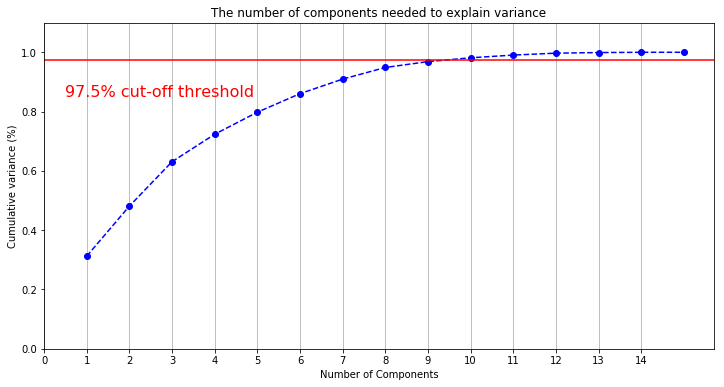

In [66]:
# #95% of variance
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.975)
pca = PCA().fit(normalized_data_gt)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
print("cummulative vairances",y)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 15, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.975, color='r', linestyle='-')
plt.text(0.5, 0.85, '97.5% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [79]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(normalized_data_gt)

In [80]:
pca.explained_variance_ratio_

array([0.31242804, 0.16878742, 0.14971652])

In [88]:
pca_df = pd.concat([pd.DataFrame(principalComponents,columns=["p1","p2","p3"], index=data_gt.index), labels_gt[['Hand-eye Coordination']]], axis = 1)

In [89]:
pca_df

p1        p2        p3  Hand-eye Coordination
VIDEO                                                        
E1_t10   -1.794291 -1.328490  1.205462                      4
E1_t11   -1.515724 -0.956284  0.414860                      4
E1_t12    0.656007 -0.980550  1.031899                      4
E1_t1    -0.985149  3.522394  2.844891                      3
E1_t2    -1.737645 -1.060155 -0.853656                      3
E1_t3    -3.297563  0.538015  0.885237                      4
E1_t4    -0.695286  1.490715  1.512567                      3
E1_t5    -2.819055  0.825581  0.690764                      3
E1_t6    -0.997197  0.132090  1.183446                      3
E1_t7     0.254625 -2.233417  0.816696                      4
E1_t8    -2.052354 -0.193221  0.596641                      3
E1_t9    -3.451444 -0.108644  0.104197                      4
E2_t10   -3.476875  2.544837  0.000307                      4
E2_t11    0.267836 -1.418291 -0.096997                      4
E2_t12    0.529441  1.338646  0.957888                      3
E2_t1    -0.740132 -0.161344 -0.223534                      4
E2_t2    -0.065543 -1.653898  1.099485                      4
E2_t3    -2.683439  0.580850  0.773461                      4
E2_t4    -0.488264 -1.554500  0.712556                      4
E2_t5    -2.470249 -0.527347 -1.414365                      4
E2_t6    -0.933587  0.768800  1.351052                      3
E2_t7     2.022236 -2.420002  2.793413                      3
E2_t8    -1.329670 -0.477673 -1.429572                      4
E2_t9    -0.099022 -0.730461 -0.604562                      4
E3_t10   -3.389719  0.128533 -1.309457                      4
E3_t11   -0.649845 -1.768207  0.358439                      4
E3_t12   -0.908213 -1.043403 -1.253406                      4
E3_t1    -0.810206 -0.470933 -0.563048                      4
E3_t2     0.106121 -2.472658 -0.383317                      4
E3_t3    -3.288063 -0.406693 -1.029419                      4
...            ...       ...       ...                    ...
T1_1_t4   0.709676 -0.863614 -0.825005                      2
T1_1_t5   4.466174  3.534953 -1.384492                      1
T1_1_t6   4.471944  2.966979  0.902654                      1
T1_1_t7   2.069771 -1.129710 -1.241706                      1
T1_1_t8   3.402673  1.425651 -0.915553                      1
T1_1_t9   4.696413  1.842533 -1.903734                      1
T3_2_t10 -0.065258 -1.511736 -0.359501                      3
T3_2_t11  0.460291 -1.102558 -1.164803                      3
T3_2_t12  1.881162  0.382294 -0.087516                      3
T3_2_t1   0.570921 -0.886342 -1.491307                      3
T3_2_t2  -1.025799 -1.128436 -0.718554                      3
T3_2_t3  -2.893654  1.536849 -0.662751                      3
T3_2_t4  -1.207466 -0.350729 -0.768565                      3
T3_2_t5  -2.465290  2.319769 -0.087931                      4
T3_2_t6   0.449369  0.169747  1.064002                      3
T3_2_t7  -0.107994 -0.324456 -1.854020                      3
T3_2_t8   0.779722 -0.368023 -1.972184                      3
T3_2_t9  -2.174077 -0.078437 -1.101164                      3
T8_1_t10  0.850632 -2.314818 -0.921151                      3
T8_1_t11  0.444997 -0.060639 -1.937717                      3
T8_1_t12  2.123224 -0.512134  0.415162                      3
T8_1_t1   2.611674 -0.530484 -2.358643                      2
T8_1_t2   4.399234 -0.388398 -1.145658                      2
T8_1_t3  -0.461020  7.320383  1.134986                      2
T8_1_t4   2.007766 -0.130805  0.764855                      2
T8_1_t5  -0.304461  2.363033 -0.749051                      3
T8_1_t6   1.118851  1.370669  0.051512                      3
T8_1_t7   0.690756 -1.422198 -0.703136                      3
T8_1_t8   0.225617  0.030263 -1.867493                      3
T8_1_t9  -0.534842  0.267923 -1.670365                      3

[96 rows x 4 columns]

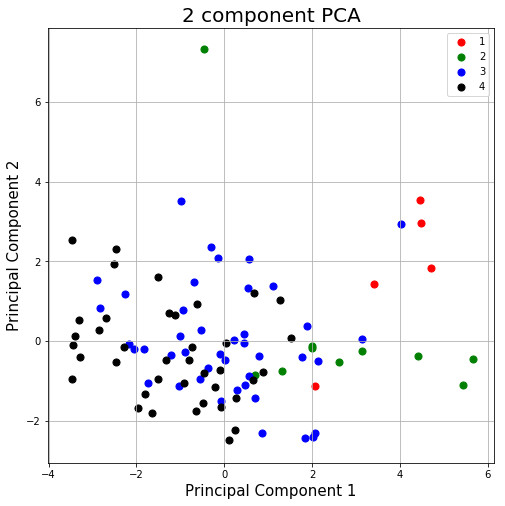

In [90]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,2,3,4]
colors = ['r', 'g', 'b', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['Hand-eye Coordination'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'p1']
               , pca_df.loc[indicesToKeep, 'p2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [91]:
from mpl_toolkits import mplot3d 

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


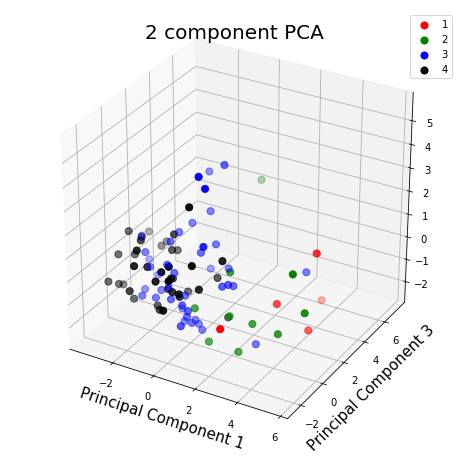

In [93]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax = plt.axes(projection ="3d") 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)

ax.set_title('2 component PCA', fontsize = 20)
targets = [1,2,3,4]
colors = ['r', 'g', 'b', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['Hand-eye Coordination'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'p1']
               , pca_df.loc[indicesToKeep, 'p2']
               , pca_df.loc[indicesToKeep, 'p3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

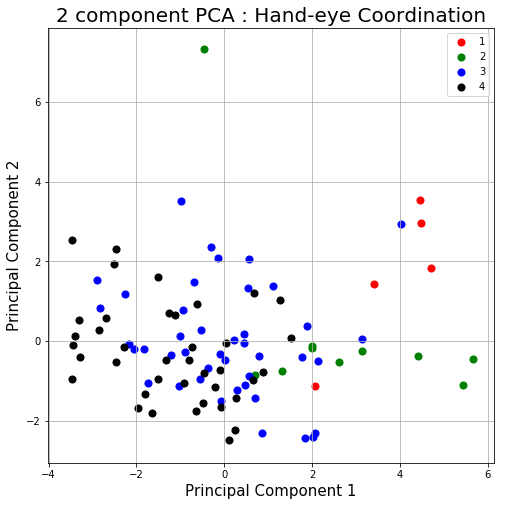

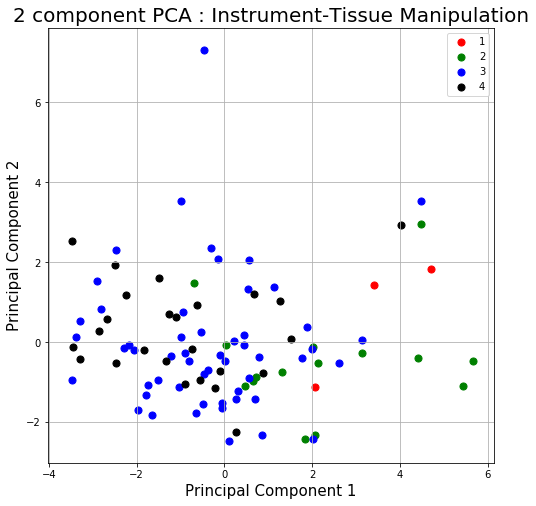

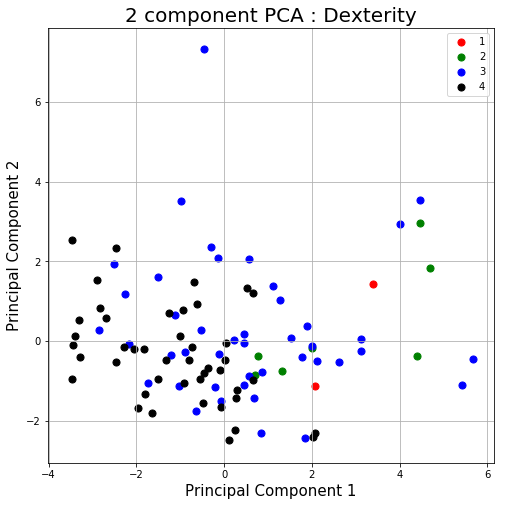

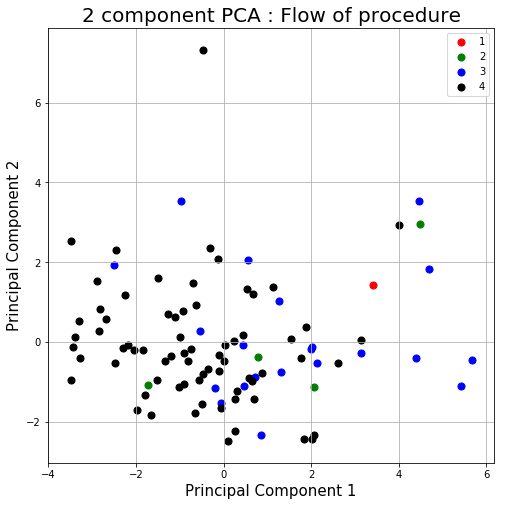

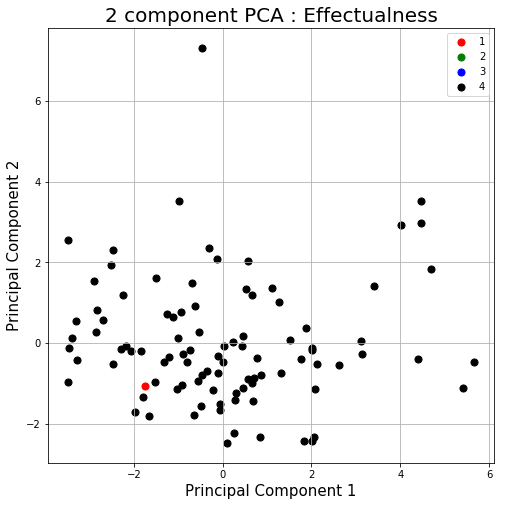

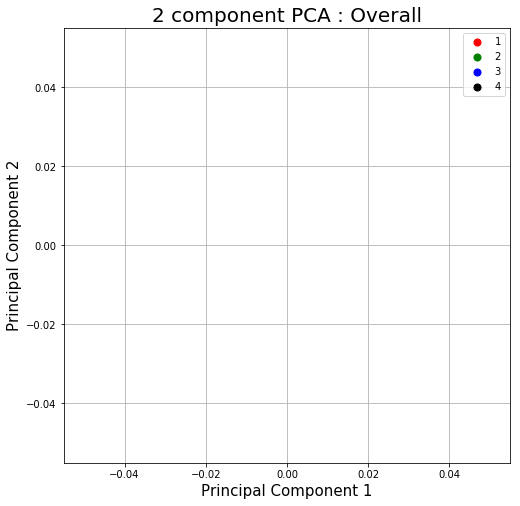

In [99]:
for y_col in labels_gt.columns:
    pca_df = pd.concat([pd.DataFrame(principalComponents,columns=["p1","p2","p3"], index=data_gt.index), labels_gt[[y_col]]], axis = 1)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA : '+y_col, fontsize = 20)
    targets = [1,2,3,4]
    colors = ['r', 'g', 'b', 'k']
    for target, color in zip(targets,colors):
        indicesToKeep = pca_df[y_col] == target
        ax.scatter(pca_df.loc[indicesToKeep, 'p1']
                   , pca_df.loc[indicesToKeep, 'p2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()




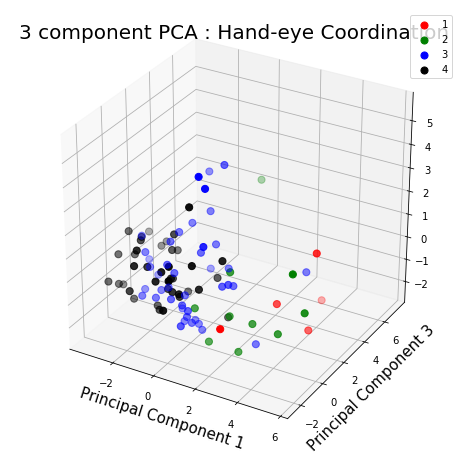

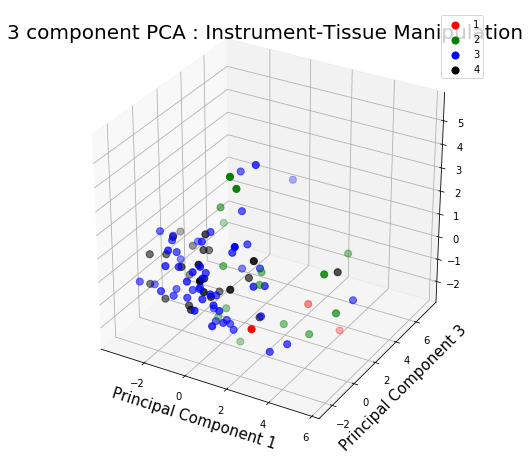

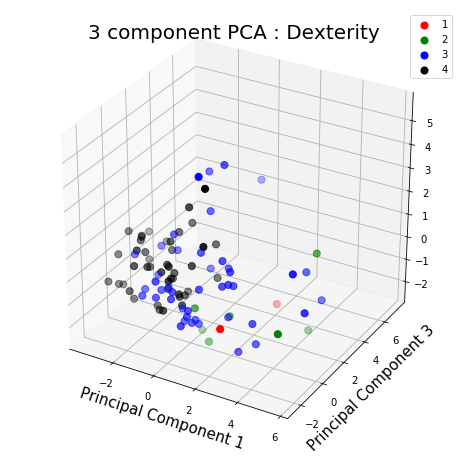

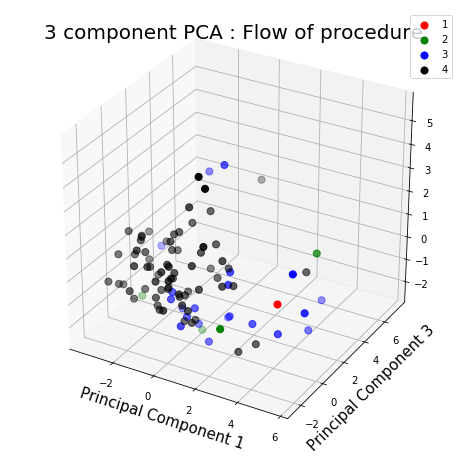

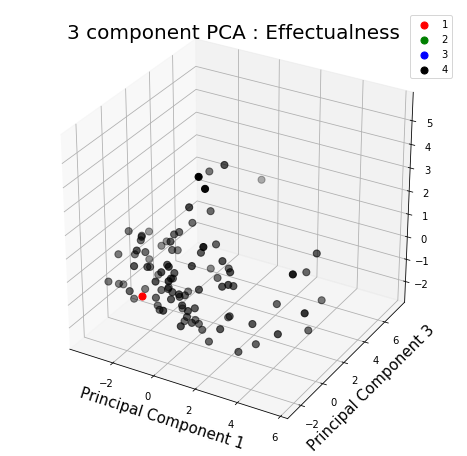

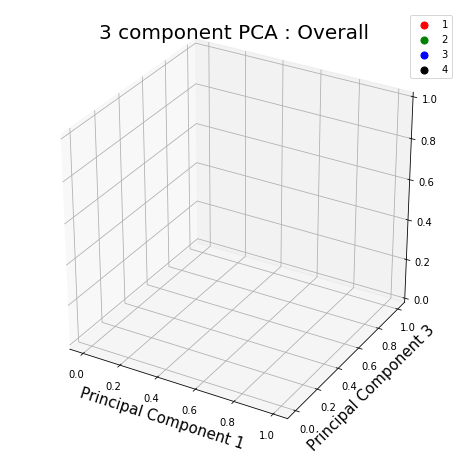

In [100]:
for y_col in labels_gt.columns:
    pca_df = pd.concat([pd.DataFrame(principalComponents,columns=["p1","p2","p3"], index=data_gt.index), labels_gt[[y_col]]], axis = 1)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax = plt.axes(projection ="3d") 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_ylabel('Principal Component 3', fontsize = 15)

    ax.set_title('3 component PCA : '+y_col, fontsize = 20)
    targets = [1,2,3,4]
    colors = ['r', 'g', 'b', 'k']
    for target, color in zip(targets,colors):
        indicesToKeep = pca_df[y_col] == target
        ax.scatter(pca_df.loc[indicesToKeep, 'p1']
                   , pca_df.loc[indicesToKeep, 'p2']
                   , pca_df.loc[indicesToKeep, 'p3']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

No handles with labels found to put in legend.
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
No handles with labels found to put in legend.
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes insta

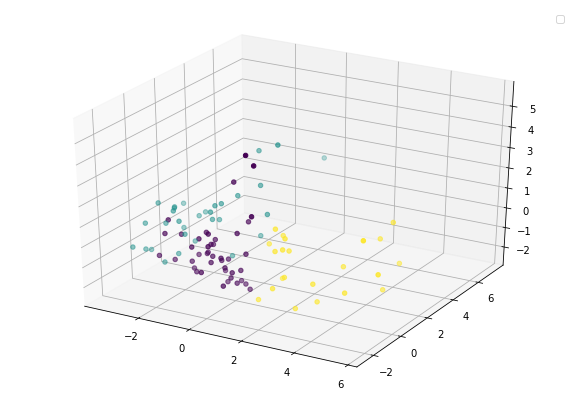

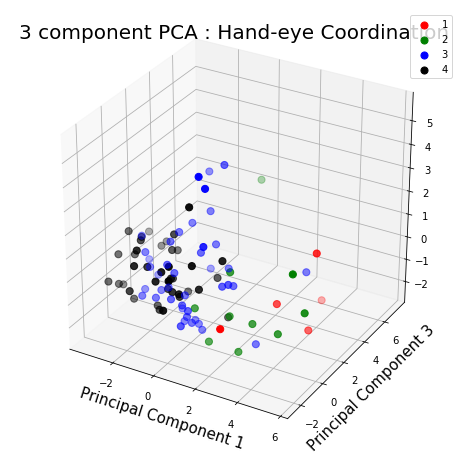

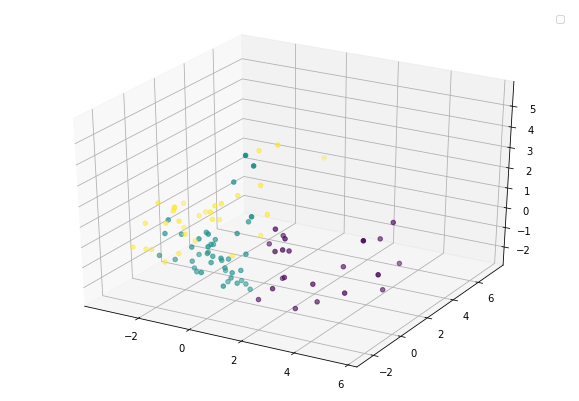

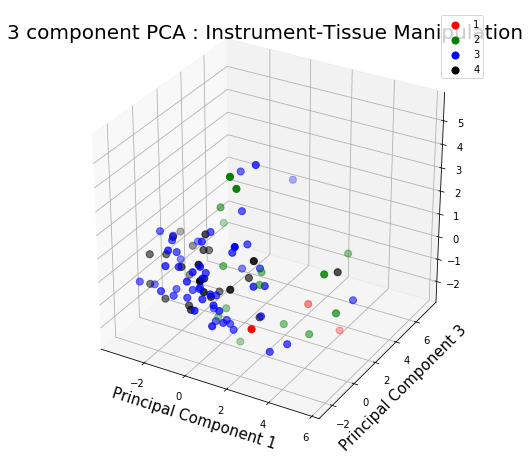

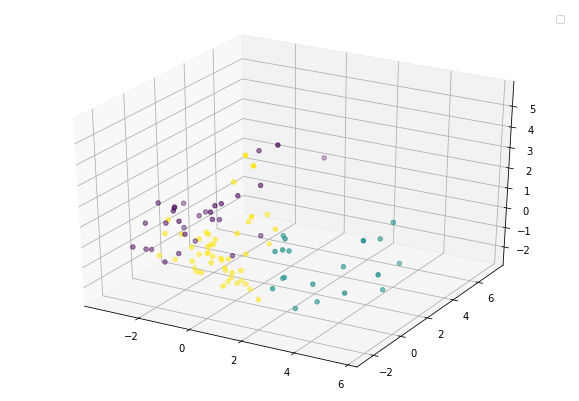

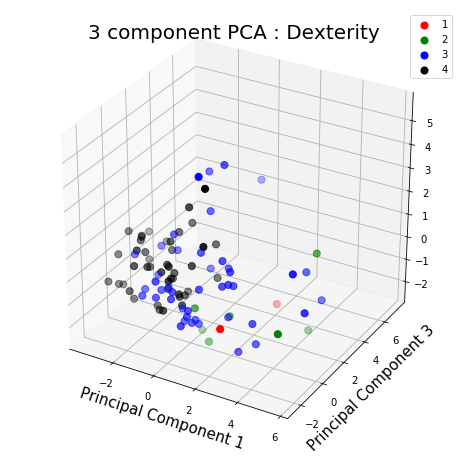

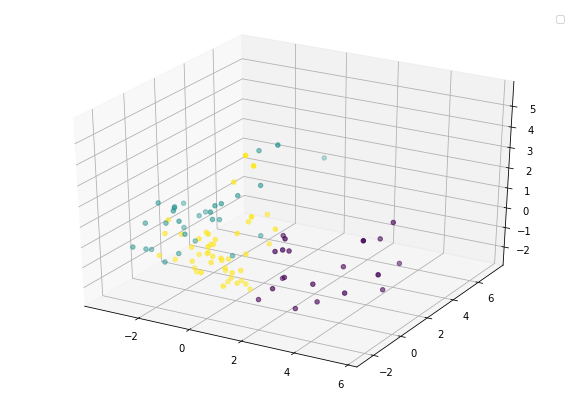

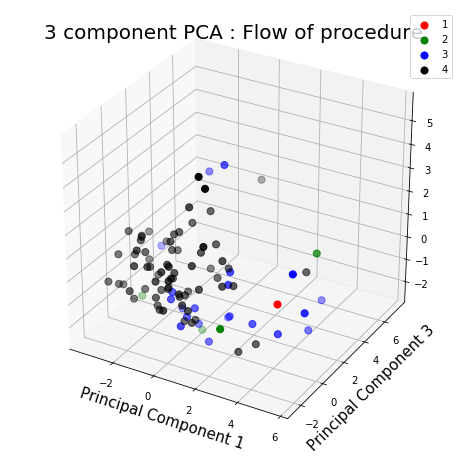

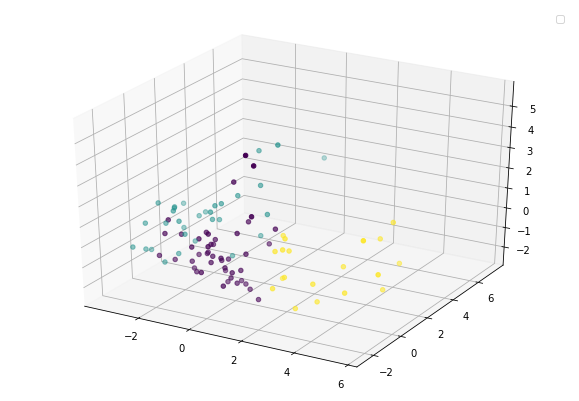

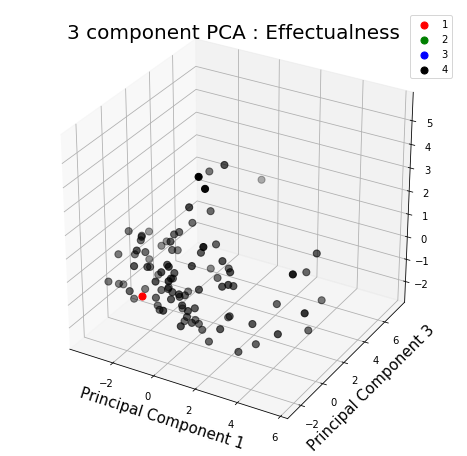

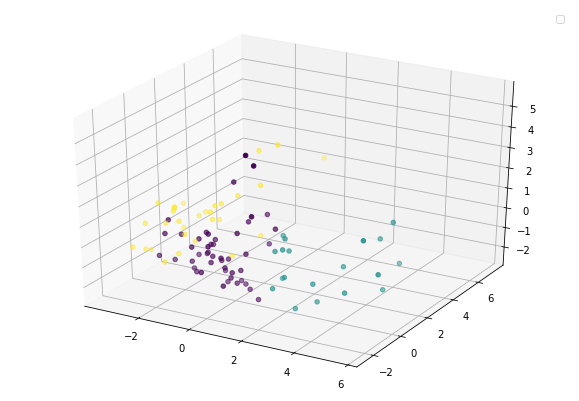

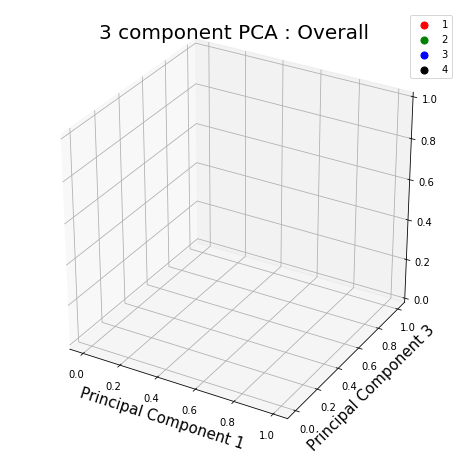

In [110]:
from sklearn.cluster import KMeans
for y_col in labels_gt.columns:
    pca_df = pd.concat([pd.DataFrame(principalComponents,columns=["p1","p2","p3"], index=data_gt.index), labels_gt[[y_col]]], axis = 1)

    estimator = KMeans(n_clusters=3)
    x= pd.DataFrame(principalComponents,columns=["p1","p2","p3"], index=data_gt.index)
    estimator.fit(x)

    labels_est = estimator.labels_ #labels_gt['Hand-eye Coordination']
    fig = plt.figure(figsize = (10, 7)) 
    ax = plt.axes(projection ="3d") 

    ax.scatter(x["p1"], x["p2"], x["p3"],
               c=labels_est.astype(np.float))
    ax.legend()


    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax = plt.axes(projection ="3d") 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_ylabel('Principal Component 3', fontsize = 15)

    ax.set_title('3 component PCA : '+y_col, fontsize = 20)
    targets = [1,2,3,4]
    colors = ['r', 'g', 'b', 'k']
    for target, color in zip(targets,colors):
        indicesToKeep = pca_df[y_col] == target
        ax.scatter(pca_df.loc[indicesToKeep, 'p1']
                   , pca_df.loc[indicesToKeep, 'p2']
                   , pca_df.loc[indicesToKeep, 'p3']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

In [71]:
labels_gt.columns

Index(['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

In [83]:
# pd.DataFrame(labels_gt.loc["T1_1_t8"])

In [84]:
def upsample_data(data_X, data_Y, p="TARGET", r_state=0):
            data_XY = data_X.join(data_Y)

            df = data_XY.copy()

            max_len = max(data_Y[p].value_counts())
            
            extracted_x_max = pd.DataFrame()
            for key, val in data_Y[p].value_counts().items():
                extracted_x = df.loc[df[p] == key]
                extracted_x = resample(extracted_x, 
                                       replace=True,     # sample with replacement
                                       n_samples=max_len,    # to match majority class
                                       random_state=0,
                                        stratify=None) 
                extracted_x_max = pd.concat([extracted_x_max,extracted_x])
            
            return extracted_x_max


In [86]:
def regressor_random_forest(X,Y, X_test, Y_test):

#     regressor = make_pipeline(preprocessing.StandardScaler(),RandomForestRegressor(random_state=0))

    regressor = RandomForestRegressor(random_state=0)
#     regressor = linear_model.LinearRegression()
    regressor.fit(X, Y)

    res={}
    res["r^2_Score"]= regressor.score(X, Y)
    Y_pred = regressor.predict(X_test).ravel()
    Y_Pred_training = regressor.predict(X)
    res["Correlation: Test labels and Ground Truth Labels"]= pearsonr(Y_pred,Y_test)[0]
    res["Mean Squared Error Testing"]= mean_squared_error(Y_pred, Y_test)
    res["Mean Absolute Error Testing"]= mean_absolute_error(Y_pred, Y_test)
    
    res["Correlation: Training labels and Ground Truth"]= pearsonr(Y_Pred_training,Y)[0]
    res["Mean Squared Error Training"]= mean_squared_error(Y_Pred_training, Y)
    res["Mean Absolute Error Training"]= mean_absolute_error(Y_Pred_training, Y)

    Y_pred_truncated = [round(x) for x in Y_pred] #rounding to nearest integer
    Y_Pred_training_truncated =  [round(x) for x in Y_Pred_training.ravel()]
    
    res["Correlation: Rounded Test Labels and Ground Truth Labels"]= pearsonr(Y_pred_truncated,Y_test)[0]
    res["Correlation: Rounded Training Labels and Ground Truth Labels"]= pearsonr(Y_Pred_training_truncated,Y)[0]
    
    for y1, y2, y3, idx in zip(Y_pred, Y_pred_truncated, Y_test, X_test.index):
        print(y1, " ", y2, " ", y3, " ", idx)
    
    res["Mean Absolute Error Loss Rounded Test labels"]= mean_absolute_error(Y_pred_truncated, Y_test)
    res["Mean Squared Error Loss Rounded Test labels"]= mean_squared_error(Y_pred_truncated, Y_test)
    res["Accuracy: Rounded Test and Ground Truth Labels"]= accuracy_score(Y_pred_truncated, Y_test)
    
    res["Mean Absolute Error Loss Rounded Training labels"]= mean_absolute_error(Y_Pred_training_truncated, Y)
    res["Mean Squared Error Loss Rounded Training labels"]= mean_squared_error(Y_Pred_training_truncated, Y)
    res["Accuracy: Rounded Training and Ground Truth Labels"]= accuracy_score(Y_Pred_training_truncated, Y)
    
    res["F1_score_Macro_test"]= f1_score(Y_test, Y_pred_truncated, average='macro')
    res["F1_score_Micro_test"]= f1_score(Y_test, Y_pred_truncated, average='micro')
    res["F1_score_weighted_test"]= f1_score(Y_test, Y_pred_truncated, average='weighted')
    res["F1_score_None"]= f1_score(Y_test, Y_pred_truncated, average=None)

    print(res)
    
#     print(regressor.decision_path)
#     print(regressor.feature_importances_)

    return res

p = ['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity', 'Flow of procedure', 'Overall']
for parameter in p:
    print("\n Parameter : ", parameter)

    augmentations=["perturb_X", "perturb_Y",  "pertub_X,perturb_Y"]

 

    results_before_upsampling = []
    results_after_upsampling = []
    results_after_augmentation = []
    results_after_augmentation_up = []


    skf = StratifiedKFold(n_splits=10, shuffle = True, random_state=10)
    fold_number = 0
    X_raw = data_gt
    Y = labels_gt.loc[:,parameter]
    Y_target = target.loc[:,parameter]

    for train_index, test_index in skf.split(X_raw, Y):

        fold_number = fold_number + 1;
        print("\n fold number : {one}".format(one=fold_number))
        X_train, X_test = X_raw.iloc[train_index], X_raw.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index],Y.iloc[test_index]


        train_index_aug = []
        #Data-Augmentation
        for aug in augmentations:
            train_index_aug = train_index_aug + [x+"_aug_"+aug for x in X_train.index]

        X_train_aug = data_gt_aug.loc[train_index_aug]
        Y_train_aug = Y_target.loc[train_index_aug]

        dataset = {}

        #Upsampling code
        label_target = pd.DataFrame(Y_train)[[parameter]].rename(columns={parameter:"TARGET"})

        temp_df = upsample_data(X_train, label_target)
        resampled_X = pd.DataFrame(temp_df.iloc[:,:15])
        labels_Y = pd.DataFrame(temp_df["TARGET"])
        

        X_train_after, Y_train_after =resampled_X, labels_Y
        
        #augmentation upsampling
        label_target = pd.DataFrame(Y_train_aug)[[parameter]].rename(columns={parameter:"TARGET"})
        temp_df = upsample_data(X_train_aug, label_target, r_state=100)

        resampled_X = pd.DataFrame(temp_df.iloc[:,:15])
        labels_Y = pd.DataFrame(temp_df["TARGET"])


        X_train_aug_up, Y_train_aug_up =resampled_X, labels_Y


        # Upsampling ends
        print("#############################################################################")
        #print(dataset[parameter][1]["TARGET"].value_counts())
        print("Before upsampling-------->")
        res_before = regressor_random_forest(X_train,Y_train.values.ravel(), X_test, Y_test.values.ravel())
        results_before_upsampling.append(res_before)
        print("After upsampling-------->")
        res = regressor_random_forest(X_train_after,Y_train_after.values.ravel(), X_test, Y_test)
        results_after_upsampling.append(res)
        print("Augmentation --------->")
        res = regressor_random_forest(X_train_aug,Y_train_aug.ravel(), X_test, Y_test)
        results_after_augmentation.append(res)
        print("Augmentation upsampling--------->")
        res = regressor_random_forest(X_train_aug_up,Y_train_aug_up.values.ravel(), X_test, Y_test)
        results_after_augmentation_up.append(res)
        print("#############################################################################")

    #     print("Augmentation and Upsampling --------->")
    #     print(len(X_train_aug), len(Y_train_aug))
    #     res = regressor_random_forest(X_train_aug,Y_train_aug, X_test_aug, Y_test_aug)
    #     results_after_augmentation.append(res)
    
    out = {}

    def generate_ouput(metric):
        print("Results for "+metric+" \n")
        output = {}
        val = []
        print("results_before_upsampling")
        for res in results_before_upsampling:
            val.append(res[metric])

        print(np.array(val).mean())
        output["No Augmentation"] = np.array(val).mean()

        val = []
        print("results_after_upsampling")
        for res in results_after_upsampling:
            val.append(res[metric])

        print(np.array(val).mean())
        output["Label Balancing Only"] = np.array(val).mean()


        val = []
        print("results_after_augmentation")
        for res in results_after_augmentation:
            val.append(res[metric])
        output["Augmentation Only"] = np.array(val).mean()
        print(np.array(val).mean())

        val = []
        print("results_after_augmentation_upsampling")
        for res in results_after_augmentation_up:
            val.append(res[metric])
        output["Augmentation and Label Balancing"] = np.array(val).mean()

        print(np.array(val).mean())

        return output

    metric_list=["Correlation: Test labels and Ground Truth Labels","Mean Squared Error Testing","Mean Absolute Error Testing"
,"Correlation: Training labels and Ground Truth","Mean Squared Error Training","Mean Absolute Error Training",
"Correlation: Rounded Test Labels and Ground Truth Labels","Correlation: Rounded Training Labels and Ground Truth Labels"
,"Mean Absolute Error Loss Rounded Test labels","Mean Squared Error Loss Rounded Test labels","Accuracy: Rounded Test and Ground Truth Labels"  
,"Mean Absolute Error Loss Rounded Training labels","Mean Squared Error Loss Rounded Training labels","Accuracy: Rounded Training and Ground Truth Labels" ]
    for metric  in metric_list:
        out[metric] = generate_ouput(metric)

    save=pd.DataFrame(out).T
    save = save.reindex(columns = ["No Augmentation","Augmentation Only","Label Balancing Only", "Augmentation and Label Balancing"])
    
    if not(os.path.exists("/home/kunaldargan/ROBO_SURGERY/scripts/data/results/"+parameter)):
        os.mkdir("/home/kunaldargan/ROBO_SURGERY/scripts/data/results/"+parameter)
        
    save.to_csv("/home/kunaldargan/ROBO_SURGERY/scripts/data/results/"+parameter+"/result_10_extra_5.csv")




 Parameter :  Hand-eye Coordination

 fold number : 1
#############################################################################
Before upsampling-------->


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


3.49   3.0   4   E1_t12
3.91   4.0   3   E1_t2
3.27   3.0   3   E1_t4
3.32   3.0   4   E2_t11
3.67   4.0   4   E2_t4
3.75   4.0   3   E3_t8
3.24   3.0   3   E4_t1
3.59   4.0   4   E5_t5
3.18   3.0   3   T8_1_t11
1.65   2.0   2   T8_1_t2
{'r^2_Score': 0.9235045731707318, 'Correlation: Test labels and Ground Truth Labels': 0.6529158505701497, 'Mean Squared Error Testing': 0.26755000000000007, 'Mean Absolute Error Testing': 0.4630000000000001, 'Correlation: Training labels and Ground Truth': 0.9687784427478691, 'Mean Squared Error Training': 0.05427906976744185, 'Mean Absolute Error Training': 0.1851162790697674, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.5121951219512195, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9590553917335538, 'Mean Absolute Error Loss Rounded Test labels': 0.4, 'Mean Squared Error Loss Rounded Test labels': 0.4, 'Accuracy: Rounded Test and Ground Truth Labels': 0.6, 'Mean Absolute Error Loss Rounded Training labels': 0.0581

3.89   4.0   3   E1_t5
3.79   4.0   4   E1_t7
3.94   4.0   4   E1_t9
3.53   4.0   3   E2_t12
3.07   3.0   3   E2_t7
3.53   4.0   4   E3_t10
3.98   4.0   4   E3_t4
3.5   4.0   3   E5_t4
1.39   1.0   2   T1_1_t10
2.33   2.0   1   T1_1_t8
{'r^2_Score': 0.9906892610973256, 'Correlation: Test labels and Ground Truth Labels': 0.7905520335541261, 'Mean Squared Error Testing': 0.37379000000000007, 'Mean Absolute Error Testing': 0.46900000000000003, 'Correlation: Training labels and Ground Truth': 0.9962075733173793, 'Mean Squared Error Training': 0.006087984496124026, 'Mean Absolute Error Training': 0.049573643410852644, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.7899542124297604, 'Correlation: Rounded Training Labels and Ground Truth Labels': 1.0, 'Mean Absolute Error Loss Rounded Test labels': 0.5, 'Mean Squared Error Loss Rounded Test labels': 0.5, 'Accuracy: Rounded Test and Ground Truth Labels': 0.5, 'Mean Absolute Error Loss Rounded Training labels': 0.0, 'Mean Squared

3.68   4.0   4   E1_t3
3.44   3.0   4   E2_t1
3.72   4.0   4   E2_t3
3.6   4.0   3   E5_t11
3.34   3.0   3   E5_t6
3.57   4.0   4   E5_t8
2.14   2.0   3   T1_1_t11
1.86   2.0   2   T1_1_t12
2.31   2.0   1   T1_1_t7
3.51   4.0   3   T3_2_t6
{'r^2_Score': 0.9257334160463192, 'Correlation: Test labels and Ground Truth Labels': 0.7511208750880223, 'Mean Squared Error Testing': 0.38903, 'Mean Absolute Error Testing': 0.5349999999999999, 'Correlation: Training labels and Ground Truth': 0.970768679453443, 'Mean Squared Error Training': 0.048560465116279074, 'Mean Absolute Error Training': 0.1841860465116279, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.7052225554744063, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9913960094292942, 'Mean Absolute Error Loss Rounded Test labels': 0.5, 'Mean Squared Error Loss Rounded Test labels': 0.5, 'Accuracy: Rounded Test and Ground Truth Labels': 0.5, 'Mean Absolute Error Loss Rounded Training labels': 0.0116279069767

3.88   4.0   4   E2_t2
3.91   4.0   3   E2_t6
3.97   4.0   4   E3_t3
3.04   3.0   4   E4_t6
2.44   2.0   4   E4_t8
1.33   1.0   3   E4_t9
3.88   4.0   3   E5_t1
1.99   2.0   2   T1_1_t2
1.15   1.0   1   T1_1_t6
1.55   2.0   3   T3_2_t8
{'r^2_Score': 0.9944723600771987, 'Correlation: Test labels and Ground Truth Labels': 0.6083635749363016, 'Mean Squared Error Testing': 0.9887, 'Mean Absolute Error Testing': 0.7740000000000001, 'Correlation: Training labels and Ground Truth': 0.9976717979444318, 'Mean Squared Error Training': 0.0036143410852713157, 'Mean Absolute Error Training': 0.037790697674418554, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.5623879281134899, 'Correlation: Rounded Training Labels and Ground Truth Labels': 1.0, 'Mean Absolute Error Loss Rounded Test labels': 0.8, 'Mean Squared Error Loss Rounded Test labels': 1.2, 'Accuracy: Rounded Test and Ground Truth Labels': 0.4, 'Mean Absolute Error Loss Rounded Training labels': 0.0, 'Mean Squared Error Loss R

3.8   4.0   4   E2_t5
3.69   4.0   4   E3_t6
3.41   3.0   4   E4_t5
3.54   4.0   4   E5_t12
3.22   3.0   3   E5_t2
3.7   4.0   3   T3_2_t9
2.37   2.0   2   T8_1_t4
3.18   3.0   3   T8_1_t5
3.27   3.0   3   T8_1_t9
{'r^2_Score': 0.9217917168674699, 'Correlation: Test labels and Ground Truth Labels': 0.8225555718675117, 'Mean Squared Error Testing': 0.1640444444444445, 'Mean Absolute Error Testing': 0.36666666666666675, 'Correlation: Training labels and Ground Truth': 0.9686481043907665, 'Mean Squared Error Training': 0.05488735632183907, 'Mean Absolute Error Training': 0.18758620689655173, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.75, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9754355747585856, 'Mean Absolute Error Loss Rounded Test labels': 0.2222222222222222, 'Mean Squared Error Loss Rounded Test labels': 0.2222222222222222, 'Accuracy: Rounded Test and Ground Truth Labels': 0.7777777777777778, 'Mean Absolute Error Loss Rounded Training labels

3.72   4.0   4   E2_t10
3.94   4.0   4   E3_t2
3.66   4.0   4   E5_t10
3.66   4.0   4   E5_t3
3.37   3.0   3   E5_t7
1.43   1.0   2   T1_1_t4
3.17   3.0   3   T3_2_t7
3.22   3.0   3   T8_1_t10
3.23   3.0   3   T8_1_t7
{'r^2_Score': 0.9899919427710844, 'Correlation: Test labels and Ground Truth Labels': 0.8974271388939523, 'Mean Squared Error Testing': 0.10057777777777777, 'Mean Absolute Error Testing': 0.2866666666666666, 'Correlation: Training labels and Ground Truth': 0.9956239442506737, 'Mean Squared Error Training': 0.007023754789272025, 'Mean Absolute Error Training': 0.052873563218390734, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.970142500145332, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9972775689361751, 'Mean Absolute Error Loss Rounded Test labels': 0.1111111111111111, 'Mean Squared Error Loss Rounded Test labels': 0.1111111111111111, 'Accuracy: Rounded Test and Ground Truth Labels': 0.8888888888888888, 'Mean Absolute Error Loss Roun

3.27   3.0   3   E1_t1
3.56   4.0   3   E1_t6
3.7   4.0   4   E3_t12
3.43   3.0   4   E4_t10
3.04   3.0   3   E4_t12
3.47   3.0   4   E5_t9
2.09   2.0   2   T1_1_t1
3.55   4.0   3   T3_2_t4
3.25   3.0   3   T8_1_t6
{'r^2_Score': 0.9157367871785315, 'Correlation: Test labels and Ground Truth Labels': 0.7724800541905582, 'Mean Squared Error Testing': 0.16188888888888883, 'Mean Absolute Error Testing': 0.35111111111111104, 'Correlation: Training labels and Ground Truth': 0.9659735875052794, 'Mean Squared Error Training': 0.05973793103448275, 'Mean Absolute Error Training': 0.19885057471264364, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.43749999999999994, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9676662748031993, 'Mean Absolute Error Loss Rounded Test labels': 0.4444444444444444, 'Mean Squared Error Loss Rounded Test labels': 0.4444444444444444, 'Accuracy: Rounded Test and Ground Truth Labels': 0.5555555555555556, 'Mean Absolute Error Loss Rounde

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


3.49   3.0   3   E1_t11
3.09   3.0   3   E3_t11
2.61   3.0   3   E4_t12
3.03   3.0   3   E4_t1
3.14   3.0   4   E4_t3
3.18   3.0   4   E4_t5
3.41   3.0   4   E5_t5
1.84   2.0   3   T1_1_t11
1.61   2.0   2   T1_1_t12
3.24   3.0   3   T8_1_t6
{'r^2_Score': 0.878290397672163, 'Correlation: Test labels and Ground Truth Labels': 0.6491496218490648, 'Mean Squared Error Testing': 0.37166, 'Mean Absolute Error Testing': 0.506, 'Correlation: Training labels and Ground Truth': 0.9573930728579508, 'Mean Squared Error Training': 0.06786511627906976, 'Mean Absolute Error Training': 0.20418604651162786, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.5833333333333334, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.914052370217864, 'Mean Absolute Error Loss Rounded Test labels': 0.4, 'Mean Squared Error Loss Rounded Test labels': 0.4, 'Accuracy: Rounded Test and Ground Truth Labels': 0.6, 'Mean Absolute Error Loss Rounded Training labels': 0.09302325581395349, 'Mean S

3.39   3.0   2   E1_t12
3.31   3.0   4   E2_t1
3.0   3.0   3   E2_t6
2.63   3.0   3   E2_t7
3.32   3.0   4   E2_t8
3.35   3.0   4   E3_t3
3.34   3.0   3   E3_t4
3.73   4.0   3   T3_2_t3
2.76   3.0   3   T8_1_t10
3.3   3.0   3   T8_1_t9
{'r^2_Score': 0.9853941804073715, 'Correlation: Test labels and Ground Truth Labels': 0.08856877221476317, 'Mean Squared Error Testing': 0.42261, 'Mean Absolute Error Testing': 0.5389999999999999, 'Correlation: Training labels and Ground Truth': 0.9957217378163964, 'Mean Squared Error Training': 0.008144186046511622, 'Mean Absolute Error Training': 0.06511627906976739, 'Correlation: Rounded Test Labels and Ground Truth Labels': -0.11111111111111109, 'Correlation: Rounded Training Labels and Ground Truth Labels': 1.0, 'Mean Absolute Error Loss Rounded Test labels': 0.5, 'Mean Squared Error Loss Rounded Test labels': 0.5, 'Accuracy: Rounded Test and Ground Truth Labels': 0.5, 'Mean Absolute Error Loss Rounded Training labels': 0.0, 'Mean Squared Error Loss

3.05   3.0   3   E1_t10
3.4   3.0   2   E1_t4
3.16   3.0   3   E2_t11
3.6   4.0   4   E3_t8
3.4   3.0   3   E3_t9
2.84   3.0   4   E4_t8
3.64   4.0   3   E5_t1
2.72   3.0   2   E5_t7
3.49   3.0   3   E5_t8
2.86   3.0   1   T1_1_t7
{'r^2_Score': 0.8889617929562433, 'Correlation: Test labels and Ground Truth Labels': 0.37159863740315063, 'Mean Squared Error Testing': 0.82814, 'Mean Absolute Error Testing': 0.728, 'Correlation: Training labels and Ground Truth': 0.9607276792641599, 'Mean Squared Error Training': 0.05626976744186046, 'Mean Absolute Error Training': 0.18720930232558136, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.4014775342734832, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9289625663593334, 'Mean Absolute Error Loss Rounded Test labels': 0.6, 'Mean Squared Error Loss Rounded Test labels': 0.8, 'Accuracy: Rounded Test and Ground Truth Labels': 0.5, 'Mean Absolute Error Loss Rounded Training labels': 0.06976744186046512, 'Mean Squared 

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


3.3   3.0   3   E1_t8
3.33   3.0   3   E2_t2
3.13   3.0   3   E3_t6
3.31   3.0   4   E4_t6
3.38   3.0   4   E5_t10
2.74   3.0   2   T1_1_t1
3.11   3.0   2   T1_1_t6
2.92   3.0   1   T1_1_t8
3.25   3.0   3   T3_2_t2
3.43   3.0   3   T8_1_t3
{'r^2_Score': 0.9816596051227321, 'Correlation: Test labels and Ground Truth Labels': 0.7644426369381109, 'Mean Squared Error Testing': 0.6789799999999999, 'Mean Absolute Error Testing': 0.6519999999999999, 'Correlation: Training labels and Ground Truth': 0.9946161544856216, 'Mean Squared Error Training': 0.009294186046511624, 'Mean Absolute Error Training': 0.06709302325581389, 'Correlation: Rounded Test Labels and Ground Truth Labels': nan, 'Correlation: Rounded Training Labels and Ground Truth Labels': 1.0, 'Mean Absolute Error Loss Rounded Test labels': 0.6, 'Mean Squared Error Loss Rounded Test labels': 0.8, 'Accuracy: Rounded Test and Ground Truth Labels': 0.5, 'Mean Absolute Error Loss Rounded Training labels': 0.0, 'Mean Squared Error Loss Ro

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


3.31   3.0   3   E1_t8
3.01   3.0   3   E2_t2
3.26   3.0   3   E3_t6
3.44   3.0   4   E4_t6
3.29   3.0   4   E5_t10
2.71   3.0   2   T1_1_t1
3.3   3.0   2   T1_1_t6
3.33   3.0   1   T1_1_t8
3.29   3.0   3   T3_2_t2
3.43   3.0   3   T8_1_t3
{'r^2_Score': 0.9980255555555556, 'Correlation: Test labels and Ground Truth Labels': 0.2947732794036966, 'Mean Squared Error Testing': 0.88735, 'Mean Absolute Error Testing': 0.6910000000000001, 'Correlation: Training labels and Ground Truth': 0.9990130965309045, 'Mean Squared Error Training': 0.002468055555555555, 'Mean Absolute Error Training': 0.014826388888888854, 'Correlation: Rounded Test Labels and Ground Truth Labels': nan, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9993067603532056, 'Mean Absolute Error Loss Rounded Test labels': 0.6, 'Mean Squared Error Loss Rounded Test labels': 0.8, 'Accuracy: Rounded Test and Ground Truth Labels': 0.5, 'Mean Absolute Error Loss Rounded Training labels': 0.001736111111111111, 'Mean

3.72   4.0   3   E1_t5
2.78   3.0   3   E2_t4
3.28   3.0   3   E3_t5
3.43   3.0   4   E3_t7
2.98   3.0   4   E5_t11
2.5   2.0   2   E5_t2
3.22   3.0   2   E5_t9
2.65   3.0   3   T3_2_t1
3.35   3.0   3   T8_1_t8
{'r^2_Score': 0.9917816666666667, 'Correlation: Test labels and Ground Truth Labels': 0.30471504911924985, 'Mean Squared Error Testing': 0.4437666666666667, 'Mean Absolute Error Testing': 0.5811111111111111, 'Correlation: Training labels and Ground Truth': 0.9960524000047447, 'Mean Squared Error Training': 0.010272916666666665, 'Mean Absolute Error Training': 0.04874999999999997, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.35355339059327373, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9979276042017899, 'Mean Absolute Error Loss Rounded Test labels': 0.4444444444444444, 'Mean Squared Error Loss Rounded Test labels': 0.4444444444444444, 'Accuracy: Rounded Test and Ground Truth Labels': 0.5555555555555556, 'Mean Absolute Error Loss Rounded Tr

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


3.4   3.0   3   E1_t5
3.03   3.0   3   E2_t4
3.45   3.0   3   E3_t5
3.13   3.0   4   E3_t7
2.8   3.0   4   E5_t11
2.87   3.0   2   E5_t2
3.14   3.0   2   E5_t9
3.03   3.0   3   T3_2_t1
3.02   3.0   3   T8_1_t8
{'r^2_Score': 0.9856882211538461, 'Correlation: Test labels and Ground Truth Labels': -0.06540699401677326, 'Mean Squared Error Testing': 0.5131222222222224, 'Mean Absolute Error Testing': 0.5566666666666666, 'Correlation: Training labels and Ground Truth': 0.9960610259966872, 'Mean Squared Error Training': 0.007865900383141762, 'Mean Absolute Error Training': 0.06337164750957848, 'Correlation: Rounded Test Labels and Ground Truth Labels': nan, 'Correlation: Rounded Training Labels and Ground Truth Labels': 1.0, 'Mean Absolute Error Loss Rounded Test labels': 0.4444444444444444, 'Mean Squared Error Loss Rounded Test labels': 0.4444444444444444, 'Accuracy: Rounded Test and Ground Truth Labels': 0.5555555555555556, 'Mean Absolute Error Loss Rounded Training labels': 0.0, 'Mean Squa

3.0   3.0   3   E1_t1
2.91   3.0   4   E1_t7
3.01   3.0   4   E2_t3
2.88   3.0   3   E3_t2
3.41   3.0   4   E4_t10
2.85   3.0   3   E5_t6
3.13   3.0   3   T3_2_t12
3.1   3.0   3   T8_1_t11
2.38   2.0   2   T8_1_t12
{'r^2_Score': 0.8713830536912751, 'Correlation: Test labels and Ground Truth Labels': 0.693498929948216, 'Mean Squared Error Testing': 0.3027222222222223, 'Mean Absolute Error Testing': 0.39444444444444443, 'Correlation: Training labels and Ground Truth': 0.9539921619717663, 'Mean Squared Error Training': 0.07089310344827587, 'Mean Absolute Error Training': 0.20977011494252878, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.6875, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9606338572525474, 'Mean Absolute Error Loss Rounded Test labels': 0.3333333333333333, 'Mean Squared Error Loss Rounded Test labels': 0.3333333333333333, 'Accuracy: Rounded Test and Ground Truth Labels': 0.6666666666666666, 'Mean Absolute Error Loss Rounded Training labe

3.4   3.0   4   E3_t12
3.21   3.0   3   E3_t1
2.61   3.0   4   E4_t11
3.75   4.0   3   E4_t4
3.82   4.0   4   E5_t3
2.08   2.0   2   T1_1_t2
2.65   3.0   3   T3_2_t6
2.24   2.0   3   T3_2_t8
3.44   3.0   3   T3_2_t9
{'r^2_Score': 0.9831401006711409, 'Correlation: Test labels and Ground Truth Labels': 0.49590865786955296, 'Mean Squared Error Testing': 0.4256888888888889, 'Mean Absolute Error Testing': 0.5288888888888889, 'Correlation: Training labels and Ground Truth': 0.9947513700425109, 'Mean Squared Error Training': 0.00929310344827586, 'Mean Absolute Error Training': 0.0677011494252873, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.5303300858899106, 'Correlation: Rounded Training Labels and Ground Truth Labels': 1.0, 'Mean Absolute Error Loss Rounded Test labels': 0.4444444444444444, 'Mean Squared Error Loss Rounded Test labels': 0.4444444444444444, 'Accuracy: Rounded Test and Ground Truth Labels': 0.5555555555555556, 'Mean Absolute Error Loss Rounded Training labels

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


3.28   3.0   4   E1_t4
3.9   4.0   4   E1_t8
3.48   3.0   4   E3_t2
3.79   4.0   3   E3_t7
3.73   4.0   4   E3_t9
3.21   3.0   4   E5_t8
2.61   3.0   3   T1_1_t1
2.49   2.0   2   T1_1_t3
3.66   4.0   3   T3_2_t4
3.45   3.0   3   T3_2_t9
{'r^2_Score': 0.9099949959644875, 'Correlation: Test labels and Ground Truth Labels': 0.5527959059277706, 'Mean Squared Error Testing': 0.31502000000000013, 'Mean Absolute Error Testing': 0.518, 'Correlation: Training labels and Ground Truth': 0.9659402554326955, 'Mean Squared Error Training': 0.04523372093023255, 'Mean Absolute Error Training': 0.16918604651162789, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.42379344841320993, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9795833685679376, 'Mean Absolute Error Loss Rounded Test labels': 0.5, 'Mean Squared Error Loss Rounded Test labels': 0.5, 'Accuracy: Rounded Test and Ground Truth Labels': 0.5, 'Mean Absolute Error Loss Rounded Training labels': 0.023255813953488

3.42   3.0   4   E1_t6
3.87   4.0   4   E2_t2
3.79   4.0   4   E2_t6
3.69   4.0   4   E4_t5
3.06   3.0   3   E5_t4
2.98   3.0   2   T1_1_t9
3.23   3.0   3   T3_2_t11
2.78   3.0   3   T3_2_t12
3.49   3.0   4   T3_2_t5
3.1   3.0   3   T8_1_t5
{'r^2_Score': 0.9860322302932473, 'Correlation: Test labels and Ground Truth Labels': 0.8249127027835059, 'Mean Squared Error Testing': 0.18289, 'Mean Absolute Error Testing': 0.333, 'Correlation: Training labels and Ground Truth': 0.9937778027352719, 'Mean Squared Error Training': 0.007019767441860462, 'Mean Absolute Error Training': 0.05399224806201544, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.5921565254637919, 'Correlation: Rounded Training Labels and Ground Truth Labels': 1.0, 'Mean Absolute Error Loss Rounded Test labels': 0.3, 'Mean Squared Error Loss Rounded Test labels': 0.3, 'Accuracy: Rounded Test and Ground Truth Labels': 0.7, 'Mean Absolute Error Loss Rounded Training labels': 0.0, 'Mean Squared Error Loss Rounded Tr

3.46   3.0   4   E1_t7
3.66   4.0   4   E2_t8
3.4   3.0   4   E2_t9
3.58   4.0   4   E4_t1
3.57   4.0   3   E5_t3
3.58   4.0   3   E5_t7
3.58   4.0   4   E5_t9
2.7   3.0   2   T1_1_t6
3.16   3.0   3   T3_2_t1
3.23   3.0   3   T8_1_t8
{'r^2_Score': 0.9018022060801721, 'Correlation: Test labels and Ground Truth Labels': 0.7655501920472508, 'Mean Squared Error Testing': 0.23498000000000002, 'Mean Absolute Error Testing': 0.45600000000000007, 'Correlation: Training labels and Ground Truth': 0.9596998331370286, 'Mean Squared Error Training': 0.04935116279069766, 'Mean Absolute Error Training': 0.17883720930232558, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.30151134457776363, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9795833685679378, 'Mean Absolute Error Loss Rounded Test labels': 0.5, 'Mean Squared Error Loss Rounded Test labels': 0.5, 'Accuracy: Rounded Test and Ground Truth Labels': 0.5, 'Mean Absolute Error Loss Rounded Training labels': 0.0232

3.95   4.0   4   E1_t9
3.94   4.0   4   E2_t4
3.96   4.0   4   E2_t5
3.99   4.0   3   E3_t11
3.93   4.0   4   E3_t5
2.3   2.0   1   T1_1_t7
3.71   4.0   3   T3_2_t7
2.68   3.0   3   T8_1_t1
3.61   4.0   3   T8_1_t6
3.22   3.0   3   T8_1_t7
{'r^2_Score': 0.9908450802919708, 'Correlation: Test labels and Ground Truth Labels': 0.8266880660772874, 'Mean Squared Error Testing': 0.37096999999999997, 'Mean Absolute Error Testing': 0.43699999999999994, 'Correlation: Training labels and Ground Truth': 0.9960974811167006, 'Mean Squared Error Training': 0.004239534883720925, 'Mean Absolute Error Training': 0.04217054263565884, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.8300573566392895, 'Correlation: Rounded Training Labels and Ground Truth Labels': 1.0, 'Mean Absolute Error Loss Rounded Test labels': 0.4, 'Mean Squared Error Loss Rounded Test labels': 0.4, 'Accuracy: Rounded Test and Ground Truth Labels': 0.6, 'Mean Absolute Error Loss Rounded Training labels': 0.0, 'Mean Squa

3.63   4.0   3   E1_t1
3.83   4.0   3   E1_t2
2.78   3.0   4   E2_t12
3.9   4.0   4   E3_t12
3.56   4.0   4   E5_t11
2.39   2.0   4   E5_t2
1.9   2.0   3   T1_1_t2
3.53   4.0   3   T3_2_t6
3.17   3.0   3   T8_1_t10
{'r^2_Score': 0.9877485, 'Correlation: Test labels and Ground Truth Labels': -0.04150088402959318, 'Mean Squared Error Testing': 0.7655222222222222, 'Mean Absolute Error Testing': 0.7366666666666667, 'Correlation: Training labels and Ground Truth': 0.9940701421506463, 'Mean Squared Error Training': 0.015314374999999996, 'Mean Absolute Error Training': 0.05343749999999996, 'Correlation: Rounded Test Labels and Ground Truth Labels': -0.09128709291752767, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9902123332302285, 'Mean Absolute Error Loss Rounded Test labels': 0.7777777777777778, 'Mean Squared Error Loss Rounded Test labels': 1.0, 'Accuracy: Rounded Test and Ground Truth Labels': 0.3333333333333333, 'Mean Absolute Error Loss Rounded Training labels': 0.

3.76   4.0   4   E1_t5
3.78   4.0   4   E2_t10
3.34   3.0   4   E2_t1
3.43   3.0   4   E3_t1
3.51   4.0   3   E4_t11
3.9   4.0   3   E4_t3
2.2   2.0   3   E4_t8
2.13   2.0   2   T1_1_t4
3.14   3.0   3   T3_2_t10
{'r^2_Score': 0.9980225, 'Correlation: Test labels and Ground Truth Labels': 0.6604565368321811, 'Mean Squared Error Testing': 0.29034444444444435, 'Mean Absolute Error Testing': 0.4633333333333333, 'Correlation: Training labels and Ground Truth': 0.9990314287449457, 'Mean Squared Error Training': 0.0024718749999999984, 'Mean Absolute Error Training': 0.017604166666666643, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.4949747468305834, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.999168401335536, 'Mean Absolute Error Loss Rounded Test labels': 0.5555555555555556, 'Mean Squared Error Loss Rounded Test labels': 0.5555555555555556, 'Accuracy: Rounded Test and Ground Truth Labels': 0.4444444444444444, 'Mean Absolute Error Loss Rounded Training l

3.77   4.0   4   E3_t3
3.89   4.0   4   E3_t8
3.45   3.0   4   E4_t2
3.22   3.0   4   E4_t4
3.42   3.0   3   E4_t7
1.71   2.0   3   E4_t9
1.64   2.0   2   T1_1_t10
1.46   1.0   3   T1_1_t11
2.48   2.0   3   T1_1_t5
{'r^2_Score': 0.988983, 'Correlation: Test labels and Ground Truth Labels': 0.7908137569581132, 'Mean Squared Error Testing': 0.6208888888888888, 'Mean Absolute Error Testing': 0.6444444444444444, 'Correlation: Training labels and Ground Truth': 0.9946156676277005, 'Mean Squared Error Training': 0.013771250000000002, 'Mean Absolute Error Training': 0.054749999999999965, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.7071067811865476, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.997515586302805, 'Mean Absolute Error Loss Rounded Test labels': 0.6666666666666666, 'Mean Squared Error Loss Rounded Test labels': 0.8888888888888888, 'Accuracy: Rounded Test and Ground Truth Labels': 0.4444444444444444, 'Mean Absolute Error Loss Rounded Training l

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


#############################################################################
Before upsampling-------->
3.96   4.0   4   E1_t11
3.84   4.0   4   E1_t12
3.96   4.0   4   E1_t3
3.85   4.0   4   E2_t11
3.13   3.0   4   E4_t12
4.0   4.0   4   E5_t11
3.09   3.0   3   T1_1_t10
2.94   3.0   3   T1_1_t3
3.68   4.0   4   T3_2_t7
3.44   3.0   3   T8_1_t9
{'r^2_Score': 0.8743051452572628, 'Correlation: Test labels and Ground Truth Labels': 0.7340406626588001, 'Mean Squared Error Testing': 0.11159000000000001, 'Mean Absolute Error Testing': 0.217, 'Correlation: Training labels and Ground Truth': 0.9512279078399432, 'Mean Squared Error Training': 0.048554651162790695, 'Mean Absolute Error Training': 0.14034883720930227, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.8017837257372731, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9237066978063645, 'Mean Absolute Error Loss Rounded Test labels': 0.1, 'Mean Squared Error Loss Rounded Test labels': 0.1, 'Accuracy: Ro

4.0   4.0   3   E1_t1
3.95   4.0   2   E1_t2
3.74   4.0   4   E2_t7
3.99   4.0   4   E3_t1
3.39   3.0   4   E4_t1
4.0   4.0   4   E5_t12
3.65   4.0   3   E5_t4
4.0   4.0   4   E5_t9
2.39   2.0   4   T8_1_t1
3.19   3.0   4   T8_1_t8
{'r^2_Score': 0.9794508785140562, 'Correlation: Test labels and Ground Truth Labels': -0.3140944667256563, 'Mean Squared Error Testing': 0.8913, 'Mean Absolute Error Testing': 0.6900000000000001, 'Correlation: Training labels and Ground Truth': 0.9913016268194955, 'Mean Squared Error Training': 0.007379457364341084, 'Mean Absolute Error Training': 0.042751937984496086, 'Correlation: Rounded Test Labels and Ground Truth Labels': -0.36363636363636365, 'Correlation: Rounded Training Labels and Ground Truth Labels': 1.0, 'Mean Absolute Error Loss Rounded Test labels': 0.8, 'Mean Squared Error Loss Rounded Test labels': 1.2, 'Accuracy: Rounded Test and Ground Truth Labels': 0.4, 'Mean Absolute Error Loss Rounded Training labels': 0.0, 'Mean Squared Error Loss Rou

3.87   4.0   4   E2_t2
3.94   4.0   4   E2_t6
3.93   4.0   4   E3_t4
3.94   4.0   4   E4_t10
3.9   4.0   4   E4_t5
2.53   3.0   4   E4_t9
3.81   4.0   4   E5_t8
2.24   2.0   3   T1_1_t12
3.27   3.0   2   T3_2_t8
3.15   3.0   3   T8_1_t4
{'r^2_Score': 0.8576596385542169, 'Correlation: Test labels and Ground Truth Labels': 0.4745225412430714, 'Mean Squared Error Testing': 0.4449000000000001, 'Mean Absolute Error Testing': 0.426, 'Correlation: Training labels and Ground Truth': 0.94239121512793, 'Mean Squared Error Training': 0.05111627906976744, 'Mean Absolute Error Training': 0.14139534883720925, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.674199862463242, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9382853768796213, 'Mean Absolute Error Loss Rounded Test labels': 0.3, 'Mean Squared Error Loss Rounded Test labels': 0.3, 'Accuracy: Rounded Test and Ground Truth Labels': 0.7, 'Mean Absolute Error Loss Rounded Training labels': 0.046511627906976744, 

4.0   4.0   4   E1_t5
2.6   3.0   4   E2_t9
3.27   3.0   4   E4_t11
4.0   4.0   4   E4_t4
4.0   4.0   4   E5_t6
3.41   3.0   3   T1_1_t2
1.9   2.0   3   T1_1_t5
2.47   2.0   2   T1_1_t6
3.96   4.0   4   T8_1_t3
3.92   4.0   4   T8_1_t5
{'r^2_Score': 0.9984626455026455, 'Correlation: Test labels and Ground Truth Labels': 0.6478642600120876, 'Mean Squared Error Testing': 0.40998999999999997, 'Mean Absolute Error Testing': 0.42300000000000004, 'Correlation: Training labels and Ground Truth': 0.999262341734302, 'Mean Squared Error Training': 0.0019216931216931203, 'Mean Absolute Error Training': 0.007751322751322742, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.8106960083062921, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9989446097348638, 'Mean Absolute Error Loss Rounded Test labels': 0.3, 'Mean Squared Error Loss Rounded Test labels': 0.3, 'Accuracy: Rounded Test and Ground Truth Labels': 0.7, 'Mean Absolute Error Loss Rounded Training labels': 0.0

3.89   4.0   4   E1_t6
3.94   4.0   4   E2_t1
3.66   4.0   4   E4_t7
3.95   4.0   4   E5_t10
3.94   4.0   4   E5_t7
2.75   3.0   4   T1_1_t11
3.38   3.0   3   T3_2_t10
3.85   4.0   4   T3_2_t6
3.49   3.0   3   T8_1_t12
{'r^2_Score': 0.9959974603174603, 'Correlation: Test labels and Ground Truth Labels': 0.306607976434811, 'Mean Squared Error Testing': 0.2341, 'Mean Absolute Error Testing': 0.32111111111111107, 'Correlation: Training labels and Ground Truth': 0.998253052210646, 'Mean Squared Error Training': 0.005003174603174601, 'Mean Absolute Error Training': 0.022380952380952356, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.7559289460184546, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9984190355371733, 'Mean Absolute Error Loss Rounded Test labels': 0.1111111111111111, 'Mean Squared Error Loss Rounded Test labels': 0.1111111111111111, 'Accuracy: Rounded Test and Ground Truth Labels': 0.8888888888888888, 'Mean Absolute Error Loss Rounded Training

3.85   4.0   4   E1_t8
3.74   4.0   4   E3_t12
3.91   4.0   4   E3_t2
4.0   4.0   4   E3_t3
3.92   4.0   4   E5_t2
3.02   3.0   3   T1_1_t4
4.0   4.0   4   T3_2_t2
4.0   4.0   4   T3_2_t4
3.05   3.0   3   T8_1_t2
{'r^2_Score': 0.9987377777777777, 'Correlation: Test labels and Ground Truth Labels': 0.9772588331742259, 'Mean Squared Error Testing': 0.011944444444444428, 'Mean Absolute Error Testing': 0.07222222222222216, 'Correlation: Training labels and Ground Truth': 0.9993938691032737, 'Mean Squared Error Training': 0.0015777777777777776, 'Mean Absolute Error Training': 0.007301587301587292, 'Correlation: Rounded Test Labels and Ground Truth Labels': 1.0, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9989446097348638, 'Mean Absolute Error Loss Rounded Test labels': 0.0, 'Mean Squared Error Loss Rounded Test labels': 0.0, 'Accuracy: Rounded Test and Ground Truth Labels': 1.0, 'Mean Absolute Error Loss Rounded Training labels': 0.0026455026455026454, 'Mean Squared Er

3.93   4.0   4   E3_t10
3.37   3.0   4   E3_t11
3.82   4.0   3   E3_t7
4.0   4.0   4   E3_t8
3.85   4.0   4   E4_t6
3.42   3.0   3   E4_t8
3.9   4.0   4   E5_t3
3.96   4.0   4   T3_2_t9
3.79   4.0   4   T8_1_t6
{'r^2_Score': 0.9972765079365079, 'Correlation: Test labels and Ground Truth Labels': 0.40046468539447616, 'Mean Squared Error Testing': 0.14764444444444438, 'Mean Absolute Error Testing': 0.2711111111111111, 'Correlation: Training labels and Ground Truth': 0.9989300354818454, 'Mean Squared Error Training': 0.0034043650793650795, 'Mean Absolute Error Training': 0.021865079365079344, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.35714285714285715, 'Correlation: Rounded Training Labels and Ground Truth Labels': 1.0, 'Mean Absolute Error Loss Rounded Test labels': 0.2222222222222222, 'Mean Squared Error Loss Rounded Test labels': 0.2222222222222222, 'Accuracy: Rounded Test and Ground Truth Labels': 0.7777777777777778, 'Mean Absolute Error Loss Rounded Training label

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


#############################################################################
Before upsampling-------->
17.46   17.0   17   E2_t2
18.41   18.0   20   E3_t3
18.11   18.0   17   E3_t7
17.09   17.0   18   E4_t10
15.54   16.0   19   E4_t11
15.97   16.0   19   E4_t7
11.35   11.0   10   T1_1_t3
11.93   12.0   11   T1_1_t4
10.43   10.0   8   T1_1_t9
15.47   15.0   12   T8_1_t9
{'r^2_Score': 0.9177270232449661, 'Correlation: Test labels and Ground Truth Labels': 0.881997078089542, 'Mean Squared Error Testing': 4.65856, 'Mean Absolute Error Testing': 1.874, 'Correlation: Training labels and Ground Truth': 0.9673000112533472, 'Mean Squared Error Training': 1.1447023255813957, 'Mean Absolute Error Training': 0.7858139534883722, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.912769389634661, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9614803434032635, 'Mean Absolute Error Loss Rounded Test labels': 1.7, 'Mean Squared Error Loss Rounded Test labels': 3.9, 'Acc

18.01   18.0   19   E1_t10
17.96   18.0   18   E1_t12
19.08   19.0   8   E1_t2
19.56   20.0   20   E2_t5
17.27   17.0   17   E2_t6
18.18   18.0   19   E3_t2
15.42   15.0   17   E5_t6
8.14   8.0   11   T1_1_t10
10.11   10.0   10   T1_1_t2
14.18   14.0   12   T3_2_t11
{'r^2_Score': 0.987904418357563, 'Correlation: Test labels and Ground Truth Labels': 0.5659825931014136, 'Mean Squared Error Testing': 14.012749999999997, 'Mean Absolute Error Testing': 2.037, 'Correlation: Training labels and Ground Truth': 0.9953413723927831, 'Mean Squared Error Training': 0.16829147286821708, 'Mean Absolute Error Training': 0.2809302325581395, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.5697140412738803, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9943728982435999, 'Mean Absolute Error Loss Rounded Test labels': 2.0, 'Mean Squared Error Loss Rounded Test labels': 14.0, 'Accuracy: Rounded Test and Ground Truth Labels': 0.4, 'Mean Absolute Error Loss Rounded Training

#############################################################################
Before upsampling-------->
18.71   19.0   19   E1_t11
14.9   15.0   17   E2_t12
18.74   19.0   20   E2_t8
17.62   18.0   19   E3_t10
15.78   16.0   18   E4_t1
12.17   12.0   17   E4_t8
9.95   10.0   10   T1_1_t5
17.03   17.0   16   T3_2_t5
16.02   16.0   13   T3_2_t7
10.46   10.0   12   T8_1_t1
{'r^2_Score': 0.9269125444937801, 'Correlation: Test labels and Ground Truth Labels': 0.7978977873448879, 'Mean Squared Error Testing': 4.87988, 'Mean Absolute Error Testing': 1.7719999999999998, 'Correlation: Training labels and Ground Truth': 0.9724601913803804, 'Mean Squared Error Training': 1.0771802325581394, 'Mean Absolute Error Training': 0.7759302325581394, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.8021448407966744, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.970331188310332, 'Mean Absolute Error Loss Rounded Test labels': 1.7, 'Mean Squared Error Loss Rounded Test labe

16.58   17.0   15   E1_t1
18.44   18.0   17   E1_t8
18.71   19.0   20   E1_t9
18.9   19.0   19   E3_t1
19.05   19.0   19   E5_t3
16.74   17.0   17   E5_t5
15.96   16.0   16   E5_t7
11.79   12.0   13   T1_1_t11
10.97   11.0   7   T1_1_t7
11.12   11.0   12   T8_1_t4
{'r^2_Score': 0.9901584293503582, 'Correlation: Test labels and Ground Truth Labels': 0.9170068749954831, 'Mean Squared Error Testing': 2.4315200000000003, 'Mean Absolute Error Testing': 1.0820000000000003, 'Correlation: Training labels and Ground Truth': 0.9962692582727667, 'Mean Squared Error Training': 0.14089573643410855, 'Mean Absolute Error Training': 0.2559302325581395, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.9204356478745489, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9950553091253508, 'Mean Absolute Error Loss Rounded Test labels': 1.0, 'Mean Squared Error Loss Rounded Test labels': 2.4, 'Accuracy: Rounded Test and Ground Truth Labels': 0.4, 'Mean Absolute Error Loss Round

#############################################################################
Before upsampling-------->
17.46   17.0   18   E1_t3
17.81   18.0   17   E1_t6
17.25   17.0   20   E2_t10
18.87   19.0   19   E3_t8
13.43   13.0   16   E4_t12
17.97   18.0   20   E5_t12
10.41   10.0   5   T1_1_t8
18.35   18.0   15   T3_2_t2
19.14   19.0   13   T3_2_t9
{'r^2_Score': 0.9266910191229997, 'Correlation: Test labels and Ground Truth Labels': 0.7025565078365896, 'Mean Squared Error Testing': 10.827011111111112, 'Mean Absolute Error Testing': 2.6366666666666667, 'Correlation: Training labels and Ground Truth': 0.9717634866845517, 'Mean Squared Error Training': 1.0058701149425284, 'Mean Absolute Error Training': 0.7182758620689654, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.7030370997340349, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9715529370008125, 'Mean Absolute Error Loss Rounded Test labels': 2.6666666666666665, 'Mean Squared Error Loss Rounded Test labe

18.62   19.0   19   E2_t1
17.81   18.0   18   E4_t4
15.99   16.0   20   E4_t6
8.49   8.0   17   E4_t9
10.38   10.0   16   E5_t2
11.68   12.0   11   T1_1_t1
17.28   17.0   14   T3_2_t10
17.43   17.0   15   T3_2_t4
13.11   13.0   13   T8_1_t5
{'r^2_Score': 0.9916903284768211, 'Correlation: Test labels and Ground Truth Labels': 0.3310323963055669, 'Mean Squared Error Testing': 15.266988888888887, 'Mean Absolute Error Testing': 2.801111111111111, 'Correlation: Training labels and Ground Truth': 0.9968039963762717, 'Mean Squared Error Training': 0.12433218390804597, 'Mean Absolute Error Training': 0.23819923371647522, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.3262715568199536, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.9959269520801028, 'Mean Absolute Error Loss Rounded Test labels': 2.7777777777777777, 'Mean Squared Error Loss Rounded Test labels': 16.333333333333332, 'Accuracy: Rounded Test and Ground Truth Labels': 0.3333333333333333, 'Mean Abso

14.8   15.0   17   E2_t7
17.13   17.0   20   E2_t9
18.72   19.0   19   E3_t9
17.06   17.0   17   E5_t1
16.72   17.0   18   E5_t8
9.71   10.0   11   T1_1_t12
12.27   12.0   8   T1_1_t6
10.54   11.0   10   T3_2_t8
13.48   13.0   12   T8_1_t3
{'r^2_Score': 0.9176639192326723, 'Correlation: Test labels and Ground Truth Labels': 0.8901021796972417, 'Mean Squared Error Testing': 4.130700000000001, 'Mean Absolute Error Testing': 1.5855555555555556, 'Correlation: Training labels and Ground Truth': 0.9671953308569278, 'Mean Squared Error Training': 1.1431977011494254, 'Mean Absolute Error Training': 0.7786206896551722, 'Correlation: Rounded Test Labels and Ground Truth Labels': 0.9088013037213201, 'Correlation: Rounded Training Labels and Ground Truth Labels': 0.959372600098847, 'Mean Absolute Error Loss Rounded Test labels': 1.4444444444444444, 'Mean Squared Error Loss Rounded Test labels': 3.6666666666666665, 'Accuracy: Rounded Test and Ground Truth Labels': 0.2222222222222222, 'Mean Absolute

In [146]:
# X_train_after X_train_aug X_train_aug_up
X_train_aug_up.index

Index(['E5_t9_aug_pertub_X,perturb_Y', 'E1_t5_aug_perturb_X',
       'E2_t12_aug_perturb_X', 'E2_t12_aug_perturb_X',
       'E4_t3_aug_pertub_X,perturb_Y', 'E4_t3_aug_perturb_X',
       'E2_t2_aug_perturb_Y', 'E2_t6_aug_perturb_Y',
       'E2_t6_aug_pertub_X,perturb_Y', 'E3_t7_aug_perturb_Y',
       ...
       'T8_1_t12_aug_perturb_Y', 'T8_1_t12_aug_perturb_Y',
       'T1_1_t7_aug_perturb_X', 'T8_1_t12_aug_perturb_X',
       'T8_1_t12_aug_perturb_X', 'T8_1_t12_aug_perturb_X',
       'T1_1_t7_aug_perturb_X', 'T1_1_t7_aug_perturb_Y',
       'T1_1_t7_aug_pertub_X,perturb_Y', 'T8_1_t12_aug_perturb_Y'],
      dtype='object', name='VIDEO', length=585)

In [149]:
Y_train_aug_up.head()

TARGET
VIDEO                               
E5_t9_aug_pertub_X,perturb_Y      17
E1_t5_aug_perturb_X               17
E2_t12_aug_perturb_X              17
E2_t12_aug_perturb_X              17
E4_t3_aug_pertub_X,perturb_Y      17

In [153]:
labels_gt["Overall"].loc["E4_t3"]

17

In [56]:
random.choices(labels_gt.index, k = 15)

['E5_t7',
 'E4_t10',
 'E3_t12',
 'T1_1_t2',
 'E4_t5',
 'T1_1_t3',
 'T1_1_t12',
 'E2_t10',
 'T3_2_t11',
 'T8_1_t8',
 'T8_1_t7',
 'E5_t8',
 'E1_t2',
 'E1_t10',
 'E2_t10']

In [54]:
pd.DataFrame(data_gt.join(labels_gt).loc["E1_t2"]).T

NUMBER_OF_HITS  HIT_INTENSITY  NUMBER_OF_TUG  TOTAL_FRAMES_IN_TUG  \
E1_t2             0.0            0.0            1.0                  3.0   

       NUMBER_OF_JERK_FRAMES   TIME  NUMBER_OF_RINGDROP  VARIANCE  ARC_LENGTH  \
E1_t2                    0.0  10.68                 1.0  0.039239    1.886396   

       CURVATURE_MAX_COUNT  Hand-eye Coordination  \
E1_t2                  7.0                    3.0   

       Instrument-Tissue Manipulation  Dexterity  Flow of procedure  \
E1_t2                             3.0        3.0                2.0   

       Effectualness  Overall  
E1_t2            1.0      8.0

In [82]:
X_train.columns

Index(['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK_FRAMES', 'TIME',
       'NUMBER_OF_RINGDROP', 'VARIANCE', 'ARC_LENGTH', 'CURVATURE_MAX_COUNT'],
      dtype='object')

In [84]:
X_train[['TIME','VARIANCE', 'ARC_LENGTH', 'CURVATURE_MAX_COUNT']]

TIME  VARIANCE  ARC_LENGTH  CURVATURE_MAX_COUNT
VIDEO                                                     
E1_t10    11.96  0.052821    2.750350                    1
E1_t11    12.96  0.048060    2.638573                    5
E1_t12    20.96  0.039564    3.522528                   10
E1_t1     19.96  0.062609    3.874484                    8
E1_t2     10.68  0.039239    1.886396                    7
E1_t3      8.96  0.058930    2.086997                    3
E1_t4     16.84  0.057878    3.858408                    7
E1_t5     11.00  0.061005    2.589191                    4
E1_t6     12.96  0.062297    3.308289                    4
E1_t7     17.76  0.036587    2.682000                    6
E1_t8     12.92  0.043536    2.290343                    7
E1_t9      7.64  0.056178    1.839921                    4
E2_t10     9.56  0.062549    2.444690                    4
E2_t11    20.84  0.032915    2.898186                    7
E2_t12    27.52  0.039110    4.395512                    7
E2_t1     20.00  0.045962    2.978475                    5
E2_t2     19.84  0.034746    2.892592                   10
E2_t3     11.68  0.051923    2.495409                    3
E2_t4     17.68  0.041324    2.960012                   10
E2_t5     11.84  0.045975    2.253309                    6
E2_t6     17.84  0.049078    3.644503                    5
E2_t8     16.00  0.043168    2.840632                    6
E3_t10     8.76  0.049619    1.857779                    4
E3_t11    15.64  0.037135    2.576943                    6
E3_t12    14.80  0.038331    2.200296                    7
E3_t1     18.00  0.040856    2.569530                    8
E3_t2     18.96  0.034386    2.627044                   13
E3_t3      8.76  0.050365    1.875644                    1
E3_t4     11.64  0.045616    2.353588                    5
E3_t5      7.64  0.049421    1.530913                    2
...         ...       ...         ...                  ...
T1_1_t11  44.72  0.025481    4.820924                   24
T1_1_t1   45.00  0.024380    3.981488                   18
T1_1_t2   52.88  0.026021    5.454343                   38
T1_1_t3   39.60  0.022310    3.588757                   27
T1_1_t4   31.76  0.030346    4.188076                    7
T1_1_t5   62.60  0.038191    7.724986                   31
T1_1_t7   34.80  0.027907    4.036103                   16
T1_1_t9   58.76  0.029407    5.822720                   25
T3_2_t10  19.84  0.036916    2.958696                    7
T3_2_t11  24.68  0.031030    3.008338                   11
T3_2_t12  33.72  0.043399    4.967462                    7
T3_2_t1   23.00  0.032407    2.981672                   10
T3_2_t2   15.96  0.044286    2.787868                    5
T3_2_t3   12.60  0.056008    2.975537                    4
T3_2_t4   15.60  0.048022    3.260845                    1
T3_2_t5   13.72  0.068251    3.902985                    2
T3_2_t6   20.76  0.050889    4.336099                    9
T3_2_t7   24.60  0.031587    3.220852                    9
T3_2_t9   13.76  0.046281    2.659368                    6
T8_1_t10  23.84  0.029878    2.890109                   15
T8_1_t11  25.84  0.036832    3.614301                   14
T8_1_t12  29.92  0.039068    4.171568                   13
T8_1_t1   42.00  0.025030    3.560961                   17
T8_1_t2   53.76  0.027725    5.673354                   34
T8_1_t4   32.72  0.035629    4.545003                   17
T8_1_t5   26.60  0.050109    5.173548                    8
T8_1_t6   27.72  0.046199    4.585033                   17
T8_1_t7   22.88  0.029021    2.560283                   11
T8_1_t8   25.84  0.037335    3.806297                    8
T8_1_t9   22.88  0.040169    3.468916                   13

[86 rows x 4 columns]

In [67]:
{'E5_t7':"1.avi",
 'T3_2_t6':"2,avi",
 'T9_1_t12':"3.avi",
 'E3_t12':"4.avi",
 'E4_t5':"5.avi",
 'T1_1_t3':"6.avi",
 'E4_t10':"7.avi",
 'T1_1_t6':"8.avi",
 'T3_2_t11':"9.avi",
 'E1_t4':"10.avi",
 'T8_1_t7':"11.avi",
 'T10_2_t9':"12.avi",
 'T8_1_t8':"13.avi",
 'E1_t10':"14.avi",
 'T11_3_t7':"15.avi",
 'E2_t2':"16.avi",
 'T3_2_t12':"17.avi",
 'E2_t5':"18.avi",
 'T1_1_t9':"19.avi",
 'E4_t10':"20.avi",
 'T10_2_t1':"21.avi",
 'E5_t8':"22.avi",
 'T1_1_t2':"23.avi",
  'E2_t10':"24.avi",
}

{'E5_t7': '1.avi',
 'T3_2_t6': '2,avi',
 'T9_1_t12': '3.avi',
 'E3_t12': '4.avi',
 'E4_t5': '5.avi',
 'T1_1_t3': '6.avi',
 'E4_t10': '20.avi',
 'T1_1_t6': '8.avi',
 'T3_2_t11': '9.avi',
 'E1_t4': '10.avi',
 'T8_1_t7': '11.avi',
 'T10_2_t9': '12.avi',
 'T8_1_t8': '13.avi',
 'E1_t10': '14.avi',
 'T11_3_t7': '15.avi',
 'E2_t2': '16.avi',
 'T3_2_t12': '17.avi',
 'E2_t5': '18.avi',
 'T1_1_t9': '19.avi',
 'T10_2_t1': '21.avi',
 'E5_t8': '22.avi',
 'T1_1_t2': '23.avi',
 'E2_t10': '24.avi'}

In [527]:
def noisy_label(df, labels):
    df = pd.concat([df,df]) 
    temp_labels = labels.copy()
    perturbations = np.random.normal(0, 0.2,len(temp_labels))

    for idx, y, perturb_y in zip(temp_labels.index, temp_labels, perturbations):
        temp = y + perturb_y*2
        if not (temp < 1 or temp > 4):
            labels.loc[idx] = temp
      
            
    

In [528]:
noisy_label(data_gt,labels_gt["Hand-eye Coordination"])

In [529]:
labels_gt

Hand-eye Coordination  Instrument-Tissue Manipulation  Dexterity  \
VIDEO                                                                        
E1_t10                 3.778276                        3.000000   4.000000   
E1_t11                 3.399771                        3.588026   3.588026   
E1_t12                 3.773243                        3.860023   3.860023   
E1_t1                  3.618271                        3.440114   3.440114   
E1_t2                  3.362253                        3.519209   3.519209   
E1_t3                  2.781543                        3.000000   4.000000   
E1_t4                  3.187755                        2.970430   2.970430   
E1_t5                  2.912196                        2.736579   2.736579   
E1_t6                  2.706490                        2.794306   2.794306   
E1_t7                  3.159169                        3.592783   3.592783   
E1_t8                  3.109570                        2.968858   2.968858   
E1_t9                  4.000000                        4.000000   4.000000   
E2_t10                 3.798290                        3.986303   3.986303   
E2_t11                 3.913307                        3.000000   4.000000   
E2_t12                 2.534251                        2.906314   2.906314   
E2_t1                  3.789584                        3.861020   3.861020   
E2_t2                  3.147321                        3.767493   3.767493   
E2_t3                  3.513874                        3.346946   3.346946   
E2_t4                  2.995146                        3.372893   3.372893   
E2_t5                  3.623578                        3.528337   3.528337   
E2_t6                  2.958186                        3.520571   3.520571   
E2_t7                  3.122081                        3.358104   3.358104   
E2_t8                  3.955804                        4.000000   4.000000   
E2_t9                  2.802835                        3.467115   3.467115   
E3_t10                 3.258609                        3.212550   3.212550   
E3_t11                 3.584318                        3.735977   3.735977   
E3_t12                 3.303058                        4.000000   4.000000   
E3_t1                  3.478703                        3.000000   4.000000   
E3_t2                  4.000000                        3.000000   4.000000   
E3_t3                  4.000000                        4.000000   4.000000   
...                         ...                             ...        ...   
T1_1_t3                2.349687                        1.728790   1.728790   
T1_1_t4                2.633900                        2.519138   2.519138   
T1_1_t5                1.000000                        3.000000   3.000000   
T1_1_t6                1.134998                        1.008134   1.008134   
T1_1_t7                1.208016                        1.000000   1.000000   
T1_1_t9                1.090243                        1.000000   2.000000   
T3_2_t10               3.984388                        3.804503   3.804503   
T3_2_t11               2.955252                        2.982162   2.982162   
T3_2_t12               2.550670                        3.078028   3.078028   
T3_2_t1                2.139093                        2.287375   2.287375   
T3_2_t2                2.330136                        2.708382   2.708382   
T3_2_t3                2.705527                        3.078623   3.078623   
T3_2_t4                2.636676                        3.141903   3.141903   
T3_2_t5                4.000000                        3.000000   4.000000   
T3_2_t6                3.042610                        3.003451   3.003451   
T3_2_t7                3.031536                        3.210802   3.210802   
T3_2_t8                2.921778                        3.181513   3.181513   
T3_2_t9                2.258735                        2.268104   2.268104   
T8_1_t10               3.446480 

In [434]:
out = {}

In [ ]:
print("Results for Testing Correlation \n")
output = {}
corr = []
print("results_before_upsampling")
for res in results_before_upsampling:
    corr.append(res["Testing_Correlation"])

print(np.array(corr).mean())
output["gt"] = np.array(corr).mean()

print("results_after_upsampling")
for res in results_after_upsampling:
    corr.append(res["Testing_Correlation"])

print(np.array(corr).mean())
output["up"] = np.array(corr).mean()


corr = []

print("results_after_augmentation")
for res in results_after_augmentation:
    corr.append(res["Testing_Correlation"])
output["aug"] = np.array(corr).mean()
print(np.array(corr).mean())

corr = []

print("results_after_augmentation_upsampling")
for res in results_after_augmentation_up:
    corr.append(res["Testing_Correlation"])
output["aug_up"] = np.array(corr).mean()

print(np.array(corr).mean())


In [ ]:
out["CORRELATION"]=output

In [ ]:
print("Results for Testing MSE \n")
output = {}
corr = []
print("results_before_upsampling")
for res in results_before_upsampling:
    corr.append(res["Testing_MSE"])

output["gt"] = np.array(corr).mean()
print(np.array(corr).mean())

corr = []

print("results_after_upsampling")
for res in results_after_upsampling:
    corr.append(res["Testing_MSE"])
output["up"] = np.array(corr).mean()
print(np.array(corr).mean())

corr = []

print("results_after_augmentation")
for res in results_after_augmentation:
    corr.append(res["Testing_MSE"])
output["aug"] = np.array(corr).mean()

print(np.array(corr).mean())

corr = []

print("results_after_augmentation upsampling")
for res in results_after_augmentation_up:
    corr.append(res["Testing_MSE"])
output["aug_up"] = np.array(corr).mean()

print(np.array(corr).mean())


In [ ]:
out["MSE"]=output

In [ ]:
print("Results for MSE Truncated \n")
output = {}
corr = []
print("results_before_upsampling")
for res in results_before_upsampling:
    corr.append(res["MSE_test_truncated"])
output["gt"] = np.array(corr).mean()

print(np.array(corr).mean())

corr = []

print("results_after_upsampling")
for res in results_after_upsampling:
    corr.append(res["MSE_test_truncated"])
output["up"] = np.array(corr).mean()

print(np.array(corr).mean())

corr = []

print("results_after_augmentation")
for res in results_after_augmentation:
    corr.append(res["MSE_test_truncated"])
output["aug"] = np.array(corr).mean()

print(np.array(corr).mean())

corr = []

print("results_after_augmentation upsampling")
for res in results_after_augmentation_up:
    corr.append(res["MSE_test_truncated"])
output["aug_up"] = np.array(corr).mean()

print(np.array(corr).mean())


In [ ]:
out["MSE TRUNCATED"]=output

In [68]:
print("Results for Accuracy Test Truncated \n")
output = {}
corr = []
print("results_before_upsampling")
for res in results_before_upsampling:
    corr.append(res["Accuracy_test"])
output["gt"] = np.array(corr).mean()
print(np.array(corr).mean())

corr = []

print("results_after_upsampling")
for res in results_after_upsampling:
    corr.append(res["Accuracy_test"])
output["up"] = np.array(corr).mean()

print(np.array(corr).mean())

corr = []

print("results_after_augmentation")
for res in results_after_augmentation:
    corr.append(res["Accuracy_test"])
output["aug"] = np.array(corr).mean()

print(np.array(corr).mean())

corr = []

print("results_after_augmentation upsampling")
for res in results_after_augmentation_up:
    corr.append(res["Accuracy_test"])
output["aug_up"] = np.array(corr).mean()

print(np.array(corr).mean())

Results for Accuracy Test Truncated 

results_before_upsampling
0.5836842105263159
results_after_upsampling
0.5421052631578946
results_after_augmentation
0.6468421052631579
results_after_augmentation upsampling
0.6413157894736843


In [69]:
out["ACCURACY"]=output

In [70]:
pd.DataFrame(output, index=[0])

gt        up       aug    aug_up
0  0.583684  0.542105  0.646842  0.641316

In [71]:
out

{'CORRELATION': {'gt': 0.6806756058508335,
  'up': 0.6638206584286721,
  'aug': 0.7326681427092608,
  'aug_up': 0.7418008576650471},
 'MSE': {'gt': 0.3843962105263158,
  'up': 0.4393141578947368,
  'aug': 0.33860965789473685,
  'aug_up': 0.3419366578947369},
 'MSE TRUNCATED': {'gt': 0.4794736842105262,
  'up': 0.5210526315789473,
  'aug': 0.4147368421052632,
  'aug_up': 0.42026315789473684},
 'ACCURACY': {'gt': 0.5836842105263159,
  'up': 0.5421052631578946,
  'aug': 0.6468421052631579,
  'aug_up': 0.6413157894736843}}

In [72]:
output=pd.DataFrame(out)

In [73]:
output

CORRELATION       MSE  MSE TRUNCATED  ACCURACY
aug        0.732668  0.338610       0.414737  0.646842
aug_up     0.741801  0.341937       0.420263  0.641316
gt         0.680676  0.384396       0.479474  0.583684
up         0.663821  0.439314       0.521053  0.542105

In [76]:
output.to_csv("/home/kunaldargan/ROBO_SURGERY/scripts/data/results/"+parameter+"_perturb_X_Y.csv")

In [174]:
TEST_SET = ["T"] #Selecting random test set "E6"
print(labels_gt.index)

TEST_VIDEOS = []
TRAIN_VIDEOS = []

for label in target.index:
    for val in TEST_SET:
        if val in label:
            TEST_VIDEOS.append(label)
TRAIN_VIDEOS = sorted(list(set(target.index).difference(set(TEST_VIDEOS))))



Index(['E1_t1', 'E1_t2', 'E1_t3', 'E1_t4', 'E1_t5', 'E1_t6', 'E1_t7', 'E1_t8',
       'E1_t9', 'E1_t10',
       ...
       'T8_1_t3', 'T8_1_t4', 'T8_1_t5', 'T8_1_t6', 'T8_1_t7', 'T8_1_t8',
       'T8_1_t9', 'T8_1_t10', 'T8_1_t11', 'T8_1_t12'],
      dtype='object', name='Video', length=108)


In [175]:
TRAIN_VIDEOS

['E1_t1',
 'E1_t10',
 'E1_t11',
 'E1_t12',
 'E1_t2',
 'E1_t3',
 'E1_t4',
 'E1_t5',
 'E1_t6',
 'E1_t7',
 'E1_t8',
 'E1_t9',
 'E2_t1',
 'E2_t10',
 'E2_t11',
 'E2_t12',
 'E2_t2',
 'E2_t3',
 'E2_t4',
 'E2_t5',
 'E2_t6',
 'E2_t7',
 'E2_t8',
 'E2_t9',
 'E3_t1',
 'E3_t10',
 'E3_t11',
 'E3_t12',
 'E3_t2',
 'E3_t3',
 'E3_t4',
 'E3_t5',
 'E3_t6',
 'E3_t7',
 'E3_t8',
 'E3_t9',
 'E4_t1',
 'E4_t10',
 'E4_t11',
 'E4_t12',
 'E4_t2',
 'E4_t3',
 'E4_t4',
 'E4_t5',
 'E4_t6',
 'E4_t7',
 'E4_t8',
 'E4_t9',
 'E5_t1',
 'E5_t10',
 'E5_t11',
 'E5_t12',
 'E5_t2',
 'E5_t3',
 'E5_t4',
 'E5_t5',
 'E5_t6',
 'E5_t7',
 'E5_t8',
 'E5_t9']

In [176]:
random.seed(0)
random.seed(100)

TESTING_SELECT=random.choices(TEST_VIDEOS, k=12)
TRAINEE_VIDEOS = set(TEST_VIDEOS).difference(TESTING_SELECT)

TESTING_SELECT_EX=random.choices(TRAIN_VIDEOS, k=12)
EXPERT_VIDEOS = set(TRAIN_VIDEOS).difference(TESTING_SELECT_EX)

In [177]:
TRAINEE_VIDEOS

{'T1_1_t1',
 'T1_1_t10',
 'T1_1_t11',
 'T1_1_t12',
 'T1_1_t4',
 'T1_1_t5',
 'T1_1_t7',
 'T1_1_t8',
 'T1_1_t9',
 'T3_2_t1',
 'T3_2_t10',
 'T3_2_t11',
 'T3_2_t12',
 'T3_2_t2',
 'T3_2_t3',
 'T3_2_t6',
 'T3_2_t7',
 'T3_2_t9',
 'T8_1_t1',
 'T8_1_t11',
 'T8_1_t12',
 'T8_1_t6',
 'T8_1_t7',
 'T8_1_t8',
 'T8_1_t9'}

In [178]:
TESTING_SELECT

['T1_1_t6',
 'T3_2_t5',
 'T8_1_t4',
 'T8_1_t2',
 'T8_1_t3',
 'T3_2_t4',
 'T8_1_t5',
 'T3_2_t8',
 'T1_1_t3',
 'T3_2_t5',
 'T1_1_t2',
 'T8_1_t10']

In [180]:
EXPERT_VIDEOS

{'E1_t1',
 'E1_t10',
 'E1_t11',
 'E1_t12',
 'E1_t2',
 'E1_t3',
 'E1_t4',
 'E1_t5',
 'E1_t6',
 'E1_t7',
 'E2_t10',
 'E2_t11',
 'E2_t12',
 'E2_t2',
 'E2_t3',
 'E2_t5',
 'E2_t7',
 'E2_t8',
 'E2_t9',
 'E3_t1',
 'E3_t10',
 'E3_t11',
 'E3_t12',
 'E3_t2',
 'E3_t3',
 'E3_t4',
 'E3_t5',
 'E3_t6',
 'E3_t7',
 'E3_t8',
 'E3_t9',
 'E4_t1',
 'E4_t11',
 'E4_t12',
 'E4_t2',
 'E4_t3',
 'E4_t4',
 'E4_t5',
 'E4_t6',
 'E4_t7',
 'E4_t9',
 'E5_t1',
 'E5_t10',
 'E5_t11',
 'E5_t12',
 'E5_t2',
 'E5_t3',
 'E5_t4',
 'E5_t5',
 'E5_t8',
 'E5_t9'}

In [179]:
TESTING_SELECT_EX

['E5_t6',
 'E2_t6',
 'E2_t4',
 'E4_t8',
 'E2_t1',
 'E1_t8',
 'E1_t9',
 'E2_t6',
 'E4_t10',
 'E5_t7',
 'E2_t1',
 'E5_t7']

In [183]:
EXPERT_VIDEOS = list(EXPERT_VIDEOS)
TRAINEE_VIDEOS = list(TRAINEE_VIDEOS)

In [184]:
EXPERT_VIDEOS = EXPERT_VIDEOS + TRAINEE_VIDEOS

In [185]:
TESTING_SELECT = list(TESTING_SELECT) 
TESTING_SELECT_EX = list(TESTING_SELECT_EX)

In [186]:
TESTING_SELECT = TESTING_SELECT + TESTING_SELECT_EX

In [187]:
X_train = data_gt.ix[EXPERT_VIDEOS]
Y_train = target.ix[EXPERT_VIDEOS]
X_test =  data_gt.ix[TESTING_SELECT]
Y_test = target.ix[TESTING_SELECT]

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  Thi

In [188]:
len(X_train), len(Y_train)

(76, 76)

In [189]:
X_train

NUMBER_OF_HITS  HIT_INTENSITY  NUMBER_OF_TUG  TOTAL_FRAMES_IN_TUG  \
VIDEO                                                                         
E3_t3                  1              0              0                    0   
E5_t5                  1              0              0                    0   
E2_t8                  2              0              0                    0   
E1_t6                  2              0              1                   16   
E5_t8                  2              0              1                   16   
E4_t1                  1              0              1                   29   
E5_t10                 1              0              0                    0   
E4_t9                  3              0              0                    0   
E3_t6                  0              0              3                    6   
E5_t12                 2              0              0                    0   
E5_t1                  0              0              1                    2   
E5_t3                  2              0              0                    0   
E5_t4                  2              0              2                   28   
E3_t9                  1              0              1                    2   
E5_t9                  2              1              1                   23   
E1_t4                  1              0              1                   17   
E2_t7                  2              0              4                   76   
E2_t2                  2              0              2                   42   
E3_t12                 2              0              0                    0   
E4_t7                  2              1              0                    0   
E3_t1                  1              0              1                   21   
E2_t10                 0              0              0                    0   
E3_t4                  2              0              2                   21   
E4_t2                  2              0              0                    0   
E3_t11                 2              0              2                   24   
E2_t11                 2              0              1                    8   
E1_t3                  0              0              2                   19   
E5_t11                 2              0              1                   17   
E1_t1                  2              1              1                    9   
E3_t5                  1              0              1                    2   
...                  ...            ...            ...                  ...   
E1_t10                 2              0              2                   23   
E4_t5                  1              0              0                    0   
E4_t4                  2              0              1                    3   
E1_t12                 2              0              3                   26   
E1_t2                  0              0              1                    3   
T1_1_t4                1              0              1                   12   
T1_1_t8                0              0              3                    3   
T3_2_t6                3              0              1                    9   
T1_1_t9                2              0              0                    0   
T8_1_t11               1              0              0                    0   
T3_2_t2                2              0              0                    0   
T3_2_t9                1              0              0                    0   
T8_1_t1                2              0              0                    0   
T1_1_t11               1              0              0                    0   
T3_2_t1                2              0              0                    0   
T8_1_t8                1              0              0                    0   
T1_1_t1                3              0              1                    2   
T1_1_t10               1              0              0      

In [190]:
X_test

NUMBER_OF_HITS  HIT_INTENSITY  NUMBER_OF_TUG  TOTAL_FRAMES_IN_TUG  \
VIDEO                                                                         
T1_1_t6                4              0              0                    0   
T3_2_t5                0              0              0                    0   
T8_1_t4                3              0              1                   21   
T8_1_t2                2              0              1                   27   
T8_1_t3                0              0              0                    0   
T3_2_t4                1              0              0                    0   
T8_1_t5                0              0              0                    0   
T3_2_t8                0              0              0                    0   
T1_1_t3                2              0              1                    9   
T3_2_t5                0              0              0                    0   
T1_1_t2                1              0              2                   59   
T8_1_t10               2              0              1                    4   
E5_t6                  1              0              2                   18   
E2_t6                  1              0              2                   37   
E2_t4                  1              0              3                   18   
E4_t8                  1              0              0                    0   
E2_t1                  2              0              1                    5   
E1_t8                  1              0              3                   12   
E1_t9                  1              0              1                   18   
E2_t6                  1              0              2                   37   
E4_t10                 3              0              1                    2   
E5_t7                  4              0              6                  108   
E2_t1                  2              0              1                    5   
E5_t7                  4              0              6                  108   

          NUMBER_OF_JERK_FRAMES   TIME  NUMBER_OF_RINGDROP  VARIANCE  \
VIDEO                                                                  
T1_1_t6                       9  49.72                   0  0.040733   
T3_2_t5                       0  13.72                   0  0.068251   
T8_1_t4                       3  32.72                   0  0.035629   
T8_1_t2                       0  53.76                   0  0.027725   
T8_1_t3                       0  29.00                   0  0.067421   
T3_2_t4                       1  15.60                   0  0.048022   
T8_1_t5                       3  26.60                   0  0.050109   
T3_2_t8                       2  28.60                   0  0.032994   
T1_1_t3                       1  39.60                   0  0.022310   
T3_2_t5                       0  13.72                   0  0.068251   
T1_1_t2                       0  52.88                   0  0.026021   
T8_1_t10                      0  23.84                   0  0.029878   
E5_t6                         8  21.56                   0  0.058357   
E2_t6                         0  17.84                   0  0.049078   
E2_t4                         0  17.68                   0  0.041324   
E4_t8                         1  36.80                   0  0.037127   
E2_t1                         0  20.00                   0  0.045962   
E1_t8                         0  12.92                   0  0.043536   
E1_t9                         0   7.64                   0  0.056178   
E2_t6                         0  17.84                   0  0.049078   
E4_t10                        7  14.64                   0  0.060528   
E5_t7                         6  21.56                   0  0.049275   
E2_t1                         0  20.00                   0  0.045962   
E5_t7                         6  21.56                   0  0.049275   

          ARC_LENGTH  CURVATURE_MAX_COUNT  
VIDEO                                 

# Upsample and Class balancing

In [76]:
def upsample_data(data_X, data_Y, p="TARGET"):

            data_XY = data_X.join(data_Y)
            df = data_Y.drop_duplicates(subset=[p])
            classes_unique = df.values
            XY_new = pd.DataFrame({'A' : []})
            df1 = data_Y.loc[:,~data_Y.columns.duplicated()]
            max_len = max(df1[p].value_counts())
                        
            for i in classes_unique:
                Extracted_X = data_XY[data_XY.loc[:,p].values == i]
                length = len(Extracted_X)
                if length == max_len:
                    Extracted_X_max = pd.DataFrame(Extracted_X)
                    if (XY_new.empty):
                        XY_new = Extracted_X_max.copy()
                    else:
                        XY_new = pd.concat([XY_new, Extracted_X_max]) #length_XY = len(Extracted_X_max)
                else:
                    Extracted_X_upsampled = resample(Extracted_X, 
                                                   replace=True,     # sample with replacement
                                                   n_samples=max_len,    # to match majority class
                                                   random_state=0) # reproducible results
                    if (XY_new.empty):
                        XY_new = Extracted_X_upsampled.copy()
                    else:
                        XY_new = pd.concat([XY_new, Extracted_X_upsampled])
            return XY_new

In [77]:
prediction_labels = ['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity','Flow of procedure', 'Overall']

# Excluding'Effectualness'

In [78]:
dataset = {}
unsampled_dataset = {}
unsampled_ranking_dataset = {}
ranking_dataset = {}
for p in prediction_labels:
    
    label_target = Y_train[[p]].rename(columns={p:"TARGET"})
    temp_df = upsample_data(X_train, label_target)

    unsampled_dataset[p] = (X_train, label_target)
    label_target= pd.get_dummies(label_target['TARGET'], prefix='Target_', prefix_sep='')
    unsampled_ranking_dataset[p] = (X_train, label_target)
        
    resampled_X = pd.DataFrame(temp_df.iloc[:,:10])
    labels_Y = pd.DataFrame(temp_df["TARGET"])
    
    dataset[p] = (resampled_X, labels_Y) # Dataset in X, Y [method of evaluation form]
    
    labels_Y= pd.get_dummies(labels_Y['TARGET'], prefix='Target_', prefix_sep='')
    ranking_dataset[p] = (resampled_X, labels_Y) # Ranking X, Y dataset



In [79]:
dataset["Hand-eye Coordination"][1]["TARGET"].value_counts()

4    417
3    417
2    417
1    417
Name: TARGET, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61d5047f98>,
      dtype=object)

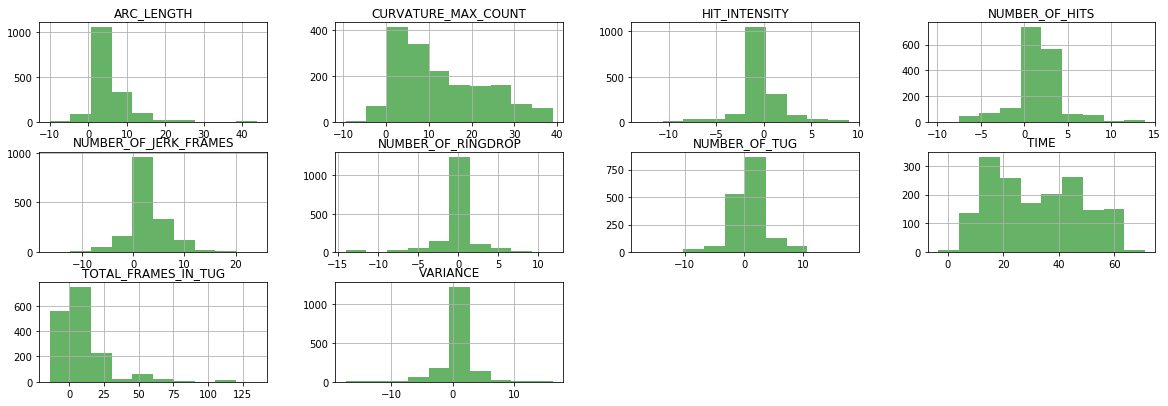

In [80]:
dataset["Hand-eye Coordination"][0].hist(color='g', alpha=0.6, bins=10, layout=(4,4), figsize=(20,9))

In [81]:
target.columns

Index(['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

# Noisy label Sampling

In [82]:
STD = 0.5 #hyperparameter

cols = ['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Overall']
for l_idx in cols:
    trainx = dataset[l_idx][0]
    trainy = dataset[l_idx][1]
    for idx in trainy.index:
        
        label_val = Y_train.loc[idx][l_idx]
        sample = np.random.normal(0, 1) #sample from N(0,1)
        trainy.loc[idx+"_noisy"] = sample*STD+label_val
        trainx.loc[idx+"_noisy"] = X_train.loc[idx]

In [83]:
dataset["Hand-eye Coordination"][0]

NUMBER_OF_HITS  HIT_INTENSITY  \
VIDEO                                                                       
E4_t9_aug_noise_pertub_X,perturb_Y               -4.880151       0.027837   
E1_t6_aug_noise_perturb_Y                        12.135445       6.388418   
E4_t12_aug_noise_standard_normalize               0.139704       5.756851   
E5_t1_aug_noise_norm_l1                           3.495123      -0.803074   
T3_2_t3_aug_norm_l2                               0.000000       0.000000   
T1_1_t11_aug_pertub_X,perturb_Y                   1.000000       0.000000   
E5_t1_aug_norm_l1                                 0.000000       0.000000   
T3_2_t7_aug_perturb_Y                             1.000000       0.000000   
E1_t2                                             0.000000       0.000000   
E5_t4                                             2.000000       0.000000   
T3_2_t12_aug_add_constant_X                       2.000000       0.000000   
T1_1_t11                                          1.000000       0.000000   
T3_2_t1_aug_noise_add_constant_Y                  1.188796      -2.310238   
E2_t7_aug_add_constant_Y                          2.000000       0.000000   
E2_t12_aug_pertub_X,perturb_Y                     0.000000       0.000000   
E2_t7_aug_noise_add_constant_Y                   11.223564      -5.563174   
T3_2_t3_aug_add_constant_Y                        0.000000       0.000000   
E5_t1_aug_noise_perturb_X                         0.234130       0.255881   
E1_t5_aug_pertub_X,perturb_Y                      1.000000       0.000000   
E2_t7_aug_add_constant_Y                          2.000000       0.000000   
E4_t9_aug_norm_l2                                 2.000000       0.000000   
E2_t7_aug_noise_add_constant_Y                   11.223564      -5.563174   
T3_2_t6_aug_add_constant_X                        3.000000       0.000000   
E4_t9                                             2.000000       0.000000   
E1_t4_aug_noise_replace_X,Y                       1.315009       4.839655   
T3_2_t4_aug_perturb_Y                             0.000000       0.000000   
E2_t12_aug_standard_normalize                     0.000000       0.000000   
T3_2_t10_aug_pertub_X,perturb_Y                   3.000000       0.000000   
E4_t12_aug_noise_pertub_X,perturb_Y               3.066315      -1.909726   
T1_1_t11_aug_add_constant_Y                       1.000000       0.000000   
...                                                    ...            ...   
T1_1_t5_aug_perturb_X_noisy                       0.000000       0.000000   
T1_1_t7_aug_noise_add_constant_Y_noisy            6.305122      -0.247866   
T1_1_t6_aug_pertub_X,perturb_Y_noisy              4.000000       0.000000   
T1_1_t5_aug_noise_replace_X,Y_noisy              -2.633963       0.539315   
T1_1_t6_aug_noise_perturb_X_noisy                -1.369605       0.958308   
T1_1_t7_noisy                                     2.000000       0.000000   
T1_1_t8_aug_noise_replace_X,Y_noisy               3.696644       2.540641   
T1_1_t9_aug_replace_X,Y_noisy                     1.000000       0.000000   
T1_1_t8_noisy                                     0.000000       0.000000   
T1_1_t6_aug_noise_pertub_X,perturb_Y_noisy        1.239416      -7.010559   
T1_1_t8_aug_noise_norm_l1_noisy                   7.872606       0.982960   
T1_1_t8_aug_noise_add_constant_Y_noisy           -2.071052       0.454530   
T1_1_t5_aug_standard_normalize_noisy              0.000000       0.000000   
T1_1_t6_noisy                                     4.000000       0.000000   
T1_1_t7_aug_standard_normalize_noisy              2.000000       0.000000   
T1_1_t8_aug_noise_perturb_X_noisy                 0.607343       2.307348   
T1_1_t8_aug_replace_X,Y_noisy                     0.000000       0.000000   
T1_1_t5_aug_noise_perturb_X_noisy                 2.494526       1.116621   
T1_1_t8_aug_standard_normalize_noisy              0.000000       0.000000   
T1_1_t9_noisy                           

In [84]:
dataset["Hand-eye Coordination"][1]

TARGET
VIDEO                                               
E4_t9_aug_noise_pertub_X,perturb_Y          3.000000
E1_t6_aug_noise_perturb_Y                   3.000000
E4_t12_aug_noise_standard_normalize         3.000000
E5_t1_aug_noise_norm_l1                     3.000000
T3_2_t3_aug_norm_l2                         3.000000
T1_1_t11_aug_pertub_X,perturb_Y             3.000000
E5_t1_aug_norm_l1                           3.000000
T3_2_t7_aug_perturb_Y                       3.000000
E1_t2                                       3.000000
E5_t4                                       3.000000
T3_2_t12_aug_add_constant_X                 3.000000
T1_1_t11                                    3.000000
T3_2_t1_aug_noise_add_constant_Y            3.000000
E2_t7_aug_add_constant_Y                    3.000000
E2_t12_aug_pertub_X,perturb_Y               3.000000
E2_t7_aug_noise_add_constant_Y              3.000000
T3_2_t3_aug_add_constant_Y                  3.000000
E5_t1_aug_noise_perturb_X                   3.000000
E1_t5_aug_pertub_X,perturb_Y                3.000000
E2_t7_aug_add_constant_Y                    3.000000
E4_t9_aug_norm_l2                           3.000000
E2_t7_aug_noise_add_constant_Y              3.000000
T3_2_t6_aug_add_constant_X                  3.000000
E4_t9                                       3.000000
E1_t4_aug_noise_replace_X,Y                 3.000000
T3_2_t4_aug_perturb_Y                       3.000000
E2_t12_aug_standard_normalize               3.000000
T3_2_t10_aug_pertub_X,perturb_Y             3.000000
E4_t12_aug_noise_pertub_X,perturb_Y         3.000000
T1_1_t11_aug_add_constant_Y                 3.000000
...                                              ...
T1_1_t5_aug_perturb_X_noisy                 0.909355
T1_1_t7_aug_noise_add_constant_Y_noisy      0.947687
T1_1_t6_aug_pertub_X,perturb_Y_noisy        0.908443
T1_1_t5_aug_noise_replace_X,Y_noisy         2.296056
T1_1_t6_aug_noise_perturb_X_noisy           0.773965
T1_1_t7_noisy                               1.036656
T1_1_t8_aug_noise_replace_X,Y_noisy         0.690961
T1_1_t9_aug_replace_X,Y_noisy               0.175580
T1_1_t8_noisy                               0.972968
T1_1_t6_aug_noise_pertub_X,perturb_Y_noisy  1.840301
T1_1_t8_aug_noise_norm_l1_noisy             0.991495
T1_1_t8_aug_noise_add_constant_Y_noisy      1.061809
T1_1_t5_aug_standard_normalize_noisy        2.193270
T1_1_t6_noisy                               1.287799
T1_1_t7_aug_standard_normalize_noisy        0.758113
T1_1_t8_aug_noise_perturb_X_noisy           0.623389
T1_1_t8_aug_replace_X,Y_noisy               0.423250
T1_1_t5_aug_noise_perturb_X_noisy           0.931200
T1_1_t8_aug_standard_normalize_noisy        0.924473
T1_1_t9_noisy                               1.092939
T1_1_t7_aug_replace_X,Y_noisy               1.161610
T1_1_t9_aug_pertub_X,perturb_Y_noisy        0.482398
T1_1_t8_aug_add_constant_Y_noisy            1.371951
T1_1_t9_aug_noise_norm_l1_noisy             0.019243
T1_1_t5_aug_noise_add_constant_X_noisy      0.654730
T1_1_t7_aug_noise_pertub_X,perturb_Y_noisy  1.463982
T1_1_t7_aug_pertub_X,perturb_Y_noisy        0.752710
T1_1_t9_aug_noise_replace_X,Y_noisy         1.587926
T1_1_t8_aug_noise_pertub_X,perturb_Y_noisy  1.994182
T1_1_t5_aug_norm_l1_noisy                   1.017520

[2462 rows x 1 columns]

In [85]:
# labels_gt

In [86]:
# labels_gt[0].value_counts()

In [87]:
X_test

NUMBER_OF_HITS  HIT_INTENSITY  NUMBER_OF_TUG  TOTAL_FRAMES_IN_TUG  \
VIDEO                                                                         
E6_t1                3.0            0.0            1.0                  2.0   
E6_t2                3.0            0.0            3.0                 58.0   
E6_t3                0.0            0.0            2.0                  3.0   
E6_t4                3.0            0.0            0.0                  0.0   
E6_t5                0.0            0.0            0.0                  0.0   
E6_t6                1.0            0.0            0.0                  0.0   
E6_t7                3.0            0.0            8.0                 13.0   
E6_t8                2.0            1.0           20.0                 33.0   
E6_t9                1.0            0.0            6.0                 34.0   
E6_t10               1.0            0.0            8.0                 12.0   
E6_t11               3.0            0.0            3.0                 44.0   
E6_t12               1.0            0.0            3.0                  6.0   
T8_1_t1              1.0            0.0            0.0                  0.0   
T8_1_t2              2.0            0.0            1.0                 21.0   
T8_1_t3              0.0            0.0            0.0                  0.0   
T8_1_t4              3.0            0.0            1.0                 17.0   
T8_1_t5              0.0            0.0            0.0                  0.0   
T8_1_t6              2.0            0.0            0.0                  0.0   
T8_1_t7              1.0            0.0            0.0                  0.0   
T8_1_t8              0.0            0.0            0.0                  0.0   
T8_1_t9              0.0            0.0            0.0                  0.0   
T8_1_t10             2.0            0.0            1.0                  4.0   
T8_1_t11             0.0            0.0            0.0                  0.0   
T8_1_t12             1.0            0.0            1.0                 23.0   

          NUMBER_OF_JERK_FRAMES   TIME  NUMBER_OF_RINGDROP  VARIANCE  \
VIDEO                                                                  
E6_t1                       0.0  29.00                 0.0  0.028333   
E6_t2                       3.0  30.00                 0.0  0.028916   
E6_t3                       0.0  21.72                 0.0  0.038643   
E6_t4                       6.0  30.60                 0.0  0.043718   
E6_t5                       1.0  24.84                 0.0  0.038487   
E6_t6                       1.0  22.84                 0.0  0.042202   
E6_t7                       9.0  37.76                 0.0  0.032234   
E6_t8                       3.0  30.84                 0.0  0.027167   
E6_t9                       0.0  28.84                 0.0  0.039825   
E6_t10                      0.0  25.00                 0.0  0.041824   
E6_t11                      1.0  28.56                 0.0  0.040181   
E6_t12                      1.0  28.76                 0.0  0.039875   
T8_1_t1                     1.0  42.00                 0.0  0.025030   
T8_1_t2                     0.0  53.76                 0.0  0.061870   
T8_1_t3                     0.0  29.00                 0.0  0.067421   
T8_1_t4                     3.0  32.72                 0.0  0.035629   
T8_1_t5                     3.0  26.60                 0.0  0.050109   
T8_1_t6                     0.0  27.72                 0.0  0.046199   
T8_1_t7                     8.0  22.84                 0.0  0.029021   
T8_1_t8                     0.0  25.84                 0.0  0.037335   
T8_1_t9                     4.0  22.84                 0.0  0.040169   
T8_1_t10                    0.0  23.84                 0.0  0.029878   
T8_1_t11                    2.0  25.84                 0.0  0.036832   
T8_1_t12                    2.0  29.92                 0.0  0.039068   

          ARC_LENGTH  CURVATURE_MAX_COUNT  
VIDEO                                 

In [88]:
# normalized_data_gt

2 approaches k fold : mean and std (Stability) or Val set find best hypermeters : Grid search

In [42]:
corMatrix_gt = pd.DataFrame.corr(X_train)

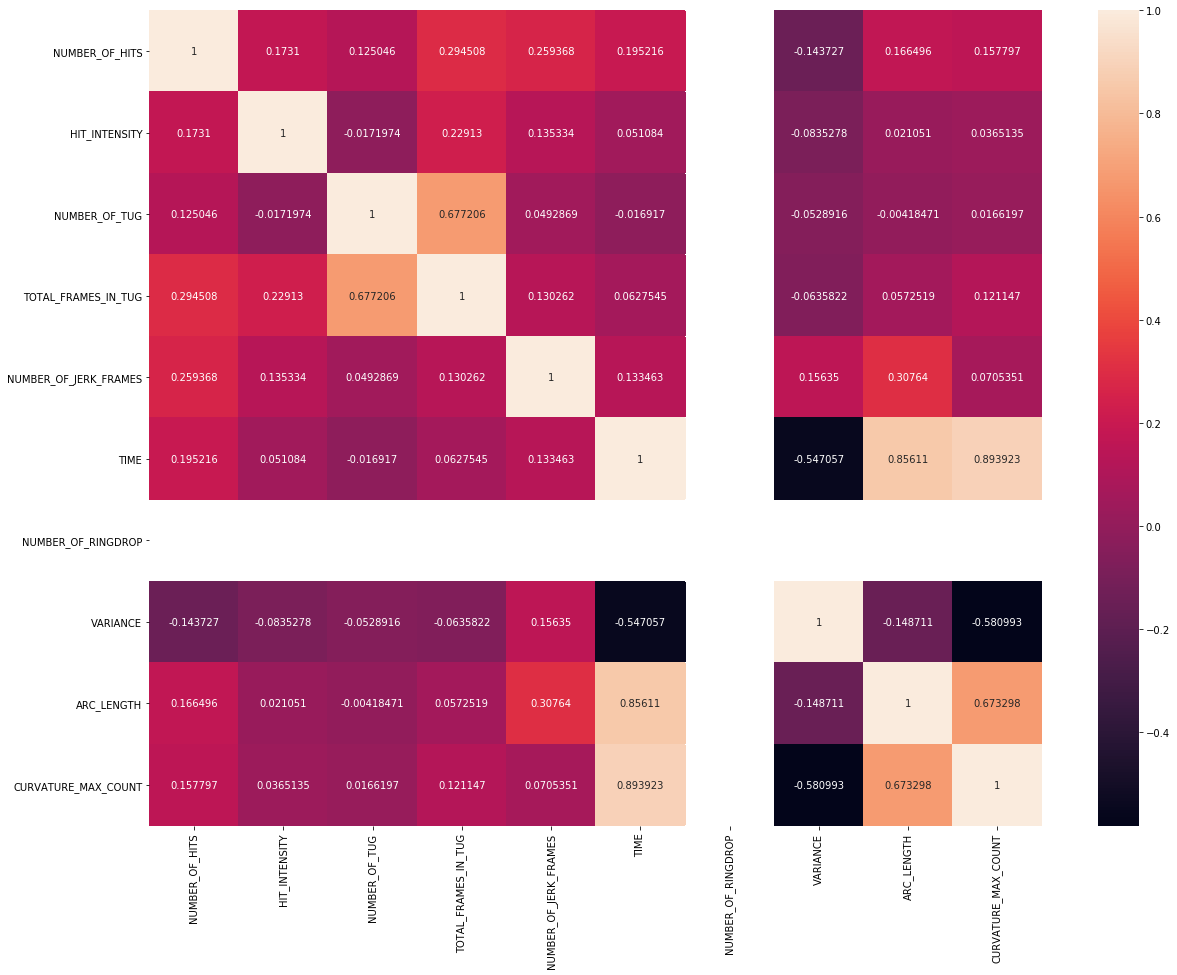

In [43]:
f, ax = plt.subplots(figsize=(20, 15))

ax = sn.heatmap(corMatrix_gt, annot=True, fmt='g')
plt.show()

# COVARIANCE

In [39]:
covarianceMatrix_gt = pd.DataFrame.cov(X_train)

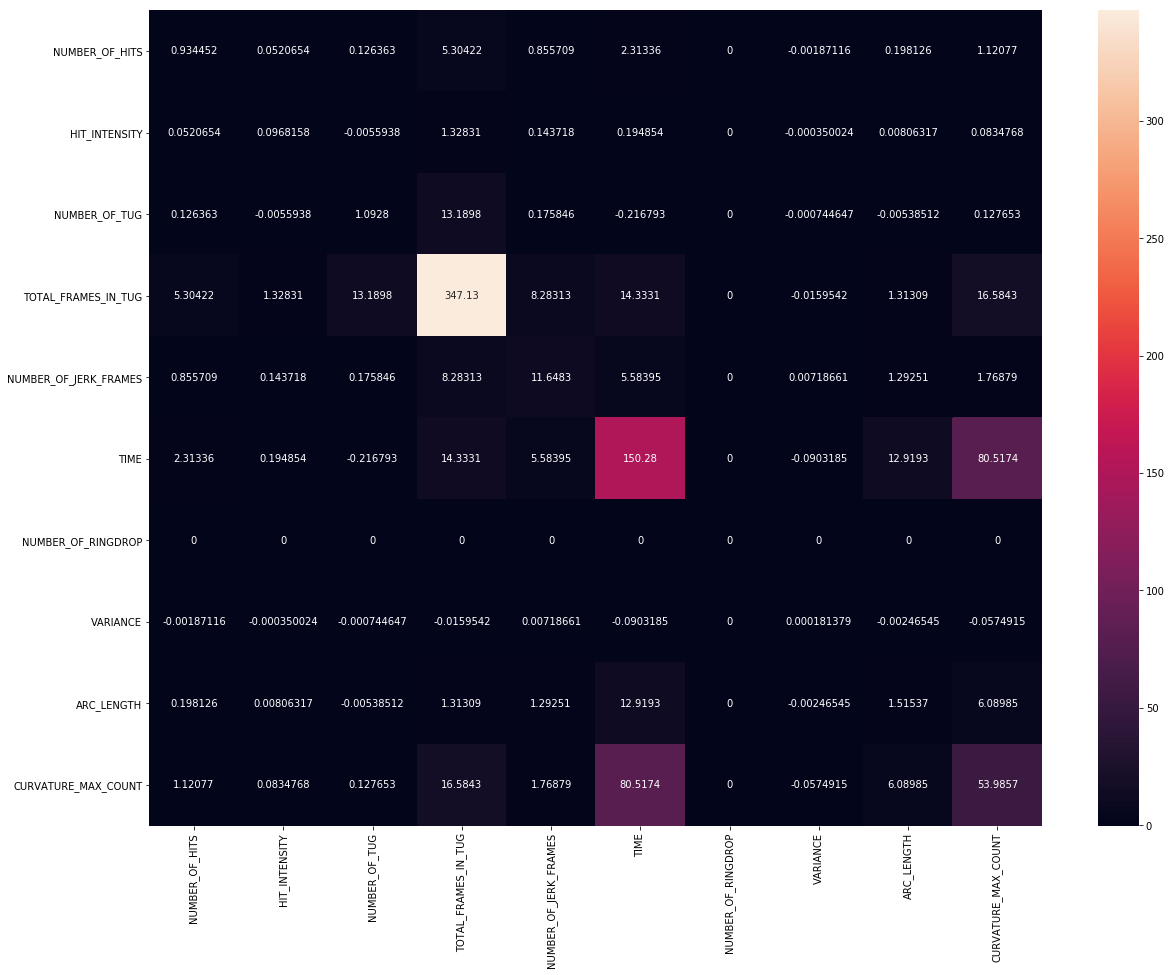

In [40]:
f, ax = plt.subplots(figsize=(20, 15))

ax = sn.heatmap(covarianceMatrix_gt, annot=True,fmt='g')
plt.show()

In [41]:
corr = data_gt.corr().abs()

s = corr.unstack()
sorted_values = s.sort_values(kind="quicksort")
df = sorted_values[sorted_values<1.0][::-1][::2].to_frame()
df

0
TIME                  CURVATURE_MAX_COUNT    0.885807
ARC_LENGTH            TIME                   0.835636
                      CURVATURE_MAX_COUNT    0.653348
CURVATURE_MAX_COUNT   VARIANCE               0.491017
VARIANCE              TIME                   0.489202
NUMBER_OF_TUG         TOTAL_FRAMES_IN_TUG    0.421663
NUMBER_OF_HITS        TOTAL_FRAMES_IN_TUG    0.339029
                      NUMBER_OF_JERK_FRAMES  0.257148
NUMBER_OF_JERK_FRAMES ARC_LENGTH             0.241502
HIT_INTENSITY         TOTAL_FRAMES_IN_TUG    0.233274
TIME                  NUMBER_OF_HITS         0.218737
HIT_INTENSITY         NUMBER_OF_TUG          0.209093
CURVATURE_MAX_COUNT   NUMBER_OF_HITS         0.188725
VARIANCE              NUMBER_OF_HITS         0.172409
NUMBER_OF_TUG         NUMBER_OF_HITS         0.168649
NUMBER_OF_HITS        ARC_LENGTH             0.164326
NUMBER_OF_TUG         VARIANCE               0.158542
HIT_INTENSITY         NUMBER_OF_HITS         0.154065
TOTAL_FRAMES_IN_TUG   CURVATURE_MAX_COUNT    0.140888
HIT_INTENSITY         NUMBER_OF_JERK_FRAMES  0.129858
TIME                  NUMBER_OF_JERK_FRAMES  0.114206
TOTAL_FRAMES_IN_TUG   NUMBER_OF_JERK_FRAMES  0.109354
VARIANCE              NUMBER_OF_JERK_FRAMES  0.097542
TIME                  NUMBER_OF_TUG          0.085344
TOTAL_FRAMES_IN_TUG   TIME                   0.084767
HIT_INTENSITY         VARIANCE               0.084226
TOTAL_FRAMES_IN_TUG   VARIANCE               0.079725
ARC_LENGTH            TOTAL_FRAMES_IN_TUG    0.065342
NUMBER_OF_TUG         CURVATURE_MAX_COUNT    0.063192
VARIANCE              ARC_LENGTH             0.058525
NUMBER_OF_TUG         NUMBER_OF_JERK_FRAMES  0.058222
CURVATURE_MAX_COUNT   NUMBER_OF_JERK_FRAMES  0.038930
NUMBER_OF_TUG         ARC_LENGTH             0.037864
HIT_INTENSITY         ARC_LENGTH             0.025048
                      TIME                   0.024785
CURVATURE_MAX_COUNT   HIT_INTENSITY          0.010034

# LEARNING BASED APPROACHES

In [94]:
from sklearn import svm
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.metrics import classification_report
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.pipeline import make_pipeline

In [95]:
Y_train.columns

Index(['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

In [144]:
# X, Y = dataset["Hand-eye Coordination"][0], dataset["Hand-eye Coordination"][1]

In [145]:
# X= X.reset_index()
# Y= Y.reset_index()
# X = X.drop(["VIDEO"], axis = 1)
# Y = Y.drop(["VIDEO"], axis = 1)
# idx = np.random.permutation(X.index)
# X= X.reindex(idx)
# Y= Y.reindex(idx)


In [104]:
Y_train.columns

Index(['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

In [197]:
parameter='Hand-eye Coordination'

In [198]:
X = X_train
Y = pd.DataFrame(Y_train[parameter])

In [199]:
# X

In [200]:
# Y

In [194]:
# X=X.append(X_test.tail())
# X=X.append(X_test.head())


In [195]:
# Y_H=Y_test.head()
# Y_T=Y_test.tail()

In [196]:
# Y=Y.append(pd.DataFrame(Y_H[parameter]))
# Y=Y.append(pd.DataFrame(Y_T[parameter]))


In [201]:
# normalized_data_gt=(data_gt-data_gt.min())/(data_gt.max()-data_gt.min())
#regressor = svm.SVR(kernel='rbf', epsilon=1)
# regressor = svm.NuSVR(kernel='rbf', nu=0.7)
# regressor = linear_model.SGDRegressor(max_iter=100000, tol=1e-3,verbose=1)
# regressor = make_pipeline(preprocessing.StandardScaler(),linear_model.SGDRegressor(alpha=0.0000001,max_iter=10000, tol=1e-3,verbose=1,penalty= 'elasticnet'))
regressor = RandomForestRegressor()
#regressor = DecisionTreeRegressor()

regressor.fit(X, Y)
print("r^2 Score", regressor.score(X, Y)) #r^2 for svm

Y_pred_train = regressor.predict(X)
print("Training MSE", mean_squared_error(Y_pred_train, Y))
print("Traning Correlation : ",pearsonr(Y_pred_train,Y.values.ravel())[0])

#print("Training Correlation : ",pearsonr(Y_pred_train, Y)[0])

Y_pred = regressor.predict(X_test)

print("Testing MSE : ",mean_squared_error(Y_pred, Y_test[parameter]))

print("Testing Correlation : ",pearsonr(Y_pred,Y_test[parameter])[0])


Y_pred_truncated = [round(x) for x in Y_pred] #rounding to nearest integer

for x,y,z in zip(Y_pred, Y_pred_truncated,Y_test[parameter]):
    print(x," ", y, " ", z)

print("MSE test truncated : ",mean_squared_error(Y_pred_truncated,  Y_test[parameter]))

Y_pred_train_truncated = [round(x) for x in Y_pred_train] #rounding to nearest integer
print("MSE train truncated : ",mean_squared_error(Y_pred_train_truncated,  Y))

print("Accuracy test : ", accuracy_score(Y_pred_truncated, Y_test[parameter]))

print("Accuracy train : ", accuracy_score(Y_pred_train_truncated, Y))

from sklearn.metrics import f1_score

print("F1-score-Macro_test: ", f1_score(Y_test[parameter], Y_pred_truncated, average='macro'))

print("F1-score-Macro_train: ", f1_score(Y, Y_pred_train_truncated, average='macro'))

print("F1-score-Micro_test: ", f1_score(Y_test[parameter], Y_pred_truncated, average='micro'))

print("F1-score-Micro_train: ", f1_score(Y, Y_pred_train_truncated, average='micro'))

print("F1-score-weighted_test: ", f1_score(Y_test[parameter], Y_pred_truncated, average='weighted'))

print("F1-score-weighted_train: ", f1_score(Y, Y_pred_train_truncated, average='weighted'))

print("F1-score-none_test: ", f1_score(Y_test[parameter], Y_pred_truncated, average=None))

print("F1-score-none_train: ", f1_score(Y, Y_pred_train_truncated, average=None))

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


r^2 Score 0.9299893088552916
Training MSE 0.04489605263157894
Traning Correlation :  0.9708118423515035
Testing MSE :  0.43903333333333333
Testing Correlation :  0.6244427664808845
2.08   2.0   1
3.46   3.0   4
2.23   2.0   2
1.87   2.0   2
3.09   3.0   2
3.36   3.0   3
3.18   3.0   3
2.99   3.0   3
2.3   2.0   2
3.46   3.0   4
2.09   2.0   2
3.07   3.0   3
3.39   3.0   3
3.56   4.0   3
3.76   4.0   4
1.95   2.0   4
3.36   3.0   4
3.78   4.0   3
3.79   4.0   4
3.56   4.0   3
3.33   3.0   4
3.39   3.0   3
3.36   3.0   4
3.39   3.0   3
MSE test truncated :  0.5833333333333334
MSE train truncated :  0.02631578947368421
Accuracy test :  0.5416666666666666
Accuracy train :  0.9736842105263158
F1-score-Macro_test:  0.41091517178473697
F1-score-Macro_train:  0.9188877043354655
F1-score-Micro_test:  0.5416666666666666
F1-score-Micro_train:  0.9736842105263158
F1-score-weighted_test:  0.5077024424850511
F1-score-weighted_train:  0.9748391501140911
F1-score-none_test:  [0.         0.72727273 0.6

In [189]:
regressor.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [134]:
from sklearn.decomposition import PCA

pca = PCA(2) # EXPLAINATION ?
X_train_vis = pca.fit_transform(X_test[['NUMBER_OF_HITS', 'HIT_INTENSITY']])
X_test_vis = pca.transform(X_test[['NUMBER_OF_HITS', 'HIT_INTENSITY']])

In [135]:
X_test[['NUMBER_OF_HITS', 'HIT_INTENSITY']]

NUMBER_OF_HITS  HIT_INTENSITY
VIDEO                                  
E6_t1                3.0            0.0
E6_t2                3.0            0.0
E6_t3                0.0            0.0
E6_t4                3.0            0.0
E6_t5                0.0            0.0
E6_t6                1.0            0.0
E6_t7                3.0            0.0
E6_t8                2.0            1.0
E6_t9                1.0            0.0
E6_t10               1.0            0.0
E6_t11               3.0            0.0
E6_t12               1.0            0.0
T8_1_t1              1.0            0.0
T8_1_t2              2.0            0.0
T8_1_t3              0.0            0.0
T8_1_t4              3.0            0.0
T8_1_t5              0.0            0.0
T8_1_t6              2.0            0.0
T8_1_t7              1.0            0.0
T8_1_t8              0.0            0.0
T8_1_t9              0.0            0.0
T8_1_t10             2.0            0.0
T8_1_t11             0.0            0.0
T8_1_t12             1.0            0.0

In [128]:
labels_gt.columns

Index(['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

ValueError: c of shape (24,) not acceptable as a color sequence for x with size 2462, y with size 2462

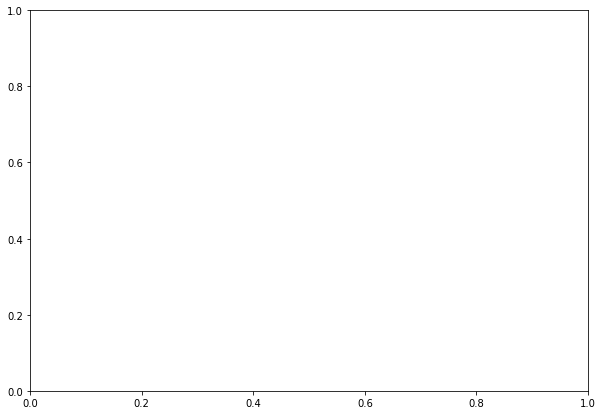

In [150]:
"""################### PCA 3d PLOT ##############################################"""

from mpl_toolkits import mplot3d 

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

fig = plt.figure(figsize = (10, 7)) 
# ax = plt.axes(projection ="3d") 

plt.scatter(X[['NUMBER_OF_HITS']], X[['HIT_INTENSITY']],  c=Y_test['Hand-eye Coordination'])

    # plot data
# ax.scatter3D(X_train_vis[:, 0], X_train_vis[:, 1],X_train_vis[:, 2], alpha=0.8, c=Y_test['Instrument-Tissue Manipulation'])
# for length, vector in zip(pca.explained_variance_, pca.components_):
#     v = vector * 3 * np.sqrt(length)
#     #draw_vector(pca.mean_, pca.mean_ + v)
# plt.axis('equal');


# Scaled

In [190]:
# normalized_data_gt=(data_gt-data_gt.min())/(data_gt.max()-data_gt.min())
regressor = svm.SVC()
def std_scaling(df):
#     scaler = preprocessing.StandardScaler()

    index = df.index
    # Get column names first
    names = df.columns
    # Create the Scaler object
    
    # Fit your data on the scaler object
    scaled_df = scale(df)
    normalized_data_gt = pd.DataFrame(scaled_df, columns=names, index= index)
    return normalized_data_gt

# regressor.fit(std_scaling(X), Y)
# Y_pred = regressor.predict(std_scaling(X_test))
# print("MSE : ",mean_squared_error(Y_pred,  pd.DataFrame(Y_test['Hand-eye Coordination'])))

# Y_pred_truncated = [round(x) for x in Y_pred] #rounding to nearest integer
# print("MSE truncated : ",mean_squared_error(Y_pred_truncated,  Y_test['Hand-eye Coordination']))

# print("Accuracy : ", accuracy_score(Y_pred_truncated, Y_test['Hand-eye Coordination']))

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MSE :  0.3745876058061726
MSE truncated :  0.5416666666666666
Accuracy :  0.5833333333333334


# Upsampled

In [202]:
# normalized_data_gt=(data_gt-data_gt.min())/(data_gt.max()-data_gt.min())
# regressor = svm.NuSVR()
# regressor = make_pipeline(preprocessing.StandardScaler(),linear_model.SGDRegressor(alpha=0.0000001,max_iter=10000, tol=1e-3,verbose=1,penalty= 'elasticnet'))

regressors = [
    KNeighborsRegressor(5),   
    #svm.SVR(),
    #svm.NuSVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor() 
]

params_regressors = [
    {"n_neighbors":[3,4,5], "algorithm" :["auto", "ball_tree", "kd_tree", "brute"]},
    #{'kernel': ['linear', 'rbf'],'C': [1, 10]}, #svc
    #{'kernel': ['linear', 'rbf'], 'C': [ 1, 10], 'nu':[0.3,0.5,0.7,0.9]}, #linear kernel svc
    {"max_depth": [4,5,6,7,8],"splitter":["best", "random"]}, #decision tree
    {"max_depth":[4,5,6,7,8], "n_estimators":[10,20], "max_features":[1,2,5]}, #Random forest
]


X_upsampled_train, Y_upsampled_train = X, Y #dataset['Hand-eye Coordination']

results = []
for i in range(len(regressors)):
    res={}
    clf = GridSearchCV(regressors[i], params_regressors[i],scoring=make_scorer(mean_squared_error), cv=5)
                                                        #make_scorer(label_ranking_loss)
    clf.fit(X_upsampled_train, Y_upsampled_train.values.ravel())

    Y_pred = clf.predict(X_test) #y_pred
#     Y_pred = [round(x) for x in Y_pred] #rounding to nearest integer

    r = pearsonr(Y_pred, Y_test['Hand-eye Coordination'].values.ravel())

    res["estimator"] = clf.best_estimator_
    res["Estimatior_Type"] = params_regressors[i].__class__.__name__ #res["parameter_search_dict"] = clf.best_params_
    res["Testing_MSE"] = mean_squared_error(Y_pred, Y_test['Hand-eye Coordination'].values.ravel()) #ypred vs gt y for test data
    res["Testing_Correlation"] = r[0]
    res["Training_MSE"] = clf.best_score_
                 
    print(res)
    results.append(res)
                
# regressor.fit(X_upsampled_train, Y_upsampled_train)
# Y_pred = regressor.predict(X_test)
# print("MSE : ",mean_squared_error(Y_pred,  Y_test['Hand-eye Coordination']))
# print("Correlation : ",pearsonr(Y_pred,Y_test['Hand-eye Coordination'])[0])


# Y_pred_truncated = [round(x) for x in Y_pred] #rounding to nearest integer
# print("MSE truncated : ",mean_squared_error(Y_pred_truncated,  Y_test['Hand-eye Coordination']))

# print("Accuracy : ", accuracy_score(Y_pred_truncated, Y_test['Hand-eye Coordination']))


{'estimator': KNeighborsRegressor(), 'Estimatior_Type': 'dict', 'Testing_MSE': 0.49833333333333335, 'Testing_Correlation': 0.5708145393463959, 'Training_MSE': 0.4087666666666667}
{'estimator': DecisionTreeRegressor(max_depth=7, splitter='random'), 'Estimatior_Type': 'dict', 'Testing_MSE': 0.577277970011534, 'Testing_Correlation': 0.6112174582010449, 'Training_MSE': 0.6791544656271288}
{'estimator': RandomForestRegressor(max_depth=4, max_features=1, n_estimators=10), 'Estimatior_Type': 'dict', 'Testing_MSE': 0.4258387880262233, 'Testing_Correlation': 0.6634004421048395, 'Training_MSE': 0.3914351805307366}


In [203]:
pd.DataFrame(results)

Estimatior_Type  Testing_Correlation  Testing_MSE  Training_MSE  \
0            dict             0.570815     0.498333      0.408767   
1            dict             0.611217     0.577278      0.679154   
2            dict             0.663400     0.425839      0.391435   

                                           estimator  
0                              KNeighborsRegressor()  
1  DecisionTreeRegressor(max_depth=7, splitter='r...  
2  (DecisionTreeRegressor(max_depth=4, max_featur...

In [71]:
labels_gt.columns

Index(['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

In [254]:
# normalized_data_gt=(data_gt-data_gt.min())/(data_gt.max()-data_gt.min())
# regressor = svm.NuSVR()
# regressor = make_pipeline(preprocessing.StandardScaler(),linear_model.SGDRegressor(alpha=0.0000001,max_iter=10000, tol=1e-3,verbose=1,penalty= 'elasticnet'))

regressors = [
    KNeighborsRegressor(5),   
    svm.SVR(),
    svm.NuSVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor() 
]

params_regressors = [
    {"n_neighbors":[3,4,5], "algorithm" :["auto", "ball_tree", "kd_tree", "brute"]},
    {'kernel': ['linear', 'rbf'],'C': [1, 10]}, #svc
    {'kernel': ['linear', 'rbf'], 'C': [ 1, 10], 'nu':[0.3,0.5,0.7,0.9]}, #linear kernel svc
    {"max_depth": [4,5,6,7,8],"splitter":["best", "random"]}, #decision tree
    {"max_depth":[4,5,6,7,8], "n_estimators":[10,20], "max_features":[1,2,5]}, #Random forest
]


X_upsampled_train, Y_upsampled_train = dataset['Instrument-Tissue Manipulation']

results_ITM = []
for i in range(len(regressors)):
    res={}
    clf = GridSearchCV(regressors[i], params_regressors[i],scoring=make_scorer(mean_squared_error), cv=5)
                                                        #make_scorer(label_ranking_loss)
    clf.fit(X_upsampled_train, Y_upsampled_train.values.ravel())

    Y_pred = clf.predict(X_test) #y_pred
#     Y_pred = [round(x) for x in Y_pred] #rounding to nearest integer

    r = pearsonr(Y_pred, Y_test['Instrument-Tissue Manipulation'].values.ravel())

    res["estimator"] = clf.best_estimator_
    res["Estimatior_Type"] = params_regressors[i].__class__.__name__ #res["parameter_search_dict"] = clf.best_params_
    res["Testing_MSE"] = mean_squared_error(Y_pred, Y_test['Instrument-Tissue Manipulation'].values.ravel()) #ypred vs gt y for test data
    res["Testing_Correlation"] = r[0]
    res["Training_MSE"] = clf.best_score_
                 
    print(res)
    results_ITM.append(res)
                
# regressor.fit(X_upsampled_train, Y_upsampled_train)
# Y_pred = regressor.predict(X_test)
# print("MSE : ",mean_squared_error(Y_pred,  Y_test['Hand-eye Coordination']))
# print("Correlation : ",pearsonr(Y_pred,Y_test['Hand-eye Coordination'])[0])


# Y_pred_truncated = [round(x) for x in Y_pred] #rounding to nearest integer
# print("MSE truncated : ",mean_squared_error(Y_pred_truncated,  Y_test['Hand-eye Coordination']))

# print("Accuracy : ", accuracy_score(Y_pred_truncated, Y_test['Hand-eye Coordination']))


{'estimator': KNeighborsRegressor(), 'Estimatior_Type': 'dict', 'Testing_MSE': 0.40833333333333327, 'Testing_Correlation': 0.3936481072421527, 'Training_MSE': 0.5825968253968254}
{'estimator': SVR(C=10, kernel='linear'), 'Estimatior_Type': 'dict', 'Testing_MSE': 1.757976419171363, 'Testing_Correlation': 0.04967808171886469, 'Training_MSE': 1.5326455221120525}
{'estimator': NuSVR(C=10, kernel='linear'), 'Estimatior_Type': 'dict', 'Testing_MSE': 0.852604413188852, 'Testing_Correlation': 0.18085965336855195, 'Training_MSE': 1.6135025198263366}
{'estimator': DecisionTreeRegressor(max_depth=4, splitter='random'), 'Estimatior_Type': 'dict', 'Testing_MSE': 1.10158457424619, 'Testing_Correlation': 0.051108793436323456, 'Training_MSE': 0.746316421198183}
{'estimator': RandomForestRegressor(max_depth=5, max_features=1, n_estimators=10), 'Estimatior_Type': 'dict', 'Testing_MSE': 0.25442658731530116, 'Testing_Correlation': 0.47507655648171393, 'Training_MSE': 0.6436952622625806}


In [255]:
results_ITM

[{'estimator': KNeighborsRegressor(),
  'Estimatior_Type': 'dict',
  'Testing_MSE': 0.40833333333333327,
  'Testing_Correlation': 0.3936481072421527,
  'Training_MSE': 0.5825968253968254},
 {'estimator': SVR(C=10, kernel='linear'),
  'Estimatior_Type': 'dict',
  'Testing_MSE': 1.757976419171363,
  'Testing_Correlation': 0.04967808171886469,
  'Training_MSE': 1.5326455221120525},
 {'estimator': NuSVR(C=10, kernel='linear'),
  'Estimatior_Type': 'dict',
  'Testing_MSE': 0.852604413188852,
  'Testing_Correlation': 0.18085965336855195,
  'Training_MSE': 1.6135025198263366},
 {'estimator': DecisionTreeRegressor(max_depth=4, splitter='random'),
  'Estimatior_Type': 'dict',
  'Testing_MSE': 1.10158457424619,
  'Testing_Correlation': 0.051108793436323456,
  'Training_MSE': 0.746316421198183},
 {'estimator': RandomForestRegressor(max_depth=5, max_features=1, n_estimators=10),
  'Estimatior_Type': 'dict',
  'Testing_MSE': 0.25442658731530116,
  'Testing_Correlation': 0.47507655648171393,
  'Trai

In [28]:
regressor.fit_status_

0

In [ ]:
from sklearn.neural_network import MLPRegressor
X_upsampled_train, Y_upsampled_train = dataset['Hand-eye Coordination']

mlp = MLPRegressor(max_iter=5000)

parameter_space = {
    'hidden_layer_sizes': [(64,32,16,8,4), (20), (100,10,100,10)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_upsampled_train,Y_upsampled_train)

Y_train_pred = clf.predict(X_upsampled_train)
Y_pred = clf.predict(X_test)

In [ ]:
clf.best_estimator_

In [ ]:
clf.get_params(deep=True)

In [ ]:
print(mean_squared_error(Y_train_pred, Y_upsampled_train.values.ravel())) #ypred vs gt y for test data

In [ ]:
# Y_pred = [round(x) for x in Y_pred]

In [ ]:
Y_test['Hand-eye Coordination']

In [ ]:
Y_pred

In [ ]:
print(mean_squared_error(Y_pred, Y_test['Hand-eye Coordination'].values.ravel())) #ypred vs gt y for test data


In [ ]:
clf.score(X_test,Y_test['Hand-eye Coordination'])

In [229]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1, l2

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=10, activation='relu', activity_regularizer=l1(0.0001), kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='relu', activity_regularizer=l1(0.0001), kernel_regularizer=l2(0.001)))
    model.add(Dense(1))
    # Compile model
    
#   opt = keras.optimizers.Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    model.compile(loss='mean_squared_error', optimizer="adam", metrics=['mae']) #
    return model
 
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [230]:
X_upsampled_train, Y_upsampled_train = dataset['Hand-eye Coordination']

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# create model
model = KerasClassifier(build_fn=create_model, epochs=1000, batch_size=4, verbose=1, callbacks=[es])
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
history = model.fit(std_scaling(X_upsampled_train), std_scaling(Y_upsampled_train), validation_split=0.2, shuffle=True)


# print(results.mean())

Train on 124 samples, validate on 32 samples
Epoch 1/1000
124/124 [==============================] - 6s 47ms/step - loss: 3.4742 - mean_absolute_error: 1.6520 - val_loss: 0.7983 - val_mean_absolute_error: 0.7655
Epoch 2/1000
124/124 [==============================] - 0s 1ms/step - loss: 2.2206 - mean_absolute_error: 1.2659 - val_loss: 0.5133 - val_mean_absolute_error: 0.6171
Epoch 3/1000
124/124 [==============================] - 0s 1ms/step - loss: 1.6562 - mean_absolute_error: 0.9979 - val_loss: 0.4748 - val_mean_absolute_error: 0.5204
Epoch 4/1000
124/124 [==============================] - 0s 1ms/step - loss: 1.2826 - mean_absolute_error: 0.8643 - val_loss: 0.5597 - val_mean_absolute_error: 0.5436
Epoch 00004: early stopping


dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


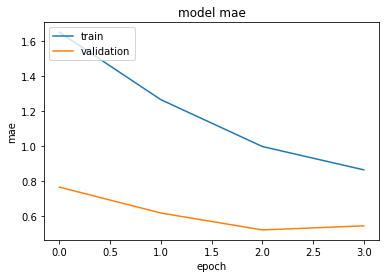

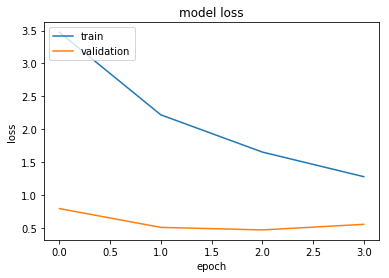

In [240]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [232]:
Y_pred = model.predict(std_scaling(X_test))

24/24 [==============================] - 2s 86ms/step


In [233]:
Y_pred

array([[-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ],
       [-1.34164079],
       [-0.4472136 ],
       [-0.4472136 ],
       [-1.34164079],
       [-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ],
       [-1.34164079],
       [-1.34164079],
       [-0.4472136 ],
       [-1.34164079],
       [-0.4472136 ],
       [-0.4472136 ],
       [-1.34164079],
       [-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ]])

In [234]:
scale(Y_test["Hand-eye Coordination"].values.ravel())

array([-0.06819943, -0.06819943,  1.56858698, -0.06819943,  1.56858698,
       -0.06819943, -0.06819943,  1.56858698, -0.06819943,  1.56858698,
       -0.06819943,  1.56858698, -1.70498585, -1.70498585, -1.70498585,
       -1.70498585, -0.06819943, -0.06819943, -0.06819943, -0.06819943,
       -0.06819943, -0.06819943, -0.06819943, -0.06819943])

In [235]:
mean_squared_error(Y_pred,scale(Y_test["Hand-eye Coordination"].values.ravel()))

1.203503717135228

In [236]:
pearsonr(Y_pred.flatten(),scale(Y_test["Hand-eye Coordination"].values.ravel()))[0]

0.5118745001228026

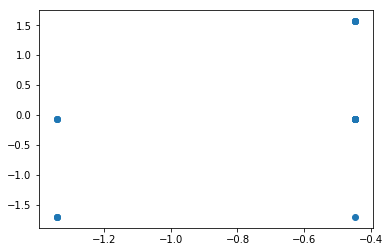

In [237]:
plt.scatter(Y_pred,scale(Y_test["Hand-eye Coordination"].values.ravel()))

In [302]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
 "Decision Tree", "Random Forest"] # "Neural Net", "Gaussian Process", "AdaBoost", "Naive Bayes", "QDA"]

ranking_classifiers =  [
    KNeighborsClassifier(),
#     LinearSVC( multi_class="crammer_singer"),
    DecisionTreeClassifier(),
    GaussianNB()
]

params_ranking_classifiers = [
    {"n_neighbors":[3,4,5], "algorithm" :["auto", "ball_tree", "kd_tree", "brute"]},
#     {'C': [0.025, 0.25, 1, 10, 100, 1000]}, #linear kernel svc
    {"max_depth": [4,5,6,7,8],"splitter":["best", "random"]}, #decision tree
]

classifiers = [
    KNeighborsClassifier(),
    SVC(), #gamma=2, C=1
    SVC(), #kernel="linear", C=0.025
    DecisionTreeClassifier(),
    RandomForestClassifier()]

params_classifiers = [
    {"n_neighbors":[3,4,5], "algorithm" :["auto", "ball_tree", "kd_tree", "brute"]},
    #{"n_neighbors":[3], "algorithm" :["auto"]},
    {'kernel': ['rbf'], 'gamma': [1,1e-1, 1e-2, 1e-3, 1e-4],'C': [1, 10, 100, 1000]}, #svc
    {'kernel': ['linear'], 'C': [0.025, 0.25, 1, 10, 100, 1000]}, #linear kernel svc
    {"max_depth": [4,5,6,7,8],"splitter":["best", "random"]}, #decision tree
    {"max_depth":[4,5,6,7,8], "n_estimators":[10,20], "max_features":[1,2,5]}, #Random forest
]

names_reg = [ "Nearest Neighbors Regressor", "Linear SVR Regressor", "RBF SVR",
         "Decision Tree Regressor", "Random Forest Regressor"]# "Neural Net Regressor",  "Gaussian Process Regressor", "AdaBoost Regressor"]


regressors = [
    KNeighborsRegressor(5),   
    SVR(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor() 
]

params_regressors = [
    {"n_neighbors":[3,4,5], "algorithm" :["auto", "ball_tree", "kd_tree", "brute"]},
    {'kernel': ['rbf'], 'gamma': [1,1e-1, 1e-2, 1e-3, 1e-4],'C': [1, 10, 100, 1000]}, #svc
    {'kernel': ['linear'], 'C': [0.025, 0.25, 1, 10, 100, 1000]}, #linear kernel svc
    {"max_depth": [4,5,6,7,8],"splitter":["best", "random"]}, #decision tree
    {"max_depth":[4,5,6,7,8], "n_estimators":[10,20], "max_features":[1,2,5]}, #Random forest
]


In [307]:
class Trainer:
    
    def __init__(self, augmentations=False):
        self.aug = augmentations
          

    def run(self, X_train, Y_train, X_test, Y_test, classifiers, params, names, prediction_label = None, method = "classify", split_size = 0.20, k_folds = 5,digitize = False):
        
        results = []
        
        if  digitize: #for overall scores
            Y_train = np.digitize(np.array(Y_train),np.array([5.0, 10.0, 15.0, 20.0]))
       
        for parameters, model in zip(params, classifiers):
                print(prediction_label,model)
                res = {}
                if method == "classify":
                    clf = GridSearchCV(model, parameters, scoring="accuracy",cv=k_folds)
                                                        #make_scorer(label_ranking_loss)
                    clf.fit(X_train, Y_train.values.ravel())
                    
                    Y_pred = clf.predict(X_test) #y_pred
                   
                    print(classification_report(Y_pred, Y_test.values.ravel()))
                    r = pearsonr(Y_pred, Y_test.values.ravel())
                    
                    res["estimator"] = clf.best_estimator_
                    res["Estimatior_Type"] = model.__class__.__name__ #res["parameter_search_dict"] = clf.best_params_
                    res["Testing_Accuracy"] = accuracy_score(Y_pred, Y_test.values.ravel())
                    res["Testing_Correlation"] = r[0]
                    res["Training_Accuracy"] = clf.best_score_
                    
                    results.append(res)

                elif method == "regression":
                    clf = GridSearchCV(model, parameters,scoring=make_scorer(mean_squared_error), cv=k_folds)
                                                        #make_scorer(label_ranking_loss)
                    clf.fit(X_train, Y_train.values.ravel())
                    
                    Y_pred = clf.predict(X_test) #y_pred
                    Y_pred = [round(x) for x in Y_pred] #rounding to nearest integer
                    
                    r = pearsonr(Y_pred, Y_test.values.ravel())

                    res["estimator"] = clf.best_estimator_
                    res["Estimatior_Type"] = model.__class__.__name__ #res["parameter_search_dict"] = clf.best_params_
                    res["Testing_MSE"] = mean_squared_error(Y_pred, Y_test.values.ravel()) #ypred vs gt y for test data
                    res["Testing_Correlation"] = r[0]
                    res["Training_MSE"] = clf.best_score_
                    
                    results.append(res)
                
                elif method == "ranking":
                    clf = GridSearchCV(model, parameters,scoring=make_scorer(label_ranking_loss), cv=k_folds)
                                                        
                    clf.fit(X_train, Y_train)
                    Y_test = Y_test[['1','2','3','4']]
                    Y_pred = pd.DataFrame(clf.predict(X_test), columns = ["1","2","3","4"]) #y_pred
                    print(Y_pred.columns)
                    print(Y_test.columns)

                    res["estimator"] = clf.best_estimator_
                    res["Estimatior_Type"] = model.__class__.__name__ #res["parameter_search_dict"] = clf.best_params_
                    res["Testing_Ranking"] = label_ranking_loss(Y_pred, Y_test) #ypred vs gt y for test data
                    res["Training_Ranking"] = clf.best_score_
                    
                    results.append(res)
                    
                    
                    
        return results

In [308]:
trainer = Trainer()

In [309]:
preds = ['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity','Flow of procedure', 'Overall']#'Effectualness'

In [310]:
ranking_classifiers

[KNeighborsClassifier(), DecisionTreeClassifier(), GaussianNB()]

In [311]:
classifiers

[KNeighborsClassifier(),
 SVC(),
 SVC(),
 DecisionTreeClassifier(),
 RandomForestClassifier()]

In [312]:
regressors

[KNeighborsRegressor(),
 SVR(),
 SVR(),
 DecisionTreeRegressor(),
 RandomForestRegressor()]

In [313]:
# Without upsampling
res_classifier = {}
for p in preds:
    X_train, Y_train = dataset[p]
    res_classifier[p]=trainer.run( X_train, Y_train, X_test, Y_test[p],classifiers,params_classifiers, names, p,split_size = 0.3)

Hand-eye Coordination KNeighborsClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.25      0.33      0.29         3
           3       0.40      0.60      0.48        10
           4       0.20      0.14      0.17         7

    accuracy                           0.33        24
   macro avg       0.21      0.27      0.23        24
weighted avg       0.26      0.33      0.28        24

Hand-eye Coordination SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.80      0.67      0.73        18
           4       0.20      0.20      0.20         5

    accuracy                           0.54        24
   macro avg       0.25      0.22      0.23        24
weighted avg       0.64      0.54      0.59        24

Hand-eye Coordination SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.25      0.20      0.22         5
           3       0.73      0.73      0.73        15
           4       0.00      0.00      0.00         2

    accuracy                           0.50        24
   macro avg       0.25      0.23      0.24        24
weighted avg       0.51      0.50      0.50        24

Hand-eye Coordination DecisionTreeClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.47      0.78      0.58         9
           4       0.60      0.30      0.40        10

    accuracy                           0.42        24
   macro avg       0.27      0.27      0.25        24
weighted avg       0.42      0.42      0.39        24

Hand-eye Coordination RandomForestClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         6
           3       0.40      0.75      0.52         8
           4       0.40      0.29      0.33         7

    accuracy                           0.33        24
   macro avg       0.20      0.26      0.21        24
weighted avg       0.25      0.33      0.27        24

Instrument-Tissue Manipulation KNeighborsClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.50      0.33      0.40         6
           3       0.29      0.56      0.38         9
           4       0.33      0.17      0.22         6

    accuracy                           0.33        24
   macro avg       0.28      0.26      0.25        24
weighted avg       0.32      0.33      0.30        24

Instrument-Tissue Manipulation SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.88      0.68      0.77        22
           4       0.00      0.00      0.00         1

    accuracy                           0.62        24
   macro avg       0.22      0.17      0.19        24
weighted avg       0.81      0.62      0.71        24

Instrument-Tissue Manipulation SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.50      0.25      0.33         8
           3       0.24      0.50      0.32         8
           4       0.33      0.20      0.25         5

    accuracy                           0.29        24
   macro avg       0.27      0.24      0.23        24
weighted avg       0.31      0.29      0.27        24

Instrument-Tissue Manipulation DecisionTreeClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         2
           3       0.35      0.50      0.41        12
           4       0.00      0.00      0.00         5

    accuracy                           0.25        24
   macro avg       0.09      0.12      0.10        24
weighted avg       0.18      0.25      0.21        24

Instrument-Tissue Manipulation RandomForestClassifier()
              precision    recall  f1-score   support

           2       0.50      0.22      0.31         9
           3       0.24      0.44      0.31         9
           4       0.00      0.00      0.00         6

    accuracy                           0.25        24
   macro avg       0.25      0.22      0.21        24
weighted avg       0.28      0.25      0.23        24

Dexterity KNeighborsClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         7
           3       0.29      0.50      0.36         8
           4       0.38      0.50      0.43         6

    accuracy                           0.29        24
   macro avg       0.17      0.25      0.20        24
weighted avg       0.19      0.29      0.23        24

Dexterity SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.50      0.14      0.22         7
           3       0.29      0.50      0.36         8
           4       0.12      0.14      0.13         7

    accuracy                           0.25        24
   macro avg       0.23      0.20      0.18        24
weighted avg       0.28      0.25      0.22        24

Dexterity SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         6
           3       0.64      0.90      0.75        10
           4       0.25      1.00      0.40         2

    accuracy                           0.46        24
   macro avg       0.22      0.47      0.29        24
weighted avg       0.29      0.46      0.35        24

Dexterity DecisionTreeClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         8
           3       0.29      0.80      0.42         5
           4       0.50      0.44      0.47         9

    accuracy                           0.33        24
   macro avg       0.20      0.31      0.22        24
weighted avg       0.25      0.33      0.26        24

Dexterity RandomForestClassifier()
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.64      0.56      0.60        16
           4       0.38      0.50      0.43         6

    accuracy                           0.50        24
   macro avg       0.34      0.35      0.34        24
weighted avg       0.52      0.50      0.51        24

Flow of procedure KNeighborsClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           2       0.00      0.00      0.00         8
           3       0.11      0.33      0.17         3
           4       0.47      0.54      0.50        13

    accuracy                           0.33        24
   macro avg       0.19      0.29      0.22        24
weighted avg       0.27      0.33      0.29        24

Flow of procedure SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.87      0.59      0.70        22

    accuracy                           0.54        24
   macro avg       0.29      0.20      0.23        24
weighted avg       0.79      0.54      0.64        24

Flow of procedure SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         3
           3       0.44      0.50      0.47         8
           4       0.40      0.60      0.48        10

    accuracy                           0.42        24
   macro avg       0.21      0.28      0.24        24
weighted avg       0.31      0.42      0.36        24

Flow of procedure DecisionTreeClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.44      0.67      0.53         6
           4       0.73      0.79      0.76        14

    accuracy                           0.62        24
   macro avg       0.29      0.36      0.32        24
weighted avg       0.54      0.62      0.58        24

Flow of procedure RandomForestClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.33      0.50      0.40         6
           4       0.73      0.65      0.69        17

    accuracy                           0.58        24
   macro avg       0.36      0.38      0.36        24
weighted avg       0.60      0.58      0.59        24

Overall KNeighborsClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           7       0.00      0.00      0.00         2
          10       0.50      0.20      0.29         5
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         3
          18       0.25      0.33      0.29         3
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1

    accuracy                           0.08        24
   macro avg       0.06      0.04      0.05        24
weighted avg       0.14      0.08      0.10        24

Overall SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           7       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00        18
          18       0.25      0.50      0.33         2
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         2

    accuracy                           0.04        24
   macro avg       0.02      0.04      0.03        24
weighted avg       0.02      0.04      0.03        24

Overall SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
          10       0.50      0.33      0.40         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         5
          18       0.00      0.00      0.00         3
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         1

    accuracy                           0.04        24
   macro avg       0.04      0.03      0.03        24
weighted avg       0.06      0.04      0.05        24

Overall DecisionTreeClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           7       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       3.0
          12       0.00      0.00      0.00       3.0
          13       0.00      0.00      0.00       0.0
          14       0.00      0.00      0.00       2.0
          15       0.00      0.00      0.00       4.0
          16       0.00      0.00      0.00      12.0
          18       0.00      0.00      0.00       0.0
          19       0.00      0.00      0.00       0.0
          20       0.00      0.00      0.00       0.0

    accuracy                           0.00      24.0
   macro avg       0.00      0.00      0.00      24.0
weighted avg       0.00      0.00      0.00      24.0

Overall RandomForestClassifier()
              precision    recall  f1-score   support

           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00  

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [314]:
res_classifier

{'Hand-eye Coordination': [{'estimator': KNeighborsClassifier(n_neighbors=3),
   'Estimatior_Type': 'KNeighborsClassifier',
   'Testing_Accuracy': 0.3333333333333333,
   'Testing_Correlation': 0.34296568195131133,
   'Training_Accuracy': 0.7877016129032259},
  {'estimator': SVC(C=10, gamma=1),
   'Estimatior_Type': 'SVC',
   'Testing_Accuracy': 0.5416666666666666,
   'Testing_Correlation': 0.21330847512739132,
   'Training_Accuracy': 0.8199596774193549},
  {'estimator': SVC(C=1000, kernel='linear'),
   'Estimatior_Type': 'SVC',
   'Testing_Accuracy': 0.5,
   'Testing_Correlation': -0.25137028189427374,
   'Training_Accuracy': 0.8141129032258064},
  {'estimator': DecisionTreeClassifier(max_depth=8),
   'Estimatior_Type': 'DecisionTreeClassifier',
   'Testing_Accuracy': 0.4166666666666667,
   'Testing_Correlation': 0.35864438209992827,
   'Training_Accuracy': 0.8330645161290324},
  {'estimator': RandomForestClassifier(max_depth=8, max_features=2, n_estimators=10),
   'Estimatior_Type': '

In [315]:
result = {}
for key, val in res_classifier.items():
    df = pd.DataFrame(val)
    df["Metric"] = key
    result[key]= df

In [316]:
data = pd.concat(result)

In [317]:
data

Estimatior_Type  Testing_Accuracy  \
Dexterity                      0    KNeighborsClassifier          0.291667   
                               1                     SVC          0.250000   
                               2                     SVC          0.458333   
                               3  DecisionTreeClassifier          0.333333   
                               4  RandomForestClassifier          0.500000   
Flow of procedure              0    KNeighborsClassifier          0.333333   
                               1                     SVC          0.541667   
                               2                     SVC          0.416667   
                               3  DecisionTreeClassifier          0.625000   
                               4  RandomForestClassifier          0.583333   
Hand-eye Coordination          0    KNeighborsClassifier          0.333333   
                               1                     SVC          0.541667   
                               2                     SVC          0.500000   
                               3  DecisionTreeClassifier          0.416667   
                               4  RandomForestClassifier          0.333333   
Instrument-Tissue Manipulation 0    KNeighborsClassifier          0.333333   
                               1                     SVC          0.625000   
                               2                     SVC          0.291667   
                               3  DecisionTreeClassifier          0.250000   
                               4  RandomForestClassifier          0.250000   
Overall                        0    KNeighborsClassifier          0.083333   
                               1                     SVC          0.041667   
                               2                     SVC          0.041667   
                               3  DecisionTreeClassifier          0.000000   
                               4  RandomForestClassifier          0.041667   

                                  Testing_Correlation  Training_Accuracy  \
Dexterity                      0         5.368854e-02           0.801270   
                               1        -1.485221e-01           0.897460   
                               2         6.595708e-17           0.857460   
                               3         1.900794e-01           0.903651   
                               4         2.533202e-01           0.937302   
Flow of procedure              0        -2.005559e-01           0.890498   
                               1        -2.335497e-01           0.980468   
                               2        -1.371464e-01           0.921644   
                               3         3.389596e-01           0.960784   
                               4        -1.728615e-17           0.972549   
Hand-eye Coordination          0         3.429657e-01           0.787702   
                               1         2.133085e-01           0.819960   
                               2        -2.513703e-01           0.814113   
                               3         3.586444e-01           0.833065   
                               4         4.237728e-01           0.890726   
Instrument-Tissue Manipulation 0         2.197803e-01           0.709841   
                               1        -7.093626e-03           0.863492   
                               2         2.139925e-01           0.726349   
                               3        -9.801444e-02           0.829524   
                               4         1.858663e-01           0.835079   
Overall                        0         3.020321e-01           0.751773   
                               1        -7.901440e-02           0.899025   
                               2         1.959018e-01           0.848759   
                               3         2.877210e-02           0.763741   
                               4         2.624668e-02           0.873936   

                                   

In [318]:
data.to_csv("./data/data_without_Upsampling_1.csv")

In [335]:
res_regressor = {}
mu = 0
sigma = 1
for p in preds:
    X_train, Y_train = dataset[p]   
    res_regressor[p]=trainer.run( X_train, Y_train, X_test, Y_test[p],regressors,params_regressors, names, p,split_size = 0.3,method="regression")

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/pandas/core/indexes/base.py:3772: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


Hand-eye Coordination KNeighborsRegressor()
Hand-eye Coordination SVR()
Hand-eye Coordination SVR()
Hand-eye Coordination DecisionTreeRegressor()
Hand-eye Coordination RandomForestRegressor()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/pandas/core/indexes/base.py:3772: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


Instrument-Tissue Manipulation KNeighborsRegressor()
Instrument-Tissue Manipulation SVR()
Instrument-Tissue Manipulation SVR()
Instrument-Tissue Manipulation DecisionTreeRegressor()
Instrument-Tissue Manipulation RandomForestRegressor()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/pandas/core/indexes/base.py:3772: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


Dexterity KNeighborsRegressor()
Dexterity SVR()
Dexterity SVR()
Dexterity DecisionTreeRegressor()
Dexterity RandomForestRegressor()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/pandas/core/indexes/base.py:3772: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


Flow of procedure KNeighborsRegressor()
Flow of procedure SVR()
Flow of procedure SVR()
Flow of procedure DecisionTreeRegressor()
Flow of procedure RandomForestRegressor()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/pandas/core/indexes/base.py:3772: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


Overall KNeighborsRegressor()
Overall SVR()
Overall SVR()
Overall DecisionTreeRegressor()
Overall RandomForestRegressor()


In [336]:
res_regressor

{'Hand-eye Coordination': [{'estimator': KNeighborsRegressor(),
   'Estimatior_Type': 'KNeighborsRegressor',
   'Testing_MSE': 1.0833333333333333,
   'Testing_Correlation': 0.3244247659732889,
   'Training_MSE': 0.4887419354838709},
  {'estimator': SVR(C=1, gamma=0.0001),
   'Estimatior_Type': 'SVR',
   'Testing_MSE': 0.2916666666666667,
   'Testing_Correlation': 0.5794945672638977,
   'Training_MSE': 1.7854620256894846},
  {'estimator': SVR(C=0.025, kernel='linear'),
   'Estimatior_Type': 'SVR',
   'Testing_MSE': 0.3333333333333333,
   'Testing_Correlation': 0.5387777999768161,
   'Training_MSE': 0.4021168610547594},
  {'estimator': DecisionTreeRegressor(max_depth=4),
   'Estimatior_Type': 'DecisionTreeRegressor',
   'Testing_MSE': 0.7916666666666666,
   'Testing_Correlation': 0.3084435454322493,
   'Training_MSE': 0.4311356086789554},
  {'estimator': RandomForestRegressor(max_depth=4, max_features=1, n_estimators=10),
   'Estimatior_Type': 'RandomForestRegressor',
   'Testing_MSE': 0

In [341]:
result = {}
for key, val in res_regressor.items():
    df = pd.DataFrame(val)
    df["Metric"] = key
    result[key]= df

In [342]:
data_reg = pd.concat(result)

In [343]:
data_reg

Estimatior_Type  Testing_Correlation  \
Dexterity                      0    KNeighborsRegressor             0.113633   
                               1                    SVR             0.563602   
                               2                    SVR            -0.015411   
                               3  DecisionTreeRegressor             0.243257   
                               4  RandomForestRegressor             0.529412   
Flow of procedure              0    KNeighborsRegressor            -0.106177   
                               1                    SVR             0.389249   
                               2                    SVR             0.062698   
                               3  DecisionTreeRegressor            -0.348101   
                               4  RandomForestRegressor             0.346410   
Hand-eye Coordination          0    KNeighborsRegressor             0.324425   
                               1                    SVR             0.579495   
                               2                    SVR             0.538778   
                               3  DecisionTreeRegressor             0.308444   
                               4  RandomForestRegressor             0.438208   
Instrument-Tissue Manipulation 0    KNeighborsRegressor             0.210619   
                               1                    SVR             0.437741   
                               2                    SVR             0.376527   
                               3  DecisionTreeRegressor             0.149436   
                               4  RandomForestRegressor             0.341388   
Overall                        0    KNeighborsRegressor             0.197102   
                               1                    SVR             0.032779   
                               2                    SVR            -0.319105   
                               3  DecisionTreeRegressor             0.282023   
                               4  RandomForestRegressor             0.037109   

                                  Testing_MSE  Training_MSE  \
Dexterity                      0     1.333333      0.389987   
                               1     0.416667      1.897970   
                               2     1.708333      0.730608   
                               3     2.291667      0.557666   
                               4     0.583333      0.336008   
Flow of procedure              0     1.333333      0.236896   
                               1     0.708333      1.887237   
                               2     2.166667      0.685654   
                               3     1.250000      0.395225   
                               4     0.458333      0.269857   
Hand-eye Coordination          0     1.083333      0.488742   
                               1     0.291667      1.785462   
                               2     0.333333      0.402117   
                               3     0.791667      0.431136   
                               4     0.333333      0.426104   
Instrument-Tissue Manipulation 0     1.125000      0.840533   
                               1     0.375000      1.844634   
                               2     0.791667      1.173308   
                               3     1.083333      1.272376   
                               4     0.333333      0.629143   
Overall                        0    19.625000     15.740433   
                               1    58.791667     41.666038   
                               2    28.958333     18.777184   
                               3    15.250000     21.378942   
                               4    16.541667     12.618515   

                                                                          estimator  \
Dexterity                      0                              KNeighborsRegressor()   
                               1                             SVR(C=1, gamma=0.0001)   
                               2                       SVR(

In [340]:
data_reg.to_csv("./data/data_regression.csv")

In [ ]:
# Without upsampling
res_ranking = {}
put=[]
preds = ['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity','Flow of procedure']#Overall','Effectualness'
for p in preds:
    X_train, Y_train = ranking_dataset[p]
    
    labels_Y= pd.get_dummies(Y_test[p], prefix='', prefix_sep='')
    diff= (set(['1','2','3','4'])).difference(set(labels_Y.columns))
    for x in diff:
        labels_Y[x] = 0

    res_ranking[p]=trainer.run( X_train, Y_train, X_test, labels_Y,ranking_classifiers,params_ranking_classifiers, names, p,split_size = 0.3,method="ranking")

In [ ]:
result = {}
for key, val in res_ranking.items():
    df = pd.DataFrame(val)
    df["Metric"] = key
    result[key]= df

In [ ]:
pd.concat(result)

In [279]:
mu = 0
sigma = 1
x = np.random.normal(mu, sigma, 1080)
x.shape

(1080,)

In [278]:
x.reshape(108,10)

array([[-0.10778553, -0.77410961,  1.14364303, ..., -0.55445496,
        -0.75420763,  0.6283147 ],
       [-2.37419573, -0.09536907, -1.86542402, ...,  0.7438462 ,
         0.11179642,  0.26151385],
       [ 0.20283318,  0.22140138,  0.30490383, ...,  0.78840489,
        -0.62479707, -0.62487757],
       ...,
       [ 0.97664171, -1.38292897, -1.14086191, ..., -0.02842674,
         0.5494444 ,  1.82102609],
       [-0.22621916,  0.89532548,  1.02304335, ..., -0.27148798,
        -0.33601213, -0.17588176],
       [ 1.04312797,  0.09517868,  1.16022687, ...,  1.90895542,
        -0.82088803, -0.4920026 ]])

In [169]:
def train_model(model, prediction_function, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_train_pred = prediction_function(model, X_train)
    print('train precision: ' + str(precision_score(y_train, y_train_pred)))
    print('train recall: ' + str(recall_score(y_train, y_train_pred)))
    print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))
    y_test_pred = prediction_function(model, X_test)
    print('test precision: ' + str(precision_score(y_test, y_test_pred)))
    print('test recall: ' + str(recall_score(y_test, y_test_pred)))
    print('test accuracy: ' + str(accuracy_score(y_test, y_test_pred)))
    
    return model

In [172]:
def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)

def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]

from sklearn.linear_model import LogisticRegression
model = train_model(LogisticRegression(), get_predicted_outcome, X_train, Y_train, X_test, Y_test)

ValueError: y should be a 1d array, got an array of shape (156, 4) instead.